## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


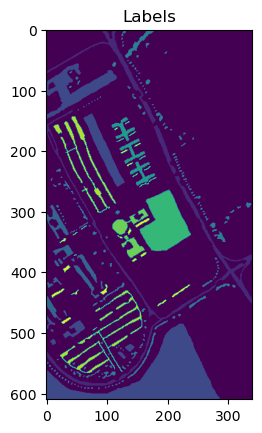

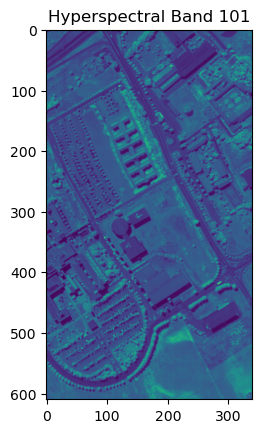

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 20 train


All datasets saved to the 'indices' folder.
(180, 5, 5, 103)
(45, 5, 5, 103)
(42551, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1193, PSNR: 5.7447


	 Training Batch [200/535], Loss: 0.0633, PSNR: 10.1947


	 Training Batch [400/535], Loss: 0.0317, PSNR: 13.0922


Epoch [1/50] Training Loss: 0.0558, PSNR: 11.1862
	[Val]   Batch [1/134] Loss: 0.0193, PSNR: 15.3450
	[Val]   Batch [10/134] Loss: 0.0168, PSNR: 17.7441
	[Val]   Batch [20/134] Loss: 0.0181, PSNR: 15.5322
	[Val]   Batch [30/134] Loss: 0.0197, PSNR: 14.9771
	[Val]   Batch [40/134] Loss: 0.0178, PSNR: 14.0290
	[Val]   Batch [50/134] Loss: 0.0189, PSNR: 15.1968
	[Val]   Batch [60/134] Loss: 0.0172, PSNR: 15.8517


	[Val]   Batch [70/134] Loss: 0.0164, PSNR: 16.0300
	[Val]   Batch [80/134] Loss: 0.0160, PSNR: 16.0335
	[Val]   Batch [90/134] Loss: 0.0167, PSNR: 16.0406
	[Val]   Batch [100/134] Loss: 0.0189, PSNR: 15.4401
	[Val]   Batch [110/134] Loss: 0.0192, PSNR: 13.9753
	[Val]   Batch [120/134] Loss: 0.0158, PSNR: 15.1217
	[Val]   Batch [130/134] Loss: 0.0174, PSNR: 13.1400
Epoch [1/50] Validation Loss: 0.0181, PSNR: 15.3903

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0201, PSNR: 15.1312


	 Training Batch [200/535], Loss: 0.0126, PSNR: 16.9347


	 Training Batch [400/535], Loss: 0.0086, PSNR: 17.6740


Epoch [2/50] Training Loss: 0.0116, PSNR: 17.4196
	[Val]   Batch [1/134] Loss: 0.0086, PSNR: 18.8501
	[Val]   Batch [10/134] Loss: 0.0068, PSNR: 21.6969
	[Val]   Batch [20/134] Loss: 0.0074, PSNR: 19.3917
	[Val]   Batch [30/134] Loss: 0.0085, PSNR: 18.6436
	[Val]   Batch [40/134] Loss: 0.0076, PSNR: 17.7451
	[Val]   Batch [50/134] Loss: 0.0079, PSNR: 19.0211
	[Val]   Batch [60/134] Loss: 0.0069, PSNR: 19.8343


	[Val]   Batch [70/134] Loss: 0.0066, PSNR: 19.9522
	[Val]   Batch [80/134] Loss: 0.0064, PSNR: 20.0336
	[Val]   Batch [90/134] Loss: 0.0068, PSNR: 19.9739
	[Val]   Batch [100/134] Loss: 0.0081, PSNR: 19.1214
	[Val]   Batch [110/134] Loss: 0.0077, PSNR: 17.9692
	[Val]   Batch [120/134] Loss: 0.0056, PSNR: 19.5906
	[Val]   Batch [130/134] Loss: 0.0069, PSNR: 17.1448


Epoch [2/50] Validation Loss: 0.0077, PSNR: 19.1322

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0088, PSNR: 16.8747


	 Training Batch [200/535], Loss: 0.0060, PSNR: 18.7325


	 Training Batch [400/535], Loss: 0.0077, PSNR: 19.2551


Epoch [3/50] Training Loss: 0.0068, PSNR: 19.6537
	[Val]   Batch [1/134] Loss: 0.0063, PSNR: 20.2219
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.1120
	[Val]   Batch [20/134] Loss: 0.0053, PSNR: 20.8420
	[Val]   Batch [30/134] Loss: 0.0060, PSNR: 20.1231
	[Val]   Batch [40/134] Loss: 0.0055, PSNR: 19.1083
	[Val]   Batch [50/134] Loss: 0.0056, PSNR: 20.4981
	[Val]   Batch [60/134] Loss: 0.0048, PSNR: 21.3578


	[Val]   Batch [70/134] Loss: 0.0048, PSNR: 21.3720
	[Val]   Batch [80/134] Loss: 0.0045, PSNR: 21.4935
	[Val]   Batch [90/134] Loss: 0.0049, PSNR: 21.4064
	[Val]   Batch [100/134] Loss: 0.0059, PSNR: 20.5197
	[Val]   Batch [110/134] Loss: 0.0053, PSNR: 19.5528
	[Val]   Batch [120/134] Loss: 0.0038, PSNR: 21.3355
	[Val]   Batch [130/134] Loss: 0.0049, PSNR: 18.6835
Epoch [3/50] Validation Loss: 0.0056, PSNR: 20.5359

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0059, PSNR: 20.5006


	 Training Batch [200/535], Loss: 0.0063, PSNR: 20.3513


	 Training Batch [400/535], Loss: 0.0036, PSNR: 22.6990


Epoch [4/50] Training Loss: 0.0051, PSNR: 20.9473
	[Val]   Batch [1/134] Loss: 0.0044, PSNR: 21.7594
	[Val]   Batch [10/134] Loss: 0.0035, PSNR: 24.5601
	[Val]   Batch [20/134] Loss: 0.0036, PSNR: 22.4925
	[Val]   Batch [30/134] Loss: 0.0041, PSNR: 21.8049
	[Val]   Batch [40/134] Loss: 0.0038, PSNR: 20.7780
	[Val]   Batch [50/134] Loss: 0.0037, PSNR: 22.2814
	[Val]   Batch [60/134] Loss: 0.0035, PSNR: 22.7791


	[Val]   Batch [70/134] Loss: 0.0034, PSNR: 22.8384
	[Val]   Batch [80/134] Loss: 0.0032, PSNR: 22.9814
	[Val]   Batch [90/134] Loss: 0.0034, PSNR: 22.9072
	[Val]   Batch [100/134] Loss: 0.0041, PSNR: 22.0504
	[Val]   Batch [110/134] Loss: 0.0035, PSNR: 21.3514
	[Val]   Batch [120/134] Loss: 0.0026, PSNR: 23.0212
	[Val]   Batch [130/134] Loss: 0.0032, PSNR: 20.4638
Epoch [4/50] Validation Loss: 0.0039, PSNR: 22.0830

LOG: Epoch [5/50]


	 Training Batch [1/535], Loss: 0.0038, PSNR: 22.2628


	 Training Batch [200/535], Loss: 0.0034, PSNR: 22.8010


	 Training Batch [400/535], Loss: 0.0030, PSNR: 23.3585


Epoch [5/50] Training Loss: 0.0037, PSNR: 22.3578
	[Val]   Batch [1/134] Loss: 0.0032, PSNR: 23.0973
	[Val]   Batch [10/134] Loss: 0.0026, PSNR: 25.8880
	[Val]   Batch [20/134] Loss: 0.0025, PSNR: 24.0798
	[Val]   Batch [30/134] Loss: 0.0029, PSNR: 23.3727
	[Val]   Batch [40/134] Loss: 0.0026, PSNR: 22.3985
	[Val]   Batch [50/134] Loss: 0.0025, PSNR: 23.9713
	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 23.9802


	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.1541
	[Val]   Batch [80/134] Loss: 0.0024, PSNR: 24.2913
	[Val]   Batch [90/134] Loss: 0.0026, PSNR: 24.1917
	[Val]   Batch [100/134] Loss: 0.0030, PSNR: 23.4866
	[Val]   Batch [110/134] Loss: 0.0023, PSNR: 23.1646
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.5788


	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.0647
Epoch [5/50] Validation Loss: 0.0029, PSNR: 23.4916

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0027, PSNR: 23.8466


	 Training Batch [200/535], Loss: 0.0032, PSNR: 23.1300


	 Training Batch [400/535], Loss: 0.0031, PSNR: 23.1144


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.3737
	[Val]   Batch [1/134] Loss: 0.0027, PSNR: 23.9275
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.7740
	[Val]   Batch [20/134] Loss: 0.0020, PSNR: 25.1862
	[Val]   Batch [30/134] Loss: 0.0023, PSNR: 24.3846
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.4822
	[Val]   Batch [50/134] Loss: 0.0020, PSNR: 25.0429
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.7934


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 25.0018
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.1912
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 25.0253
	[Val]   Batch [100/134] Loss: 0.0024, PSNR: 24.4201
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.3806
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.7009
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.1235
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.4351

LOG: Epoch [7/50]


	 Training Batch [1/535], Loss: 0.0032, PSNR: 23.0152


	 Training Batch [200/535], Loss: 0.0018, PSNR: 23.3944


	 Training Batch [400/535], Loss: 0.0027, PSNR: 23.8361


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.0385
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.4994
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.3979
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 25.9862
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.1229
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.2698
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.8286
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3728


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6087
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8152
	[Val]   Batch [90/134] Loss: 0.0019, PSNR: 25.5907
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.1046
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.2584
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5067
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.8358
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.1071

LOG: Epoch [8/50]


	 Training Batch [1/535], Loss: 0.0037, PSNR: 22.5394


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.5242


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.4148


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.4637
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.8510
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.7541
	[Val]   Batch [20/134] Loss: 0.0015, PSNR: 26.4727
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.5451
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.7307
	[Val]   Batch [50/134] Loss: 0.0015, PSNR: 26.2471
	[Val]   Batch [60/134] Loss: 0.0018, PSNR: 25.7412


	[Val]   Batch [70/134] Loss: 0.0017, PSNR: 25.9843
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.2327
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 25.9363
	[Val]   Batch [100/134] Loss: 0.0019, PSNR: 25.4928
	[Val]   Batch [110/134] Loss: 0.0013, PSNR: 25.7353
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0007
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 24.2427
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.5085

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 24.7493


	 Training Batch [200/535], Loss: 0.0016, PSNR: 24.4399


	 Training Batch [400/535], Loss: 0.0017, PSNR: 23.4391


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.8913
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2352
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1679
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.0766
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.0495
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3140
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.7655
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.1521


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3853
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.6706
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.3457
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.9753
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.3422
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5687
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7786
Epoch [9/50] Validation Loss: 0.0016, PSNR: 25.9893

LOG: Epoch [10/50]


	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.2485


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.9463


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.5463


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.1592
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4931
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4046
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4489
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3300
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6639
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.0821
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4390


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6328
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9553
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.6262
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.2660
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.6867
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.8702
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.0861
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.2888

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.2472


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.9849


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.2685


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4110
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6907
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6468
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7150
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.6199
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 25.9555
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.3445


	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6750
	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.8678
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2144
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8417
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5371
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 27.0216
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.1932


	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.3135
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5479

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.5001


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.7188


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.0228


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.6257
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9858
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9563
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1720
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0057
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.3618
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.7257
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0271


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.2024
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5876
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1962
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8670
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.4624
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6199
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.7147
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9084

LOG: Epoch [13/50]


	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.0120


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.8029


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.0239


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8156
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2079
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.1801
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.4847
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.2717
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.6482
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9870
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.2710


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4261
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.8507
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.4362
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1159
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.7504
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.8848
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.0013


Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.1692

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.1324


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.7417


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.3911


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9353
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3888
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3388
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.7316
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5089
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8596
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1839
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4914


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.6114
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0245
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.6201
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.3133
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9631
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0556
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.2042
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3683

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.0381


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.6996


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4109


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1705
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.5920
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5346
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0393
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7294
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1070
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4158
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7481


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8486
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2768
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8544
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5577
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1846
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2790
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4772
Epoch [15/50] Validation Loss: 0.0011, PSNR: 27.6039

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2251


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.5855


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.6857


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3607
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.7224
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6474
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.2558
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.9144
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.2852
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5195


	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.9729
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0359
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4383
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 28.0227
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7190
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2776
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3812


	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5979
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7684

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.3784


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.7378


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.2522


Epoch [17/50] Training Loss: 0.0014, PSNR: 26.4534
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9957
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8362
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.5625
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2012
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5160
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8155
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.2580


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3232
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6998
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.3090
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 27.9998
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5182
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5671
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8994
Epoch [17/50] Validation Loss: 0.0010, PSNR: 28.0207

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.0073


	 Training Batch [200/535], Loss: 0.0017, PSNR: 26.0100


	 Training Batch [400/535], Loss: 0.0014, PSNR: 28.5324


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6647
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2327
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0490
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.9231
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4942
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8282
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1022
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.5678


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.6448
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9696
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6057
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.3228
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7084
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7553
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1942
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.2903

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.2440


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.9273


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.6872


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.9199
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.5460
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2880
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.2956
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.8676
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.1399
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4578


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 28.9454
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.0303
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2880
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.9513
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.6737
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9489
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9714
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.4832


Epoch [19/50] Validation Loss: 0.0009, PSNR: 28.6106

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 27.9395


	 Training Batch [200/535], Loss: 0.0008, PSNR: 28.9031


	 Training Batch [400/535], Loss: 0.0010, PSNR: 26.2809


Epoch [20/50] Training Loss: 0.0013, PSNR: 27.1023
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.8049
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4706
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4922
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.1960
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.3585
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6901
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1977


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3210
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.5258
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.2641
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9752
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0969
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0730


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.6627
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.8510

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.1561


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.0885


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.6682


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.3085
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.0779
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6680
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7018
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.4461
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.5555
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.9240
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.4345


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.5989
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7189
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5346
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.2450
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1733
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1472
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.8655


Epoch [21/50] Validation Loss: 0.0008, PSNR: 29.0701

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.3528


	 Training Batch [200/535], Loss: 0.0010, PSNR: 27.9275


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9368


Epoch [22/50] Training Loss: 0.0011, PSNR: 27.4731
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.4310
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9531
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0724
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.8364
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.8922
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.2847


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.7676
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.9371
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0187
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.9492
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6160
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4272
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3913


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1557
Epoch [22/50] Validation Loss: 0.0007, PSNR: 29.4121

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.1915


	 Training Batch [200/535], Loss: 0.0008, PSNR: 28.4392


	 Training Batch [400/535], Loss: 0.0009, PSNR: 26.7667


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.5949
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.7247
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.1838
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3273
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.1391
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.1201
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.5944
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9607


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.1842
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2277
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.1812
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.9027
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6279
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.5525


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.3542
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.6617

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 25.3322


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.1386


	 Training Batch [400/535], Loss: 0.0009, PSNR: 25.8239


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.7958
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.0430
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4235
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5603
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4674
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.3136
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8496
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2358


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.5005
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.4887
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5046
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.2101
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8175
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7304
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5657
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.9426

LOG: Epoch [25/50]


	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.8531


	 Training Batch [200/535], Loss: 0.0007, PSNR: 27.7586


	 Training Batch [400/535], Loss: 0.0010, PSNR: 28.0523


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.9214
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2962
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6165
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7118
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6849
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4414
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0632
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4109


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7053
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6526
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.6927
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.4496
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9066
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7655
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6420
Epoch [25/50] Validation Loss: 0.0006, PSNR: 30.1426

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.5655


	 Training Batch [200/535], Loss: 0.0009, PSNR: 27.1343


	 Training Batch [400/535], Loss: 0.0013, PSNR: 28.9211


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0762
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.4874
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.7431
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.8594
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.8813
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5682
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.1842
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5224


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.8743
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8138
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 30.8942
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5895
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9993
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8882


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7698
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.3027

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.3790


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.7640


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.2452


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.2464
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.7813
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.9238
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1020
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.1806
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.7633
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.4972
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7408


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.0735
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9817
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.1200
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.8465
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1917
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0503
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9602


Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.5431

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.9096


	 Training Batch [200/535], Loss: 0.0009, PSNR: 27.0779


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.6300


Epoch [28/50] Training Loss: 0.0009, PSNR: 28.3265
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.8704
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.0351
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1231
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2791
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.8259
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.5404


	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8524
	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1693
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0950
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.2223
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.9314
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.2416
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0797
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 29.0119


Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.6427
Early stopping triggered at epoch 28. No improvement for 3 epochs.


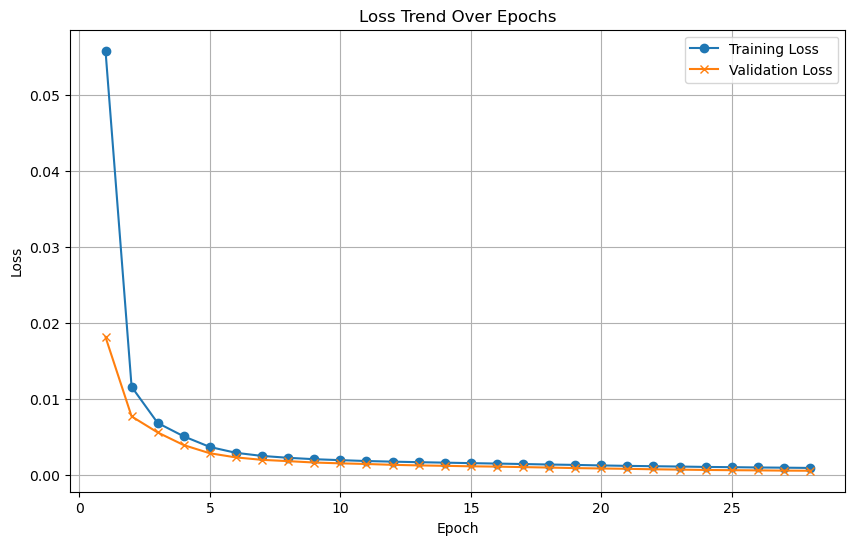

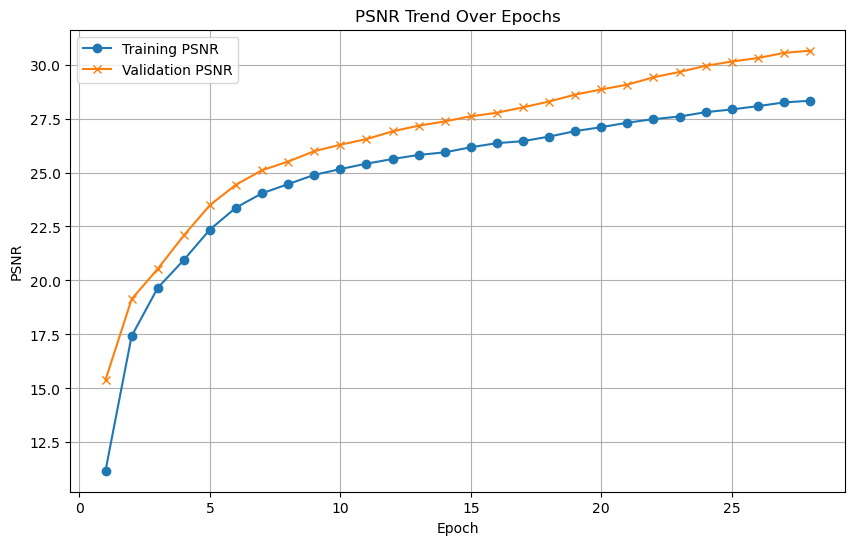

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...


    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2188
    Validation Batch [1/1], Loss: 2.2000
Validation Loss: 2.2000, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2000. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1728
    Validation Batch [1/1], Loss: 2.1999
Validation Loss: 2.1999, Validation Accuracy: 11.11%
Validation loss improved from 2.2000 to 2.1999. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1462
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 11.11%
Validation loss improved from 2.1999 to 2.1998. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1155
    Validation Batch [1/1], Loss: 2.1999
Validation Loss: 2.1999, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Ep

Epoch [20/1000] completed, Average Training Loss: 1.8480
    Validation Batch [1/1], Loss: 2.1948
Validation Loss: 2.1948, Validation Accuracy: 11.11%
Validation loss improved from 2.1962 to 2.1948. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 1.8407
    Validation Batch [1/1], Loss: 2.1930
Validation Loss: 2.1930, Validation Accuracy: 11.11%
Validation loss improved from 2.1948 to 2.1930. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8465
    Validation Batch [1/1], Loss: 2.1907
Validation Loss: 2.1907, Validation Accuracy: 11.11%
Validation loss improved from 2.1930 to 2.1907. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8234
    Validation Batch [1/1], Loss: 2.1881
Validation Loss: 2.1881, Validation Accuracy: 11.11%
Validation loss improved from 2.1907 to 2.1881. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [2

Epoch [49/1000] completed, Average Training Loss: 1.6273
    Validation Batch [1/1], Loss: 1.8409
Validation Loss: 1.8409, Validation Accuracy: 68.89%
Validation loss improved from 1.8605 to 1.8409. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.6187
    Validation Batch [1/1], Loss: 1.8205
Validation Loss: 1.8205, Validation Accuracy: 71.11%
Validation loss improved from 1.8409 to 1.8205. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.6052
    Validation Batch [1/1], Loss: 1.8004
Validation Loss: 1.8004, Validation Accuracy: 77.78%
Validation loss improved from 1.8205 to 1.8004. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.6087
    Validation Batch [1/1], Loss: 1.7803
Validation Loss: 1.7803, Validation Accuracy: 80.00%
Validation loss improved from 1.8004 to 1.7803. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 1.4574
Validation Loss: 1.4574, Validation Accuracy: 86.67%
Validation loss improved from 1.4625 to 1.4574. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.3878
    Validation Batch [1/1], Loss: 1.4465
Validation Loss: 1.4465, Validation Accuracy: 84.44%
Validation loss improved from 1.4574 to 1.4465. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.3679
    Validation Batch [1/1], Loss: 1.4315
Validation Loss: 1.4315, Validation Accuracy: 82.22%
Validation loss improved from 1.4465 to 1.4315. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.3790
    Validation Batch [1/1], Loss: 1.4172
Validation Loss: 1.4172, Validation Accuracy: 82.22%
Validation loss improved from 1.4315 to 1.4172. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.3804
    Vali

Epoch [107/1000] completed, Average Training Loss: 1.1399
    Validation Batch [1/1], Loss: 1.1894
Validation Loss: 1.1894, Validation Accuracy: 88.89%
Validation loss improved from 1.1955 to 1.1894. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.1349
    Validation Batch [1/1], Loss: 1.1866
Validation Loss: 1.1866, Validation Accuracy: 88.89%
Validation loss improved from 1.1894 to 1.1866. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.1264
    Validation Batch [1/1], Loss: 1.1744
Validation Loss: 1.1744, Validation Accuracy: 91.11%
Validation loss improved from 1.1866 to 1.1744. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.1274
    Validation Batch [1/1], Loss: 1.1670
Validation Loss: 1.1670, Validation Accuracy: 91.11%
Validation loss improved from 1.1744 to 1.1670. Saving model...

LOG: Epoch [111/1000] - Training


Epoch [136/1000] completed, Average Training Loss: 0.9572
    Validation Batch [1/1], Loss: 0.9837
Validation Loss: 0.9837, Validation Accuracy: 88.89%
Validation loss improved from 1.0011 to 0.9837. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.9068
    Validation Batch [1/1], Loss: 0.9704
Validation Loss: 0.9704, Validation Accuracy: 91.11%
Validation loss improved from 0.9837 to 0.9704. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.9014
    Validation Batch [1/1], Loss: 0.9603
Validation Loss: 0.9603, Validation Accuracy: 91.11%
Validation loss improved from 0.9704 to 0.9603. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.9271
    Validation Batch [1/1], Loss: 0.9536
Validation Loss: 0.9536, Validation Accuracy: 86.67%
Validation loss improved from 0.9603 to 0.9536. Saving model...

LOG: Epoch [140/1000] - Training


Epoch [167/1000] completed, Average Training Loss: 0.6690
    Validation Batch [1/1], Loss: 0.7914
Validation Loss: 0.7914, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.6842
    Validation Batch [1/1], Loss: 0.7794
Validation Loss: 0.7794, Validation Accuracy: 88.89%
Validation loss improved from 0.7885 to 0.7794. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.6822
    Validation Batch [1/1], Loss: 0.7705
Validation Loss: 0.7705, Validation Accuracy: 91.11%
Validation loss improved from 0.7794 to 0.7705. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.6626
    Validation Batch [1/1], Loss: 0.7622
Validation Loss: 0.7622, Validation Accuracy: 91.11%
Validation loss improved from 0.7705 to 0.7622. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000

Epoch [195/1000] completed, Average Training Loss: 0.5083
    Validation Batch [1/1], Loss: 0.6514
Validation Loss: 0.6514, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.5168
    Validation Batch [1/1], Loss: 0.6289
Validation Loss: 0.6289, Validation Accuracy: 91.11%
Validation loss improved from 0.6389 to 0.6289. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.4656
    Validation Batch [1/1], Loss: 0.6203
Validation Loss: 0.6203, Validation Accuracy: 91.11%
Validation loss improved from 0.6289 to 0.6203. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.4856
    Validation Batch [1/1], Loss: 0.6306
Validation Loss: 0.6306, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5317
Validation Loss: 0.5317, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.3685
    Validation Batch [1/1], Loss: 0.5245
Validation Loss: 0.5245, Validation Accuracy: 88.89%
Validation loss improved from 0.5281 to 0.5245. Saving model...

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.3736
    Validation Batch [1/1], Loss: 0.5124
Validation Loss: 0.5124, Validation Accuracy: 91.11%
Validation loss improved from 0.5245 to 0.5124. Saving model...

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.3729
    Validation Batch [1/1], Loss: 0.5149
Validation Loss: 0.5149, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.3690
    Validation Batch [1/1], Lo

Epoch [251/1000] completed, Average Training Loss: 0.2753
    Validation Batch [1/1], Loss: 0.4512
Validation Loss: 0.4512, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.2686
    Validation Batch [1/1], Loss: 0.4465
Validation Loss: 0.4465, Validation Accuracy: 91.11%
Validation loss improved from 0.4496 to 0.4465. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.2486
    Validation Batch [1/1], Loss: 0.4417
Validation Loss: 0.4417, Validation Accuracy: 91.11%
Validation loss improved from 0.4465 to 0.4417. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.2560
    Validation Batch [1/1], Loss: 0.4383
Validation Loss: 0.4383, Validation Accuracy: 91.11%
Validation loss improved from 0.4417 to 0.4383. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000

Epoch [280/1000] completed, Average Training Loss: 0.1903
    Validation Batch [1/1], Loss: 0.3977
Validation Loss: 0.3977, Validation Accuracy: 91.11%
Validation loss improved from 0.4014 to 0.3977. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.1706
    Validation Batch [1/1], Loss: 0.4149
Validation Loss: 0.4149, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.2199
    Validation Batch [1/1], Loss: 0.3872
Validation Loss: 0.3872, Validation Accuracy: 93.33%
Validation loss improved from 0.3977 to 0.3872. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.1874
    Validation Batch [1/1], Loss: 0.4379
Validation Loss: 0.4379, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Av

Epoch [309/1000] completed, Average Training Loss: 0.1474
    Validation Batch [1/1], Loss: 0.3773
Validation Loss: 0.3773, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.1469
    Validation Batch [1/1], Loss: 0.3746
Validation Loss: 0.3746, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.1541
    Validation Batch [1/1], Loss: 0.3835
Validation Loss: 0.3835, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.1458
    Validation Batch [1/1], Loss: 0.3927
Validation Loss: 0.3927, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.156

Epoch [338/1000] completed, Average Training Loss: 0.1133
    Validation Batch [1/1], Loss: 0.3632
Validation Loss: 0.3632, Validation Accuracy: 91.11%
Validation loss improved from 0.3637 to 0.3632. Saving model...

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.1149
    Validation Batch [1/1], Loss: 0.3733
Validation Loss: 0.3733, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.1266
    Validation Batch [1/1], Loss: 0.3788
Validation Loss: 0.3788, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.1206
    Validation Batch [1/1], Loss: 0.3802
Validation Loss: 0.3802, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training 

Epoch [365/1000] completed, Average Training Loss: 0.1038
    Validation Batch [1/1], Loss: 0.3438
Validation Loss: 0.3438, Validation Accuracy: 91.11%
Validation loss improved from 0.3449 to 0.3438. Saving model...

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.0927
    Validation Batch [1/1], Loss: 0.3533
Validation Loss: 0.3533, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0919
    Validation Batch [1/1], Loss: 0.3764
Validation Loss: 0.3764, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0940
    Validation Batch [1/1], Loss: 0.3805
Validation Loss: 0.3805, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training 

Epoch [396/1000] completed, Average Training Loss: 0.0700
    Validation Batch [1/1], Loss: 0.3697
Validation Loss: 0.3697, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.0775
    Validation Batch [1/1], Loss: 0.3714
Validation Loss: 0.3714, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0695
    Validation Batch [1/1], Loss: 0.3750
Validation Loss: 0.3750, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.3628
Validation Loss: 0.3628, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.074

    Validation Batch [1/1], Loss: 0.3711
Validation Loss: 0.3711, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.0625
    Validation Batch [1/1], Loss: 0.3439
Validation Loss: 0.3439, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0675
    Validation Batch [1/1], Loss: 0.3657
Validation Loss: 0.3657, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.0605
    Validation Batch [1/1], Loss: 0.3747
Validation Loss: 0.3747, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0542
    Validation Batch [1/1], Loss: 0.3513
Validation Loss

Epoch [451/1000] completed, Average Training Loss: 0.0586
    Validation Batch [1/1], Loss: 0.3456
Validation Loss: 0.3456, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0549
    Validation Batch [1/1], Loss: 0.3502
Validation Loss: 0.3502, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0482
    Validation Batch [1/1], Loss: 0.3536
Validation Loss: 0.3536, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.3568
Validation Loss: 0.3568, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.063

Epoch [480/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.3763
Validation Loss: 0.3763, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.0449
    Validation Batch [1/1], Loss: 0.4344
Validation Loss: 0.4344, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.4059
Validation Loss: 0.4059, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0440
    Validation Batch [1/1], Loss: 0.3784
Validation Loss: 0.3784, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.047

    Validation Batch [1/1], Loss: 0.3631
Validation Loss: 0.3631, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.3570
Validation Loss: 0.3570, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0412
    Validation Batch [1/1], Loss: 0.3608
Validation Loss: 0.3608, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.3783
Validation Loss: 0.3783, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.3789
Validation Loss

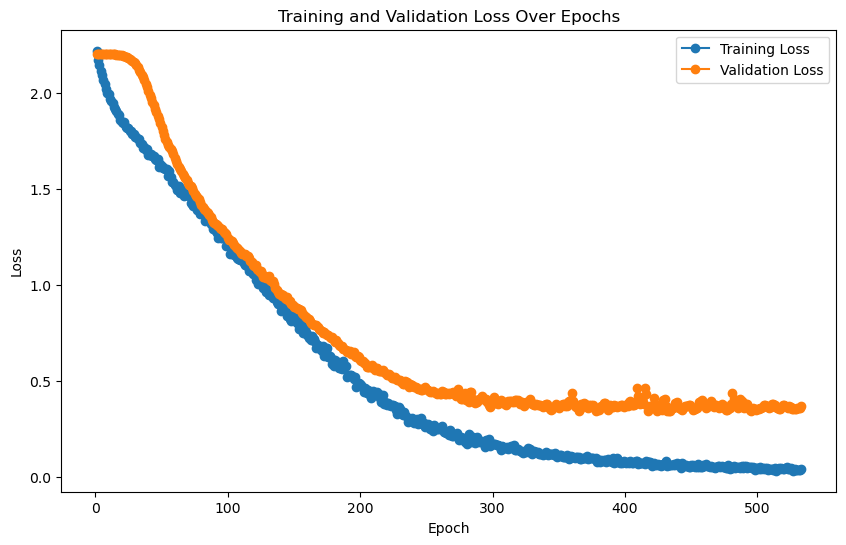

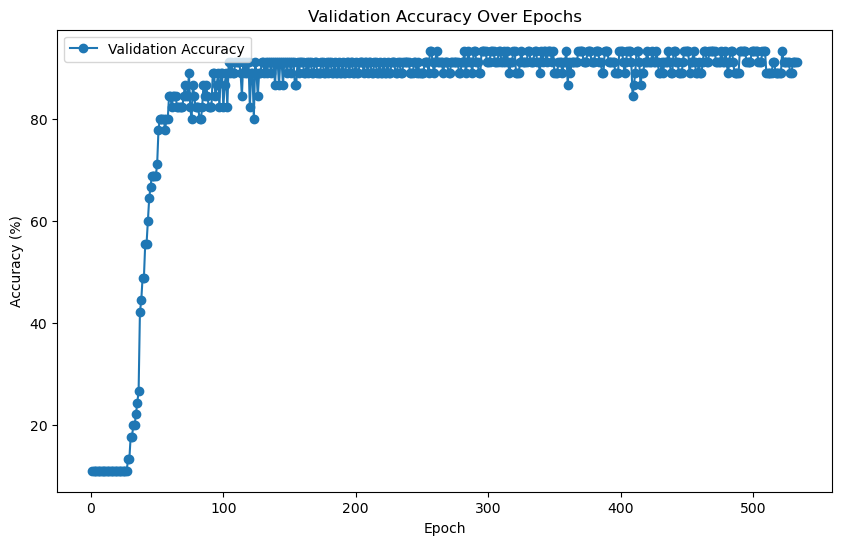


Evaluating on the test set...
    Test Batch [1/167], Loss: 0.9131



Final Test Loss: 0.4787, Test Accuracy: 83.69%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42551, 64), Test labels shape: (42551,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      0.80      0.80         5
           2       0.67      0.40      0.50         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.62      1.00      0.77         5
           7       0.57      0.80      0.67         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42551, 64)
Test labels shape: (42551,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6477  |  Val Loss: 2.3555
Validation loss improved from inf to 2.3555.
[Epoch 2/1000] Train Loss: 2.2947  |  Val Loss: 2.1469
Validation loss improved from 2.3555 to 2.1469.
[Epoch 3/1000] Train Loss: 2.0925  |  Val Loss: 1.9944
Validation loss improved from 2.1469 to 1.9944.
[Epoch 4/1000] Train Loss: 1.9406  |  Val Loss: 1.8865
Validation loss improved from 1.9944 to 1.8865.
[Epoch 5/1000] Train Loss: 1.8280  |  Val Loss: 1.7943
Validation loss improved from 1.8865 to 1.7943.
[Epoch 6/1000] Train Loss: 1.7401  |  Val Loss: 1.7151
Validation loss improved from 1.7943 to 1.7151.
[Epoch 7/1000] Train Loss: 1.6597  |  Val Loss: 1.6412
Validation loss improved from 1.7151 to 1.6412.


[Epoch 8/1000] Train Loss: 1.5829  |  Val Loss: 1.5686
Validation loss improved from 1.6412 to 1.5686.
[Epoch 9/1000] Train Loss: 1.5095  |  Val Loss: 1.4973
Validation loss improved from 1.5686 to 1.4973.
[Epoch 10/1000] Train Loss: 1.4352  |  Val Loss: 1.4239
Validation loss improved from 1.4973 to 1.4239.
[Epoch 11/1000] Train Loss: 1.3615  |  Val Loss: 1.3538
Validation loss improved from 1.4239 to 1.3538.
[Epoch 12/1000] Train Loss: 1.2917  |  Val Loss: 1.2862
Validation loss improved from 1.3538 to 1.2862.
[Epoch 13/1000] Train Loss: 1.2215  |  Val Loss: 1.2241
Validation loss improved from 1.2862 to 1.2241.
[Epoch 14/1000] Train Loss: 1.1551  |  Val Loss: 1.1663
Validation loss improved from 1.2241 to 1.1663.
[Epoch 15/1000] Train Loss: 1.0914  |  Val Loss: 1.1047
Validation loss improved from 1.1663 to 1.1047.
[Epoch 16/1000] Train Loss: 1.0374  |  Val Loss: 1.0461
Validation loss improved from 1.1047 to 1.0461.
[Epoch 17/1000] Train Loss: 0.9831  |  Val Loss: 0.9949
Validation

[Epoch 24/1000] Train Loss: 0.6823  |  Val Loss: 0.7406
Validation loss improved from 0.7633 to 0.7406.
[Epoch 25/1000] Train Loss: 0.6502  |  Val Loss: 0.7163
Validation loss improved from 0.7406 to 0.7163.
[Epoch 26/1000] Train Loss: 0.6225  |  Val Loss: 0.6931
Validation loss improved from 0.7163 to 0.6931.
[Epoch 27/1000] Train Loss: 0.6046  |  Val Loss: 0.6767
Validation loss improved from 0.6931 to 0.6767.
[Epoch 28/1000] Train Loss: 0.5897  |  Val Loss: 0.6640
Validation loss improved from 0.6767 to 0.6640.
[Epoch 29/1000] Train Loss: 0.5577  |  Val Loss: 0.6344
Validation loss improved from 0.6640 to 0.6344.
[Epoch 30/1000] Train Loss: 0.5366  |  Val Loss: 0.6265
Validation loss improved from 0.6344 to 0.6265.
[Epoch 31/1000] Train Loss: 0.5224  |  Val Loss: 0.6045
Validation loss improved from 0.6265 to 0.6045.
[Epoch 32/1000] Train Loss: 0.5163  |  Val Loss: 0.5994
Validation loss improved from 0.6045 to 0.5994.


[Epoch 33/1000] Train Loss: 0.4878  |  Val Loss: 0.5805
Validation loss improved from 0.5994 to 0.5805.
[Epoch 34/1000] Train Loss: 0.4764  |  Val Loss: 0.5864
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 0.4657  |  Val Loss: 0.5621
Validation loss improved from 0.5805 to 0.5621.
[Epoch 36/1000] Train Loss: 0.4550  |  Val Loss: 0.5662
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.4402  |  Val Loss: 0.5452
Validation loss improved from 0.5621 to 0.5452.
[Epoch 38/1000] Train Loss: 0.4211  |  Val Loss: 0.5512
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.4228  |  Val Loss: 0.5337
Validation loss improved from 0.5452 to 0.5337.


[Epoch 40/1000] Train Loss: 0.4044  |  Val Loss: 0.5226
Validation loss improved from 0.5337 to 0.5226.
[Epoch 41/1000] Train Loss: 0.3930  |  Val Loss: 0.5257
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.3870  |  Val Loss: 0.5232
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 0.3789  |  Val Loss: 0.5241
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 44/1000] Train Loss: 0.3758  |  Val Loss: 0.5103
Validation loss improved from 0.5226 to 0.5103.
[Epoch 45/1000] Train Loss: 0.3760  |  Val Loss: 0.5095
Validation loss improved from 0.5103 to 0.5095.
[Epoch 46/1000] Train Loss: 0.3599  |  Val Loss: 0.4995
Validation loss improved from 0.5095 to 0.4995.
[Epoch 47/1000] Train Loss: 0.3457  |  Val Loss: 0.5036
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 0.3440  |  Val Loss: 0.5062
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 49/1000] Train Loss: 0.3304

[Epoch 58/1000] Train Loss: 0.2772  |  Val Loss: 0.4890
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 0.2717  |  Val Loss: 0.4846
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 0.2663  |  Val Loss: 0.4909
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 61/1000] Train Loss: 0.2635  |  Val Loss: 0.4901
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 62/1000] Train Loss: 0.2539  |  Val Loss: 0.4817
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 63/1000] Train Loss: 0.2505  |  Val Loss: 0.4829
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 64/1000] Train Loss: 0.2442  |  Val Loss: 0.4826
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 65/1000] Train Loss: 0.2397  |  Val Loss: 0.4849
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 66/1000] Train Loss: 0.2395  |  Val Loss: 0.4920
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 67/1000] Train Loss: 0.2320  |  Val Loss: 0.4983
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 68/1000] Train Loss: 0.2314  |  Val Loss: 0.4827
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 69/1000] Train Loss: 0.2247  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 70/1000] Train Loss: 0.2149  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 71/1000] Train Loss: 0.2166  |  Val Loss: 0.4975
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 72/1000] Train Loss: 0.2091  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 73/1000] Train Loss: 0.2153  |  Val Loss: 0.4888
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 74/1000] Train Loss: 0.2007  |  Val Loss: 0.5048
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 75/1000] Train Loss: 0.2034  |  Val Loss: 0.4911
!! Validation loss did NOT improve !! Patience: 18/100
[

[Epoch 90/1000] Train Loss: 0.1562  |  Val Loss: 0.5095
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 91/1000] Train Loss: 0.1440  |  Val Loss: 0.5234
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 92/1000] Train Loss: 0.1508  |  Val Loss: 0.5252
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 93/1000] Train Loss: 0.1386  |  Val Loss: 0.5164
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 94/1000] Train Loss: 0.1422  |  Val Loss: 0.5193
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 95/1000] Train Loss: 0.1372  |  Val Loss: 0.5343
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 96/1000] Train Loss: 0.1354  |  Val Loss: 0.5288
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 97/1000] Train Loss: 0.1464  |  Val Loss: 0.5347
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 98/1000] Train Loss: 0.1414  |  Val Loss: 0.5530
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 99/1000] Train Loss: 0.1318  |  Val Loss: 0.5309
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 100/1000] Train Loss: 0.1390  |  Val Loss: 0.5323
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 101/1000] Train Loss: 0.1178  |  Val Loss: 0.5633
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 102/1000] Train Loss: 0.1310  |  Val Loss: 0.5479
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 103/1000] Train Loss: 0.1210  |  Val Loss: 0.5311
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 104/1000] Train Loss: 0.1210  |  Val Loss: 0.5505
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 105/1000] Train Loss: 0.1231  |  Val Loss: 0.5632
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 106/1000] Train Loss: 0.1129  |  Val Loss: 0.5497
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 107/1000] Train Loss: 0.1106  |  Val Loss: 0.5485
!! Validation loss did NOT improve !! Patience: 

[Epoch 120/1000] Train Loss: 0.0915  |  Val Loss: 0.5889
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 121/1000] Train Loss: 0.0894  |  Val Loss: 0.5976
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 122/1000] Train Loss: 0.0860  |  Val Loss: 0.5979
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 123/1000] Train Loss: 0.0855  |  Val Loss: 0.5957
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 124/1000] Train Loss: 0.0813  |  Val Loss: 0.6095
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 125/1000] Train Loss: 0.0841  |  Val Loss: 0.6106
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 126/1000] Train Loss: 0.0800  |  Val Loss: 0.6036
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 127/1000] Train Loss: 0.0783  |  Val Loss: 0.6049
!! Validation loss did NOT improve !! Patience: 70/100


[Epoch 128/1000] Train Loss: 0.0770  |  Val Loss: 0.6077
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 129/1000] Train Loss: 0.0749  |  Val Loss: 0.6100
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 130/1000] Train Loss: 0.0757  |  Val Loss: 0.6266
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 131/1000] Train Loss: 0.0747  |  Val Loss: 0.6233
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 132/1000] Train Loss: 0.0772  |  Val Loss: 0.6164
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 133/1000] Train Loss: 0.0743  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 134/1000] Train Loss: 0.0723  |  Val Loss: 0.6325
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 135/1000] Train Loss: 0.0712  |  Val Loss: 0.6333
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 136/1000] Train Loss: 0.0682  |  Val Loss: 0.6214
!! Validation loss did NOT improve !! Patience:

[Epoch 152/1000] Train Loss: 0.0532  |  Val Loss: 0.6680
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 153/1000] Train Loss: 0.0539  |  Val Loss: 0.6809
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 154/1000] Train Loss: 0.0528  |  Val Loss: 0.6914
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 155/1000] Train Loss: 0.0503  |  Val Loss: 0.6841
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 156/1000] Train Loss: 0.0513  |  Val Loss: 0.6815
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 157/1000] Train Loss: 0.0492  |  Val Loss: 0.6942
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 157 !!
No improvement for 100 epochs.


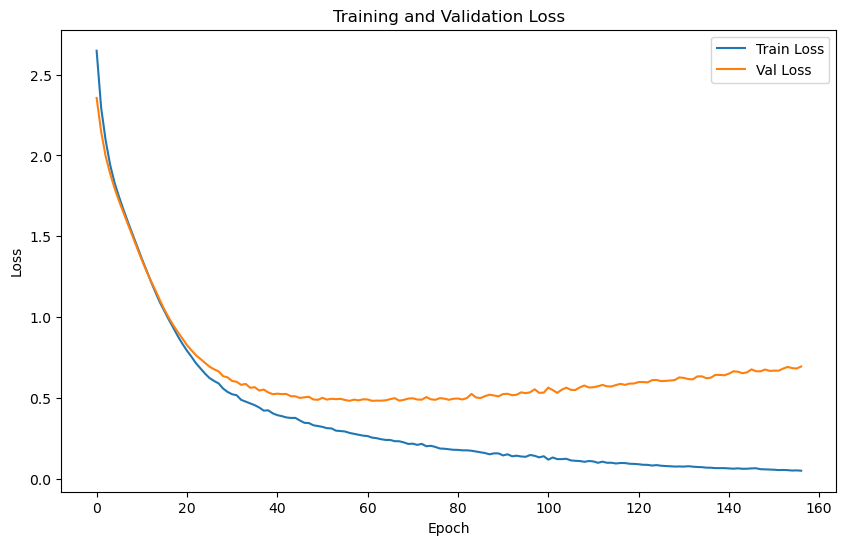

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.0281 | Test Accuracy: 73.38%


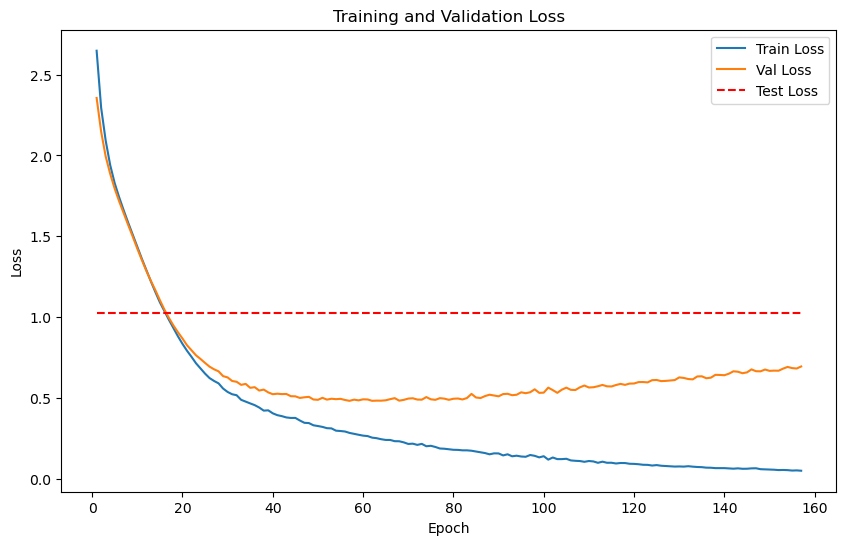

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.8996
Epoch [1/2000], Avg Train Loss: 8.8996
Epoch [1/2000], Avg Val Loss: 3.8548
Validation loss improved from inf to 3.8548. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.8850
Epoch [2/2000], Avg Train Loss: 8.8850
Epoch [2/2000], Avg Val Loss: 3.8120
Validation loss improved from 3.8548 to 3.8120. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.9599
Epoch [3/2000], Avg Train Loss: 8.9599
Epoch [3/2000], Avg Val Loss: 3.7707
Validation loss improved from 3.8120 to 3.7707. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.8644
Epoch [4/2000], Avg Train Loss: 8.8644
Epoch [4/2000], Avg Val Loss: 3.7303
Validation loss improved from 3.7707 to 3.7303. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6029
Epoch [5/2000], Avg Train Loss: 8.6029
Epoch [5/2000], Avg Val Loss: 3.6911
Validation loss improved from 3.7303 to 3.6911. Saving mode

Epoch [9/2000], Avg Val Loss: 3.5474
Validation loss improved from 3.5813 to 3.5474. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 8.2986
Epoch [10/2000], Avg Train Loss: 8.2986
Epoch [10/2000], Avg Val Loss: 3.5146
Validation loss improved from 3.5474 to 3.5146. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 8.2905
Epoch [11/2000], Avg Train Loss: 8.2905
Epoch [11/2000], Avg Val Loss: 3.4828
Validation loss improved from 3.5146 to 3.4828. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.1380
Epoch [12/2000], Avg Train Loss: 8.1380
Epoch [12/2000], Avg Val Loss: 3.4522
Validation loss improved from 3.4828 to 3.4522. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.0480
Epoch [13/2000], Avg Train Loss: 8.0480
Epoch [13/2000], Avg Val Loss: 3.4227
Validation loss improved from 3.4522 to 3.4227. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 7.4635
Epoch [22/2000], Avg Train Loss: 7.4635
Epoch [22/2000], Avg Val Loss: 3.1993
Validation loss improved from 3.2206 to 3.1993. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.3715
Epoch [23/2000], Avg Train Loss: 7.3715
Epoch [23/2000], Avg Val Loss: 3.1789
Validation loss improved from 3.1993 to 3.1789. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.2539
Epoch [24/2000], Avg Train Loss: 7.2539
Epoch [24/2000], Avg Val Loss: 3.1593
Validation loss improved from 3.1789 to 3.1593. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.2242
Epoch [25/2000], Avg Train Loss: 7.2242
Epoch [25/2000], Avg Val Loss: 3.1403
Validation loss improved from 3.1593 to 3.1403. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.0925
Epoch [26/2000], Avg Train Loss: 7.0925
Epoch [26/2000], Avg Val Loss: 3.1220
Validation loss improved from 3.1403 to 3.

Epoch [32/2000], Avg Val Loss: 3.0268
Validation loss improved from 3.0411 to 3.0268. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.9030
Epoch [33/2000], Avg Train Loss: 6.9030
Epoch [33/2000], Avg Val Loss: 3.0131
Validation loss improved from 3.0268 to 3.0131. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.8195
Epoch [34/2000], Avg Train Loss: 6.8195
Epoch [34/2000], Avg Val Loss: 2.9999
Validation loss improved from 3.0131 to 2.9999. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.6914
Epoch [35/2000], Avg Train Loss: 6.6914
Epoch [35/2000], Avg Val Loss: 2.9872
Validation loss improved from 2.9999 to 2.9872. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.5400
Epoch [36/2000], Avg Train Loss: 6.5400
Epoch [36/2000], Avg Val Loss: 2.9751
Validation loss improved from 2.9872 to 2.9751. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Trai

Epoch [47/2000], Avg Val Loss: 2.8707
Validation loss improved from 2.8783 to 2.8707. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.1340
Epoch [48/2000], Avg Train Loss: 6.1340
Epoch [48/2000], Avg Val Loss: 2.8634
Validation loss improved from 2.8707 to 2.8634. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.1880
Epoch [49/2000], Avg Train Loss: 6.1880
Epoch [49/2000], Avg Val Loss: 2.8564
Validation loss improved from 2.8634 to 2.8564. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.0698
Epoch [50/2000], Avg Train Loss: 6.0698
Epoch [50/2000], Avg Val Loss: 2.8498
Validation loss improved from 2.8564 to 2.8498. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.9420
Epoch [51/2000], Avg Train Loss: 5.9420
Epoch [51/2000], Avg Val Loss: 2.8434
Validation loss improved from 2.8498 to 2.8434. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.8037
Epoch [57/2000], Avg Train Loss: 5.8037
Epoch [57/2000], Avg Val Loss: 2.8104
Validation loss improved from 2.8154 to 2.8104. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.7143
Epoch [58/2000], Avg Train Loss: 5.7143
Epoch [58/2000], Avg Val Loss: 2.8057
Validation loss improved from 2.8104 to 2.8057. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.8155
Epoch [59/2000], Avg Train Loss: 5.8155
Epoch [59/2000], Avg Val Loss: 2.8011
Validation loss improved from 2.8057 to 2.8011. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.8120
Epoch [60/2000], Avg Train Loss: 5.8120
Epoch [60/2000], Avg Val Loss: 2.7967
Validation loss improved from 2.8011 to 2.7967. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.6829
Epoch [61/2000], Avg Train Loss: 5.6829
Epoch [61/2000], Avg Val Loss: 2.7925
Validation loss improved from 2.7967 to 2.

Epoch [64/2000], Avg Val Loss: 2.7809
Validation loss improved from 2.7846 to 2.7809. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.6709
Epoch [65/2000], Avg Train Loss: 5.6709
Epoch [65/2000], Avg Val Loss: 2.7773
Validation loss improved from 2.7809 to 2.7773. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.5406
Epoch [66/2000], Avg Train Loss: 5.5406
Epoch [66/2000], Avg Val Loss: 2.7738
Validation loss improved from 2.7773 to 2.7738. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.5790
Epoch [67/2000], Avg Train Loss: 5.5790
Epoch [67/2000], Avg Val Loss: 2.7705
Validation loss improved from 2.7738 to 2.7705. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.4796
Epoch [68/2000], Avg Train Loss: 5.4796
Epoch [68/2000], Avg Val Loss: 2.7673
Validation loss improved from 2.7705 to 2.7673. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Trai

Epoch [73/2000], Avg Val Loss: 2.7531
Validation loss improved from 2.7557 to 2.7531. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.4375
Epoch [74/2000], Avg Train Loss: 5.4375
Epoch [74/2000], Avg Val Loss: 2.7505
Validation loss improved from 2.7531 to 2.7505. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.3506
Epoch [75/2000], Avg Train Loss: 5.3506
Epoch [75/2000], Avg Val Loss: 2.7480
Validation loss improved from 2.7505 to 2.7480. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.3714
Epoch [76/2000], Avg Train Loss: 5.3714
Epoch [76/2000], Avg Val Loss: 2.7456
Validation loss improved from 2.7480 to 2.7456. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.2322
Epoch [77/2000], Avg Train Loss: 5.2322
Epoch [77/2000], Avg Val Loss: 2.7433
Validation loss improved from 2.7456 to 2.7433. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Trai

Epoch [89/2000], Avg Val Loss: 2.7196
Validation loss improved from 2.7212 to 2.7196. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.1054
Epoch [90/2000], Avg Train Loss: 5.1054
Epoch [90/2000], Avg Val Loss: 2.7179
Validation loss improved from 2.7196 to 2.7179. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.0021
Epoch [91/2000], Avg Train Loss: 5.0021
Epoch [91/2000], Avg Val Loss: 2.7163
Validation loss improved from 2.7179 to 2.7163. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.0363
Epoch [92/2000], Avg Train Loss: 5.0363
Epoch [92/2000], Avg Val Loss: 2.7147
Validation loss improved from 2.7163 to 2.7147. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.0240
Epoch [93/2000], Avg Train Loss: 5.0240
Epoch [93/2000], Avg Val Loss: 2.7131
Validation loss improved from 2.7147 to 2.7131. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.9390
Epoch [101/2000], Avg Train Loss: 4.9390
Epoch [101/2000], Avg Val Loss: 2.7013
Validation loss improved from 2.7027 to 2.7013. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.9238
Epoch [102/2000], Avg Train Loss: 4.9238
Epoch [102/2000], Avg Val Loss: 2.6999
Validation loss improved from 2.7013 to 2.6999. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.9700
Epoch [103/2000], Avg Train Loss: 4.9700
Epoch [103/2000], Avg Val Loss: 2.6985
Validation loss improved from 2.6999 to 2.6985. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.9549
Epoch [104/2000], Avg Train Loss: 4.9549
Epoch [104/2000], Avg Val Loss: 2.6972
Validation loss improved from 2.6985 to 2.6972. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.9673
Epoch [105/2000], Avg Train Loss: 4.9673
Epoch [105/2000], Avg Val Loss: 2.6958
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9281
Epoch [110/2000], Avg Train Loss: 4.9281
Epoch [110/2000], Avg Val Loss: 2.6892
Validation loss improved from 2.6904 to 2.6892. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.9236
Epoch [111/2000], Avg Train Loss: 4.9236
Epoch [111/2000], Avg Val Loss: 2.6879
Validation loss improved from 2.6892 to 2.6879. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.9165
Epoch [112/2000], Avg Train Loss: 4.9165
Epoch [112/2000], Avg Val Loss: 2.6867
Validation loss improved from 2.6879 to 2.6867. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.8395
Epoch [113/2000], Avg Train Loss: 4.8395
Epoch [113/2000], Avg Val Loss: 2.6855
Validation loss improved from 2.6867 to 2.6855. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.8417
Epoch [114/2000], Avg Train Loss: 4.8417
Epoch [114/2000], Avg Val Loss: 2.6842
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8886
Epoch [116/2000], Avg Train Loss: 4.8886
Epoch [116/2000], Avg Val Loss: 2.6818
Validation loss improved from 2.6830 to 2.6818. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.9008
Epoch [117/2000], Avg Train Loss: 4.9008
Epoch [117/2000], Avg Val Loss: 2.6806
Validation loss improved from 2.6818 to 2.6806. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.8786
Epoch [118/2000], Avg Train Loss: 4.8786
Epoch [118/2000], Avg Val Loss: 2.6794
Validation loss improved from 2.6806 to 2.6794. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.8030
Epoch [119/2000], Avg Train Loss: 4.8030
Epoch [119/2000], Avg Val Loss: 2.6783
Validation loss improved from 2.6794 to 2.6783. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.7779
Epoch [120/2000], Avg Train Loss: 4.7779
Epoch [120/2000], Avg Val Loss: 2.6771
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7669
Epoch [131/2000], Avg Train Loss: 4.7669
Epoch [131/2000], Avg Val Loss: 2.6646
Validation loss improved from 2.6657 to 2.6646. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.7428
Epoch [132/2000], Avg Train Loss: 4.7428
Epoch [132/2000], Avg Val Loss: 2.6635
Validation loss improved from 2.6646 to 2.6635. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.6703
Epoch [133/2000], Avg Train Loss: 4.6703
Epoch [133/2000], Avg Val Loss: 2.6624
Validation loss improved from 2.6635 to 2.6624. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.7751
Epoch [134/2000], Avg Train Loss: 4.7751
Epoch [134/2000], Avg Val Loss: 2.6613
Validation loss improved from 2.6624 to 2.6613. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.7869
Epoch [135/2000], Avg Train Loss: 4.7869
Epoch [135/2000], Avg Val Loss: 2.6602
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7201
Epoch [143/2000], Avg Train Loss: 4.7201
Epoch [143/2000], Avg Val Loss: 2.6512
Validation loss improved from 2.6523 to 2.6512. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.6409
Epoch [144/2000], Avg Train Loss: 4.6409
Epoch [144/2000], Avg Val Loss: 2.6501
Validation loss improved from 2.6512 to 2.6501. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.6404
Epoch [145/2000], Avg Train Loss: 4.6404
Epoch [145/2000], Avg Val Loss: 2.6489
Validation loss improved from 2.6501 to 2.6489. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.6645
Epoch [146/2000], Avg Train Loss: 4.6645
Epoch [146/2000], Avg Val Loss: 2.6478
Validation loss improved from 2.6489 to 2.6478. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.6971
Epoch [147/2000], Avg Train Loss: 4.6971
Epoch [147/2000], Avg Val Loss: 2.6467
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6706
Epoch [152/2000], Avg Train Loss: 4.6706
Epoch [152/2000], Avg Val Loss: 2.6414
Validation loss improved from 2.6424 to 2.6414. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.6285
Epoch [153/2000], Avg Train Loss: 4.6285
Epoch [153/2000], Avg Val Loss: 2.6403
Validation loss improved from 2.6414 to 2.6403. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.6531
Epoch [154/2000], Avg Train Loss: 4.6531
Epoch [154/2000], Avg Val Loss: 2.6393
Validation loss improved from 2.6403 to 2.6393. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.6271
Epoch [155/2000], Avg Train Loss: 4.6271
Epoch [155/2000], Avg Val Loss: 2.6382
Validation loss improved from 2.6393 to 2.6382. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.6195
Epoch [156/2000], Avg Train Loss: 4.6195
Epoch [156/2000], Avg Val Loss: 2.6371
Validation loss improved fro

Epoch [174/2000], Avg Val Loss: 2.6169
Validation loss improved from 2.6180 to 2.6169. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.5131
Epoch [175/2000], Avg Train Loss: 4.5131
Epoch [175/2000], Avg Val Loss: 2.6158
Validation loss improved from 2.6169 to 2.6158. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.5321
Epoch [176/2000], Avg Train Loss: 4.5321
Epoch [176/2000], Avg Val Loss: 2.6146
Validation loss improved from 2.6158 to 2.6146. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.4879
Epoch [177/2000], Avg Train Loss: 4.4879
Epoch [177/2000], Avg Val Loss: 2.6135
Validation loss improved from 2.6146 to 2.6135. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.5117
Epoch [178/2000], Avg Train Loss: 4.5117
Epoch [178/2000], Avg Val Loss: 2.6123
Validation loss improved from 2.6135 to 2.6123. Saving model...

LOG: Epoch [179/2000] - Training
    Bat

Epoch [190/2000], Avg Val Loss: 2.5993
Validation loss improved from 2.6003 to 2.5993. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.5196
Epoch [191/2000], Avg Train Loss: 4.5196
Epoch [191/2000], Avg Val Loss: 2.5982
Validation loss improved from 2.5993 to 2.5982. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.5456
Epoch [192/2000], Avg Train Loss: 4.5456
Epoch [192/2000], Avg Val Loss: 2.5972
Validation loss improved from 2.5982 to 2.5972. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.4431
Epoch [193/2000], Avg Train Loss: 4.4431
Epoch [193/2000], Avg Val Loss: 2.5962
Validation loss improved from 2.5972 to 2.5962. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.5223
Epoch [194/2000], Avg Train Loss: 4.5223
Epoch [194/2000], Avg Val Loss: 2.5952
Validation loss improved from 2.5962 to 2.5952. Saving model...

LOG: Epoch [195/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4679
Epoch [199/2000], Avg Train Loss: 4.4679
Epoch [199/2000], Avg Val Loss: 2.5902
Validation loss improved from 2.5912 to 2.5902. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.3991
Epoch [200/2000], Avg Train Loss: 4.3991
Epoch [200/2000], Avg Val Loss: 2.5892
Validation loss improved from 2.5902 to 2.5892. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.4251
Epoch [201/2000], Avg Train Loss: 4.4251
Epoch [201/2000], Avg Val Loss: 2.5882
Validation loss improved from 2.5892 to 2.5882. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.4974
Epoch [202/2000], Avg Train Loss: 4.4974
Epoch [202/2000], Avg Val Loss: 2.5872
Validation loss improved from 2.5882 to 2.5872. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.3908
Epoch [203/2000], Avg Train Loss: 4.3908
Epoch [203/2000], Avg Val Loss: 2.5862
Validation loss improved fro

Epoch [214/2000], Avg Val Loss: 2.5753
Validation loss improved from 2.5762 to 2.5753. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.4044
Epoch [215/2000], Avg Train Loss: 4.4044
Epoch [215/2000], Avg Val Loss: 2.5743
Validation loss improved from 2.5753 to 2.5743. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.3704
Epoch [216/2000], Avg Train Loss: 4.3704
Epoch [216/2000], Avg Val Loss: 2.5734
Validation loss improved from 2.5743 to 2.5734. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.3979
Epoch [217/2000], Avg Train Loss: 4.3979
Epoch [217/2000], Avg Val Loss: 2.5725
Validation loss improved from 2.5734 to 2.5725. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.3331
Epoch [218/2000], Avg Train Loss: 4.3331
Epoch [218/2000], Avg Val Loss: 2.5715
Validation loss improved from 2.5725 to 2.5715. Saving model...

LOG: Epoch [219/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3277
Epoch [234/2000], Avg Train Loss: 4.3277
Epoch [234/2000], Avg Val Loss: 2.5569
Validation loss improved from 2.5578 to 2.5569. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.3359
Epoch [235/2000], Avg Train Loss: 4.3359
Epoch [235/2000], Avg Val Loss: 2.5560
Validation loss improved from 2.5569 to 2.5560. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.3021
Epoch [236/2000], Avg Train Loss: 4.3021
Epoch [236/2000], Avg Val Loss: 2.5551
Validation loss improved from 2.5560 to 2.5551. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.3640
Epoch [237/2000], Avg Train Loss: 4.3640
Epoch [237/2000], Avg Val Loss: 2.5543
Validation loss improved from 2.5551 to 2.5543. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.3534
Epoch [238/2000], Avg Train Loss: 4.3534
Epoch [238/2000], Avg Val Loss: 2.5534
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3236
Epoch [243/2000], Avg Train Loss: 4.3236
Epoch [243/2000], Avg Val Loss: 2.5491
Validation loss improved from 2.5499 to 2.5491. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.3359
Epoch [244/2000], Avg Train Loss: 4.3359
Epoch [244/2000], Avg Val Loss: 2.5482
Validation loss improved from 2.5491 to 2.5482. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.3400
Epoch [245/2000], Avg Train Loss: 4.3400
Epoch [245/2000], Avg Val Loss: 2.5473
Validation loss improved from 2.5482 to 2.5473. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.3473
Epoch [246/2000], Avg Train Loss: 4.3473
Epoch [246/2000], Avg Val Loss: 2.5465
Validation loss improved from 2.5473 to 2.5465. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 4.3085
Epoch [247/2000], Avg Train Loss: 4.3085
Epoch [247/2000], Avg Val Loss: 2.5456
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3071
Epoch [259/2000], Avg Train Loss: 4.3071
Epoch [259/2000], Avg Val Loss: 2.5357
Validation loss improved from 2.5365 to 2.5357. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.3024
Epoch [260/2000], Avg Train Loss: 4.3024
Epoch [260/2000], Avg Val Loss: 2.5349
Validation loss improved from 2.5357 to 2.5349. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.2858
Epoch [261/2000], Avg Train Loss: 4.2858
Epoch [261/2000], Avg Val Loss: 2.5341
Validation loss improved from 2.5349 to 2.5341. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.3087
Epoch [262/2000], Avg Train Loss: 4.3087
Epoch [262/2000], Avg Val Loss: 2.5333
Validation loss improved from 2.5341 to 2.5333. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.3100
Epoch [263/2000], Avg Train Loss: 4.3100
Epoch [263/2000], Avg Val Loss: 2.5325
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2167
Epoch [275/2000], Avg Train Loss: 4.2167
Epoch [275/2000], Avg Val Loss: 2.5235
Validation loss improved from 2.5242 to 2.5235. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.2166
Epoch [276/2000], Avg Train Loss: 4.2166
Epoch [276/2000], Avg Val Loss: 2.5228
Validation loss improved from 2.5235 to 2.5228. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.2639
Epoch [277/2000], Avg Train Loss: 4.2639
Epoch [277/2000], Avg Val Loss: 2.5221
Validation loss improved from 2.5228 to 2.5221. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.3002
Epoch [278/2000], Avg Train Loss: 4.3002
Epoch [278/2000], Avg Val Loss: 2.5214
Validation loss improved from 2.5221 to 2.5214. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.2157
Epoch [279/2000], Avg Train Loss: 4.2157
Epoch [279/2000], Avg Val Loss: 2.5207
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3057
Epoch [282/2000], Avg Train Loss: 4.3057
Epoch [282/2000], Avg Val Loss: 2.5187
Validation loss improved from 2.5193 to 2.5187. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 4.2476
Epoch [283/2000], Avg Train Loss: 4.2476
Epoch [283/2000], Avg Val Loss: 2.5180
Validation loss improved from 2.5187 to 2.5180. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.2184
Epoch [284/2000], Avg Train Loss: 4.2184
Epoch [284/2000], Avg Val Loss: 2.5173
Validation loss improved from 2.5180 to 2.5173. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.2449
Epoch [285/2000], Avg Train Loss: 4.2449
Epoch [285/2000], Avg Val Loss: 2.5167
Validation loss improved from 2.5173 to 2.5167. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.2629
Epoch [286/2000], Avg Train Loss: 4.2629
Epoch [286/2000], Avg Val Loss: 2.5160
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2699
Epoch [298/2000], Avg Train Loss: 4.2699
Epoch [298/2000], Avg Val Loss: 2.5081
Validation loss improved from 2.5087 to 2.5081. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.2248
Epoch [299/2000], Avg Train Loss: 4.2248
Epoch [299/2000], Avg Val Loss: 2.5074
Validation loss improved from 2.5081 to 2.5074. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.2437
Epoch [300/2000], Avg Train Loss: 4.2437
Epoch [300/2000], Avg Val Loss: 2.5068
Validation loss improved from 2.5074 to 2.5068. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.2090
Epoch [301/2000], Avg Train Loss: 4.2090
Epoch [301/2000], Avg Val Loss: 2.5062
Validation loss improved from 2.5068 to 2.5062. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.2075
Epoch [302/2000], Avg Train Loss: 4.2075
Epoch [302/2000], Avg Val Loss: 2.5056
Validation loss improved fro

Epoch [317/2000], Avg Val Loss: 2.4967
Validation loss improved from 2.4973 to 2.4967. Saving model...

LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 4.1908
Epoch [318/2000], Avg Train Loss: 4.1908
Epoch [318/2000], Avg Val Loss: 2.4962
Validation loss improved from 2.4967 to 2.4962. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 4.2057
Epoch [319/2000], Avg Train Loss: 4.2057
Epoch [319/2000], Avg Val Loss: 2.4956
Validation loss improved from 2.4962 to 2.4956. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.1732
Epoch [320/2000], Avg Train Loss: 4.1732
Epoch [320/2000], Avg Val Loss: 2.4951
Validation loss improved from 2.4956 to 2.4951. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.2465
Epoch [321/2000], Avg Train Loss: 4.2465
Epoch [321/2000], Avg Val Loss: 2.4945
Validation loss improved from 2.4951 to 2.4945. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.1917
Epoch [322/2000], Avg Train Loss: 4.1917
Epoch [322/2000], Avg Val Loss: 2.4940
Validation loss improved fro

Epoch [340/2000], Avg Val Loss: 2.4848
Validation loss improved from 2.4853 to 2.4848. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.1870
Epoch [341/2000], Avg Train Loss: 4.1870
Epoch [341/2000], Avg Val Loss: 2.4843
Validation loss improved from 2.4848 to 2.4843. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.1652
Epoch [342/2000], Avg Train Loss: 4.1652
Epoch [342/2000], Avg Val Loss: 2.4838
Validation loss improved from 2.4843 to 2.4838. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 4.0987
Epoch [343/2000], Avg Train Loss: 4.0987
Epoch [343/2000], Avg Val Loss: 2.4833
Validation loss improved from 2.4838 to 2.4833. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.1633
Epoch [344/2000], Avg Train Loss: 4.1633
Epoch [344/2000], Avg Val Loss: 2.4828
Validation loss improved from 2.4833 to 2.4828. Saving model...

LOG: Epoch [345/2000] - Training
    Bat

Epoch [359/2000], Avg Val Loss: 2.4754
Validation loss improved from 2.4759 to 2.4754. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.0935
Epoch [360/2000], Avg Train Loss: 4.0935
Epoch [360/2000], Avg Val Loss: 2.4749
Validation loss improved from 2.4754 to 2.4749. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.0713
Epoch [361/2000], Avg Train Loss: 4.0713
Epoch [361/2000], Avg Val Loss: 2.4744
Validation loss improved from 2.4749 to 2.4744. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 4.1381
Epoch [362/2000], Avg Train Loss: 4.1381
Epoch [362/2000], Avg Val Loss: 2.4740
Validation loss improved from 2.4744 to 2.4740. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 4.1139
Epoch [363/2000], Avg Train Loss: 4.1139
Epoch [363/2000], Avg Val Loss: 2.4736
Validation loss improved from 2.4740 to 2.4736. Saving model...

LOG: Epoch [364/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0913
Epoch [380/2000], Avg Train Loss: 4.0913
Epoch [380/2000], Avg Val Loss: 2.4665
Validation loss improved from 2.4669 to 2.4665. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 4.0856
Epoch [381/2000], Avg Train Loss: 4.0856
Epoch [381/2000], Avg Val Loss: 2.4661
Validation loss improved from 2.4665 to 2.4661. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 4.1251
Epoch [382/2000], Avg Train Loss: 4.1251
Epoch [382/2000], Avg Val Loss: 2.4657
Validation loss improved from 2.4661 to 2.4657. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.1180
Epoch [383/2000], Avg Train Loss: 4.1180
Epoch [383/2000], Avg Val Loss: 2.4654
Validation loss improved from 2.4657 to 2.4654. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.0567
Epoch [384/2000], Avg Train Loss: 4.0567
Epoch [384/2000], Avg Val Loss: 2.4650
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0655
Epoch [400/2000], Avg Train Loss: 4.0655
Epoch [400/2000], Avg Val Loss: 2.4595
Validation loss improved from 2.4599 to 2.4595. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.0742
Epoch [401/2000], Avg Train Loss: 4.0742
Epoch [401/2000], Avg Val Loss: 2.4592
Validation loss improved from 2.4595 to 2.4592. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.0831
Epoch [402/2000], Avg Train Loss: 4.0831
Epoch [402/2000], Avg Val Loss: 2.4589
Validation loss improved from 2.4592 to 2.4589. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.0414
Epoch [403/2000], Avg Train Loss: 4.0414
Epoch [403/2000], Avg Val Loss: 2.4585
Validation loss improved from 2.4589 to 2.4585. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.1237
Epoch [404/2000], Avg Train Loss: 4.1237
Epoch [404/2000], Avg Val Loss: 2.4582
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0372
Epoch [425/2000], Avg Train Loss: 4.0372
Epoch [425/2000], Avg Val Loss: 2.4520
Validation loss improved from 2.4523 to 2.4520. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.0415
Epoch [426/2000], Avg Train Loss: 4.0415
Epoch [426/2000], Avg Val Loss: 2.4517
Validation loss improved from 2.4520 to 2.4517. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.0399
Epoch [427/2000], Avg Train Loss: 4.0399
Epoch [427/2000], Avg Val Loss: 2.4513
Validation loss improved from 2.4517 to 2.4513. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.0743
Epoch [428/2000], Avg Train Loss: 4.0743
Epoch [428/2000], Avg Val Loss: 2.4510
Validation loss improved from 2.4513 to 2.4510. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.0311
Epoch [429/2000], Avg Train Loss: 4.0311
Epoch [429/2000], Avg Val Loss: 2.4507
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9993
Epoch [443/2000], Avg Train Loss: 3.9993
Epoch [443/2000], Avg Val Loss: 2.4463
Validation loss improved from 2.4466 to 2.4463. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.0156
Epoch [444/2000], Avg Train Loss: 4.0156
Epoch [444/2000], Avg Val Loss: 2.4460
Validation loss improved from 2.4463 to 2.4460. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 4.0670
Epoch [445/2000], Avg Train Loss: 4.0670
Epoch [445/2000], Avg Val Loss: 2.4457
Validation loss improved from 2.4460 to 2.4457. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.0104
Epoch [446/2000], Avg Train Loss: 4.0104
Epoch [446/2000], Avg Val Loss: 2.4455
Validation loss improved from 2.4457 to 2.4455. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.0409
Epoch [447/2000], Avg Train Loss: 4.0409
Epoch [447/2000], Avg Val Loss: 2.4452
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9765
Epoch [468/2000], Avg Train Loss: 3.9765
Epoch [468/2000], Avg Val Loss: 2.4389
Validation loss improved from 2.4392 to 2.4389. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 4.0363
Epoch [469/2000], Avg Train Loss: 4.0363
Epoch [469/2000], Avg Val Loss: 2.4387
Validation loss improved from 2.4389 to 2.4387. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 4.0404
Epoch [470/2000], Avg Train Loss: 4.0404
Epoch [470/2000], Avg Val Loss: 2.4384
Validation loss improved from 2.4387 to 2.4384. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 3.9401
Epoch [471/2000], Avg Train Loss: 3.9401
Epoch [471/2000], Avg Val Loss: 2.4382
Validation loss improved from 2.4384 to 2.4382. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.0110
Epoch [472/2000], Avg Train Loss: 4.0110
Epoch [472/2000], Avg Val Loss: 2.4379
Validation loss improved fro

Epoch [485/2000], Avg Val Loss: 2.4350
Validation loss improved from 2.4352 to 2.4350. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.0070
Epoch [486/2000], Avg Train Loss: 4.0070
Epoch [486/2000], Avg Val Loss: 2.4348
Validation loss improved from 2.4350 to 2.4348. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.0461
Epoch [487/2000], Avg Train Loss: 4.0461
Epoch [487/2000], Avg Val Loss: 2.4346
Validation loss improved from 2.4348 to 2.4346. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.0248
Epoch [488/2000], Avg Train Loss: 4.0248
Epoch [488/2000], Avg Val Loss: 2.4343
Validation loss improved from 2.4346 to 2.4343. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 3.9839
Epoch [489/2000], Avg Train Loss: 3.9839
Epoch [489/2000], Avg Val Loss: 2.4341
Validation loss improved from 2.4343 to 2.4341. Saving model...

LOG: Epoch [490/2000] - Training
    Bat

Epoch [510/2000], Avg Val Loss: 2.4299
Validation loss improved from 2.4301 to 2.4299. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 3.9959
Epoch [511/2000], Avg Train Loss: 3.9959
Epoch [511/2000], Avg Val Loss: 2.4298
Validation loss improved from 2.4299 to 2.4298. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 3.9980
Epoch [512/2000], Avg Train Loss: 3.9980
Epoch [512/2000], Avg Val Loss: 2.4296
Validation loss improved from 2.4298 to 2.4296. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 3.9616
Epoch [513/2000], Avg Train Loss: 3.9616
Epoch [513/2000], Avg Val Loss: 2.4295
Validation loss improved from 2.4296 to 2.4295. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 3.9793
Epoch [514/2000], Avg Train Loss: 3.9793
Epoch [514/2000], Avg Val Loss: 2.4293
Validation loss improved from 2.4295 to 2.4293. Saving model...

LOG: Epoch [515/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9867
Epoch [531/2000], Avg Train Loss: 3.9867
Epoch [531/2000], Avg Val Loss: 2.4261
Validation loss improved from 2.4262 to 2.4261. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 3.9633
Epoch [532/2000], Avg Train Loss: 3.9633
Epoch [532/2000], Avg Val Loss: 2.4259
Validation loss improved from 2.4261 to 2.4259. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 3.9215
Epoch [533/2000], Avg Train Loss: 3.9215
Epoch [533/2000], Avg Val Loss: 2.4257
Validation loss improved from 2.4259 to 2.4257. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 4.0008
Epoch [534/2000], Avg Train Loss: 4.0008
Epoch [534/2000], Avg Val Loss: 2.4255
Validation loss improved from 2.4257 to 2.4255. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 3.9730
Epoch [535/2000], Avg Train Loss: 3.9730
Epoch [535/2000], Avg Val Loss: 2.4254
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9584
Epoch [556/2000], Avg Train Loss: 3.9584
Epoch [556/2000], Avg Val Loss: 2.4213
Validation loss improved from 2.4215 to 2.4213. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 3.9790
Epoch [557/2000], Avg Train Loss: 3.9790
Epoch [557/2000], Avg Val Loss: 2.4211
Validation loss improved from 2.4213 to 2.4211. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 3.9222
Epoch [558/2000], Avg Train Loss: 3.9222
Epoch [558/2000], Avg Val Loss: 2.4209
Validation loss improved from 2.4211 to 2.4209. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 3.9839
Epoch [559/2000], Avg Train Loss: 3.9839
Epoch [559/2000], Avg Val Loss: 2.4207
Validation loss improved from 2.4209 to 2.4207. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.9382
Epoch [560/2000], Avg Train Loss: 3.9382
Epoch [560/2000], Avg Val Loss: 2.4205
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9529
Epoch [577/2000], Avg Train Loss: 3.9529
Epoch [577/2000], Avg Val Loss: 2.4175
Validation loss improved from 2.4177 to 2.4175. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 3.8959
Epoch [578/2000], Avg Train Loss: 3.8959
Epoch [578/2000], Avg Val Loss: 2.4174
Validation loss improved from 2.4175 to 2.4174. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 3.9571
Epoch [579/2000], Avg Train Loss: 3.9571
Epoch [579/2000], Avg Val Loss: 2.4173
Validation loss improved from 2.4174 to 2.4173. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.9620
Epoch [580/2000], Avg Train Loss: 3.9620
Epoch [580/2000], Avg Val Loss: 2.4171
Validation loss improved from 2.4173 to 2.4171. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 3.9414
Epoch [581/2000], Avg Train Loss: 3.9414
Epoch [581/2000], Avg Val Loss: 2.4169
Validation loss improved fro

Epoch [595/2000], Avg Val Loss: 2.4143
Validation loss improved from 2.4145 to 2.4143. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.9530
Epoch [596/2000], Avg Train Loss: 3.9530
Epoch [596/2000], Avg Val Loss: 2.4142
Validation loss improved from 2.4143 to 2.4142. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 3.9207
Epoch [597/2000], Avg Train Loss: 3.9207
Epoch [597/2000], Avg Val Loss: 2.4140
Validation loss improved from 2.4142 to 2.4140. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.9152
Epoch [598/2000], Avg Train Loss: 3.9152
Epoch [598/2000], Avg Val Loss: 2.4138
Validation loss improved from 2.4140 to 2.4138. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 3.9254
Epoch [599/2000], Avg Train Loss: 3.9254
Epoch [599/2000], Avg Val Loss: 2.4137
Validation loss improved from 2.4138 to 2.4137. Saving model...

LOG: Epoch [600/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8919
Epoch [620/2000], Avg Train Loss: 3.8919
Epoch [620/2000], Avg Val Loss: 2.4101
Validation loss improved from 2.4104 to 2.4101. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 3.9229
Epoch [621/2000], Avg Train Loss: 3.9229
Epoch [621/2000], Avg Val Loss: 2.4099
Validation loss improved from 2.4101 to 2.4099. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.8754
Epoch [622/2000], Avg Train Loss: 3.8754
Epoch [622/2000], Avg Val Loss: 2.4097
Validation loss improved from 2.4099 to 2.4097. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.9370
Epoch [623/2000], Avg Train Loss: 3.9370
Epoch [623/2000], Avg Val Loss: 2.4095
Validation loss improved from 2.4097 to 2.4095. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.8894
Epoch [624/2000], Avg Train Loss: 3.8894
Epoch [624/2000], Avg Val Loss: 2.4093
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8636
Epoch [636/2000], Avg Train Loss: 3.8636
Epoch [636/2000], Avg Val Loss: 2.4072
Validation loss improved from 2.4074 to 2.4072. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.8790
Epoch [637/2000], Avg Train Loss: 3.8790
Epoch [637/2000], Avg Val Loss: 2.4070
Validation loss improved from 2.4072 to 2.4070. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.8962
Epoch [638/2000], Avg Train Loss: 3.8962
Epoch [638/2000], Avg Val Loss: 2.4069
Validation loss improved from 2.4070 to 2.4069. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.9510
Epoch [639/2000], Avg Train Loss: 3.9510
Epoch [639/2000], Avg Val Loss: 2.4067
Validation loss improved from 2.4069 to 2.4067. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.8922
Epoch [640/2000], Avg Train Loss: 3.8922
Epoch [640/2000], Avg Val Loss: 2.4065
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8833
Epoch [663/2000], Avg Train Loss: 3.8833
Epoch [663/2000], Avg Val Loss: 2.4026
Validation loss improved from 2.4028 to 2.4026. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.9281
Epoch [664/2000], Avg Train Loss: 3.9281
Epoch [664/2000], Avg Val Loss: 2.4025
Validation loss improved from 2.4026 to 2.4025. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.8710
Epoch [665/2000], Avg Train Loss: 3.8710
Epoch [665/2000], Avg Val Loss: 2.4025
Validation loss improved from 2.4025 to 2.4025. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.8760
Epoch [666/2000], Avg Train Loss: 3.8760
Epoch [666/2000], Avg Val Loss: 2.4024
Validation loss improved from 2.4025 to 2.4024. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.8641
Epoch [667/2000], Avg Train Loss: 3.8641
Epoch [667/2000], Avg Val Loss: 2.4023
Validation loss improved fro

Epoch [678/2000], Avg Val Loss: 2.4012
Validation loss improved from 2.4013 to 2.4012. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 3.8615
Epoch [679/2000], Avg Train Loss: 3.8615
Epoch [679/2000], Avg Val Loss: 2.4010
Validation loss improved from 2.4012 to 2.4010. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 3.8851
Epoch [680/2000], Avg Train Loss: 3.8851
Epoch [680/2000], Avg Val Loss: 2.4009
Validation loss improved from 2.4010 to 2.4009. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.8533
Epoch [681/2000], Avg Train Loss: 3.8533
Epoch [681/2000], Avg Val Loss: 2.4008
Validation loss improved from 2.4009 to 2.4008. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.8911
Epoch [682/2000], Avg Train Loss: 3.8911
Epoch [682/2000], Avg Val Loss: 2.4006
Validation loss improved from 2.4008 to 2.4006. Saving model...

LOG: Epoch [683/2000] - Training
    Bat

Epoch [704/2000], Avg Val Loss: 2.3970
Validation loss improved from 2.3972 to 2.3970. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.8834
Epoch [705/2000], Avg Train Loss: 3.8834
Epoch [705/2000], Avg Val Loss: 2.3968
Validation loss improved from 2.3970 to 2.3968. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 3.8306
Epoch [706/2000], Avg Train Loss: 3.8306
Epoch [706/2000], Avg Val Loss: 2.3967
Validation loss improved from 2.3968 to 2.3967. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 3.8847
Epoch [707/2000], Avg Train Loss: 3.8847
Epoch [707/2000], Avg Val Loss: 2.3965
Validation loss improved from 2.3967 to 2.3965. Saving model...

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 3.8790
Epoch [708/2000], Avg Train Loss: 3.8790
Epoch [708/2000], Avg Val Loss: 2.3963
Validation loss improved from 2.3965 to 2.3963. Saving model...

LOG: Epoch [709/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8287
Epoch [723/2000], Avg Train Loss: 3.8287
Epoch [723/2000], Avg Val Loss: 2.3938
Validation loss improved from 2.3939 to 2.3938. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.8486
Epoch [724/2000], Avg Train Loss: 3.8486
Epoch [724/2000], Avg Val Loss: 2.3936
Validation loss improved from 2.3938 to 2.3936. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.8420
Epoch [725/2000], Avg Train Loss: 3.8420
Epoch [725/2000], Avg Val Loss: 2.3935
Validation loss improved from 2.3936 to 2.3935. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.8479
Epoch [726/2000], Avg Train Loss: 3.8479
Epoch [726/2000], Avg Val Loss: 2.3934
Validation loss improved from 2.3935 to 2.3934. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.8489
Epoch [727/2000], Avg Train Loss: 3.8489
Epoch [727/2000], Avg Val Loss: 2.3932
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8502
Epoch [749/2000], Avg Train Loss: 3.8502
Epoch [749/2000], Avg Val Loss: 2.3914
Validation loss improved from 2.3915 to 2.3914. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 3.8432
Epoch [750/2000], Avg Train Loss: 3.8432
Epoch [750/2000], Avg Val Loss: 2.3913
Validation loss improved from 2.3914 to 2.3913. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 3.8711
Epoch [751/2000], Avg Train Loss: 3.8711
Epoch [751/2000], Avg Val Loss: 2.3911
Validation loss improved from 2.3913 to 2.3911. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 3.8144
Epoch [752/2000], Avg Train Loss: 3.8144
Epoch [752/2000], Avg Val Loss: 2.3910
Validation loss improved from 2.3911 to 2.3910. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 3.8495
Epoch [753/2000], Avg Train Loss: 3.8495
Epoch [753/2000], Avg Val Loss: 2.3908
Validation loss improved fro

Epoch [766/2000], Avg Val Loss: 2.3893
Validation loss improved from 2.3895 to 2.3893. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 3.8569
Epoch [767/2000], Avg Train Loss: 3.8569
Epoch [767/2000], Avg Val Loss: 2.3892
Validation loss improved from 2.3893 to 2.3892. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 3.8438
Epoch [768/2000], Avg Train Loss: 3.8438
Epoch [768/2000], Avg Val Loss: 2.3891
Validation loss improved from 2.3892 to 2.3891. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.8147
Epoch [769/2000], Avg Train Loss: 3.8147
Epoch [769/2000], Avg Val Loss: 2.3889
Validation loss improved from 2.3891 to 2.3889. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.8147
Epoch [770/2000], Avg Train Loss: 3.8147
Epoch [770/2000], Avg Val Loss: 2.3887
Validation loss improved from 2.3889 to 2.3887. Saving model...

LOG: Epoch [771/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8406
Epoch [795/2000], Avg Train Loss: 3.8406
Epoch [795/2000], Avg Val Loss: 2.3846
Validation loss improved from 2.3848 to 2.3846. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 3.8024
Epoch [796/2000], Avg Train Loss: 3.8024
Epoch [796/2000], Avg Val Loss: 2.3844
Validation loss improved from 2.3846 to 2.3844. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 3.8526
Epoch [797/2000], Avg Train Loss: 3.8526
Epoch [797/2000], Avg Val Loss: 2.3843
Validation loss improved from 2.3844 to 2.3843. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.8139
Epoch [798/2000], Avg Train Loss: 3.8139
Epoch [798/2000], Avg Val Loss: 2.3843
Validation loss improved from 2.3843 to 2.3843. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 3.8418
Epoch [799/2000], Avg Train Loss: 3.8418
Epoch [799/2000], Avg Val Loss: 2.3841
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7918
Epoch [811/2000], Avg Train Loss: 3.7918
Epoch [811/2000], Avg Val Loss: 2.3829
Validation loss improved from 2.3830 to 2.3829. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.8176
Epoch [812/2000], Avg Train Loss: 3.8176
Epoch [812/2000], Avg Val Loss: 2.3827
Validation loss improved from 2.3829 to 2.3827. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 3.8020
Epoch [813/2000], Avg Train Loss: 3.8020
Epoch [813/2000], Avg Val Loss: 2.3826
Validation loss improved from 2.3827 to 2.3826. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.7936
Epoch [814/2000], Avg Train Loss: 3.7936
Epoch [814/2000], Avg Val Loss: 2.3825
Validation loss improved from 2.3826 to 2.3825. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.8237
Epoch [815/2000], Avg Train Loss: 3.8237
Epoch [815/2000], Avg Val Loss: 2.3824
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8470
Epoch [838/2000], Avg Train Loss: 3.8470
Epoch [838/2000], Avg Val Loss: 2.3789
Validation loss improved from 2.3790 to 2.3789. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.8262
Epoch [839/2000], Avg Train Loss: 3.8262
Epoch [839/2000], Avg Val Loss: 2.3787
Validation loss improved from 2.3789 to 2.3787. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.8069
Epoch [840/2000], Avg Train Loss: 3.8069
Epoch [840/2000], Avg Val Loss: 2.3785
Validation loss improved from 2.3787 to 2.3785. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.8000
Epoch [841/2000], Avg Train Loss: 3.8000
Epoch [841/2000], Avg Val Loss: 2.3784
Validation loss improved from 2.3785 to 2.3784. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 3.8138
Epoch [842/2000], Avg Train Loss: 3.8138
Epoch [842/2000], Avg Val Loss: 2.3783
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7832
Epoch [852/2000], Avg Train Loss: 3.7832
Epoch [852/2000], Avg Val Loss: 2.3777
Validation loss improved from 2.3778 to 2.3777. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.8083
Epoch [853/2000], Avg Train Loss: 3.8083
Epoch [853/2000], Avg Val Loss: 2.3777
Validation loss improved from 2.3777 to 2.3777. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.7835
Epoch [854/2000], Avg Train Loss: 3.7835
Epoch [854/2000], Avg Val Loss: 2.3777
Validation loss improved from 2.3777 to 2.3777. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.8149
Epoch [855/2000], Avg Train Loss: 3.8149
Epoch [855/2000], Avg Val Loss: 2.3777
Validation loss improved from 2.3777 to 2.3777. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.8135
Epoch [856/2000], Avg Train Loss: 3.8135
Epoch [856/2000], Avg Val Loss: 2.3776
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7704
Epoch [880/2000], Avg Train Loss: 3.7704
Epoch [880/2000], Avg Val Loss: 2.3754
Validation loss improved from 2.3756 to 2.3754. Saving model...

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.7619
Epoch [881/2000], Avg Train Loss: 3.7619
Epoch [881/2000], Avg Val Loss: 2.3754
Validation loss improved from 2.3754 to 2.3754. Saving model...

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 3.7817
Epoch [882/2000], Avg Train Loss: 3.7817
Epoch [882/2000], Avg Val Loss: 2.3753
Validation loss improved from 2.3754 to 2.3753. Saving model...

LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 3.7837
Epoch [883/2000], Avg Train Loss: 3.7837
Epoch [883/2000], Avg Val Loss: 2.3753
Validation loss improved from 2.3753 to 2.3753. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 3.7808
Epoch [884/2000], Avg Train Loss: 3.7808
Epoch [884/2000], Avg Val Loss: 2.3752
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8096
Epoch [897/2000], Avg Train Loss: 3.8096
Epoch [897/2000], Avg Val Loss: 2.3735
Validation loss improved from 2.3737 to 2.3735. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 3.7869
Epoch [898/2000], Avg Train Loss: 3.7869
Epoch [898/2000], Avg Val Loss: 2.3734
Validation loss improved from 2.3735 to 2.3734. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 3.8095
Epoch [899/2000], Avg Train Loss: 3.8095
Epoch [899/2000], Avg Val Loss: 2.3732
Validation loss improved from 2.3734 to 2.3732. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 3.7522
Epoch [900/2000], Avg Train Loss: 3.7522
Epoch [900/2000], Avg Val Loss: 2.3731
Validation loss improved from 2.3732 to 2.3731. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 3.7842
Epoch [901/2000], Avg Train Loss: 3.7842
Epoch [901/2000], Avg Val Loss: 2.3729
Validation loss improved fro

Epoch [924/2000], Avg Val Loss: 2.3701
Validation loss improved from 2.3702 to 2.3701. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 3.7824
Epoch [925/2000], Avg Train Loss: 3.7824
Epoch [925/2000], Avg Val Loss: 2.3701
Validation loss improved from 2.3701 to 2.3701. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 3.8202
Epoch [926/2000], Avg Train Loss: 3.8202
Epoch [926/2000], Avg Val Loss: 2.3700
Validation loss improved from 2.3701 to 2.3700. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 3.7846
Epoch [927/2000], Avg Train Loss: 3.7846
Epoch [927/2000], Avg Val Loss: 2.3699
Validation loss improved from 2.3700 to 2.3699. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 3.8185
Epoch [928/2000], Avg Train Loss: 3.8185
Epoch [928/2000], Avg Val Loss: 2.3698
Validation loss improved from 2.3699 to 2.3698. Saving model...

LOG: Epoch [929/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7756
Epoch [940/2000], Avg Train Loss: 3.7756
Epoch [940/2000], Avg Val Loss: 2.3687
Validation loss improved from 2.3687 to 2.3687. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 3.7489
Epoch [941/2000], Avg Train Loss: 3.7489
Epoch [941/2000], Avg Val Loss: 2.3687
Validation loss improved from 2.3687 to 2.3687. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.7662
Epoch [942/2000], Avg Train Loss: 3.7662
Epoch [942/2000], Avg Val Loss: 2.3686
Validation loss improved from 2.3687 to 2.3686. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.7494
Epoch [943/2000], Avg Train Loss: 3.7494
Epoch [943/2000], Avg Val Loss: 2.3686
Validation loss improved from 2.3686 to 2.3686. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.7956
Epoch [944/2000], Avg Train Loss: 3.7956
Epoch [944/2000], Avg Val Loss: 2.3685
Validation loss improved fro

Epoch [967/2000], Avg Val Loss: 2.3644
Validation loss improved from 2.3646 to 2.3644. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 3.7627
Epoch [968/2000], Avg Train Loss: 3.7627
Epoch [968/2000], Avg Val Loss: 2.3643
Validation loss improved from 2.3644 to 2.3643. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 3.7419
Epoch [969/2000], Avg Train Loss: 3.7419
Epoch [969/2000], Avg Val Loss: 2.3641
Validation loss improved from 2.3643 to 2.3641. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 3.7577
Epoch [970/2000], Avg Train Loss: 3.7577
Epoch [970/2000], Avg Val Loss: 2.3640
Validation loss improved from 2.3641 to 2.3640. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 3.7462
Epoch [971/2000], Avg Train Loss: 3.7462
Epoch [971/2000], Avg Val Loss: 2.3639
Validation loss improved from 2.3640 to 2.3639. Saving model...

LOG: Epoch [972/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7671
Epoch [981/2000], Avg Train Loss: 3.7671
Epoch [981/2000], Avg Val Loss: 2.3634
Validation loss improved from 2.3634 to 2.3634. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 3.7740
Epoch [982/2000], Avg Train Loss: 3.7740
Epoch [982/2000], Avg Val Loss: 2.3634
Validation loss did not improve. Patience: 1/100

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 3.7425
Epoch [983/2000], Avg Train Loss: 3.7425
Epoch [983/2000], Avg Val Loss: 2.3634
Validation loss did not improve. Patience: 2/100

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 3.7597
Epoch [984/2000], Avg Train Loss: 3.7597
Epoch [984/2000], Avg Val Loss: 2.3635
Validation loss did not improve. Patience: 3/100

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.7585
Epoch [985/2000], Avg Train Loss: 3.7585
Epoch [985/2000], Avg Val Loss: 2.3636
Validation loss did not improve. Patience: 4/100

LOG: Epoch [986/2000] -

    Batch [1/1], Train Loss: 3.7334
Epoch [1011/2000], Avg Train Loss: 3.7334
Epoch [1011/2000], Avg Val Loss: 2.3620
Validation loss improved from 2.3620 to 2.3620. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.7279
Epoch [1012/2000], Avg Train Loss: 3.7279
Epoch [1012/2000], Avg Val Loss: 2.3619
Validation loss improved from 2.3620 to 2.3619. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 3.7519
Epoch [1013/2000], Avg Train Loss: 3.7519
Epoch [1013/2000], Avg Val Loss: 2.3619
Validation loss improved from 2.3619 to 2.3619. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 3.7660
Epoch [1014/2000], Avg Train Loss: 3.7660
Epoch [1014/2000], Avg Val Loss: 2.3618
Validation loss improved from 2.3619 to 2.3618. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.7553
Epoch [1015/2000], Avg Train Loss: 3.7553
Epoch [1015/2000], Avg Val Loss: 2.3618
Validation los

Epoch [1023/2000], Avg Val Loss: 2.3611
Validation loss improved from 2.3612 to 2.3611. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 3.7305
Epoch [1024/2000], Avg Train Loss: 3.7305
Epoch [1024/2000], Avg Val Loss: 2.3610
Validation loss improved from 2.3611 to 2.3610. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 3.7495
Epoch [1025/2000], Avg Train Loss: 3.7495
Epoch [1025/2000], Avg Val Loss: 2.3609
Validation loss improved from 2.3610 to 2.3609. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 3.7874
Epoch [1026/2000], Avg Train Loss: 3.7874
Epoch [1026/2000], Avg Val Loss: 2.3608
Validation loss improved from 2.3609 to 2.3608. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 3.7499
Epoch [1027/2000], Avg Train Loss: 3.7499
Epoch [1027/2000], Avg Val Loss: 2.3607
Validation loss improved from 2.3608 to 2.3607. Saving model...

LOG: Epoch [1028/2000] - Tr

    Batch [1/1], Train Loss: 3.7519
Epoch [1057/2000], Avg Train Loss: 3.7519
Epoch [1057/2000], Avg Val Loss: 2.3577
Validation loss improved from 2.3579 to 2.3577. Saving model...

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 3.7151
Epoch [1058/2000], Avg Train Loss: 3.7151
Epoch [1058/2000], Avg Val Loss: 2.3575
Validation loss improved from 2.3577 to 2.3575. Saving model...

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 3.7389
Epoch [1059/2000], Avg Train Loss: 3.7389
Epoch [1059/2000], Avg Val Loss: 2.3574
Validation loss improved from 2.3575 to 2.3574. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.7269
Epoch [1060/2000], Avg Train Loss: 3.7269
Epoch [1060/2000], Avg Val Loss: 2.3572
Validation loss improved from 2.3574 to 2.3572. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.7615
Epoch [1061/2000], Avg Train Loss: 3.7615
Epoch [1061/2000], Avg Val Loss: 2.3570
Validation los

    Batch [1/1], Train Loss: 3.7604
Epoch [1066/2000], Avg Train Loss: 3.7604
Epoch [1066/2000], Avg Val Loss: 2.3563
Validation loss improved from 2.3565 to 2.3563. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 3.7278
Epoch [1067/2000], Avg Train Loss: 3.7278
Epoch [1067/2000], Avg Val Loss: 2.3562
Validation loss improved from 2.3563 to 2.3562. Saving model...

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 3.7444
Epoch [1068/2000], Avg Train Loss: 3.7444
Epoch [1068/2000], Avg Val Loss: 2.3561
Validation loss improved from 2.3562 to 2.3561. Saving model...

LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 3.7697
Epoch [1069/2000], Avg Train Loss: 3.7697
Epoch [1069/2000], Avg Val Loss: 2.3559
Validation loss improved from 2.3561 to 2.3559. Saving model...

LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 3.7158
Epoch [1070/2000], Avg Train Loss: 3.7158
Epoch [1070/2000], Avg Val Loss: 2.3558
Validation los

    Batch [1/1], Train Loss: 3.7185
Epoch [1099/2000], Avg Train Loss: 3.7185
Epoch [1099/2000], Avg Val Loss: 2.3537
Validation loss improved from 2.3539 to 2.3537. Saving model...

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 3.7212
Epoch [1100/2000], Avg Train Loss: 3.7212
Epoch [1100/2000], Avg Val Loss: 2.3536
Validation loss improved from 2.3537 to 2.3536. Saving model...

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 3.7007
Epoch [1101/2000], Avg Train Loss: 3.7007
Epoch [1101/2000], Avg Val Loss: 2.3535
Validation loss improved from 2.3536 to 2.3535. Saving model...

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 3.7291
Epoch [1102/2000], Avg Train Loss: 3.7291
Epoch [1102/2000], Avg Val Loss: 2.3535
Validation loss improved from 2.3535 to 2.3535. Saving model...

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.7133
Epoch [1103/2000], Avg Train Loss: 3.7133
Epoch [1103/2000], Avg Val Loss: 2.3534
Validation los

    Batch [1/1], Train Loss: 3.7336
Epoch [1107/2000], Avg Train Loss: 3.7336
Epoch [1107/2000], Avg Val Loss: 2.3531
Validation loss improved from 2.3532 to 2.3531. Saving model...

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 3.7070
Epoch [1108/2000], Avg Train Loss: 3.7070
Epoch [1108/2000], Avg Val Loss: 2.3530
Validation loss improved from 2.3531 to 2.3530. Saving model...

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 3.6763
Epoch [1109/2000], Avg Train Loss: 3.6763
Epoch [1109/2000], Avg Val Loss: 2.3529
Validation loss improved from 2.3530 to 2.3529. Saving model...

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 3.7094
Epoch [1110/2000], Avg Train Loss: 3.7094
Epoch [1110/2000], Avg Val Loss: 2.3529
Validation loss improved from 2.3529 to 2.3529. Saving model...

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 3.7361
Epoch [1111/2000], Avg Train Loss: 3.7361
Epoch [1111/2000], Avg Val Loss: 2.3528
Validation los

Epoch [1144/2000], Avg Val Loss: 2.3481
Validation loss improved from 2.3481 to 2.3481. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 3.7059
Epoch [1145/2000], Avg Train Loss: 3.7059
Epoch [1145/2000], Avg Val Loss: 2.3480
Validation loss improved from 2.3481 to 2.3480. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 3.7319
Epoch [1146/2000], Avg Train Loss: 3.7319
Epoch [1146/2000], Avg Val Loss: 2.3479
Validation loss improved from 2.3480 to 2.3479. Saving model...

LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 3.6977
Epoch [1147/2000], Avg Train Loss: 3.6977
Epoch [1147/2000], Avg Val Loss: 2.3478
Validation loss improved from 2.3479 to 2.3478. Saving model...

LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 3.7084
Epoch [1148/2000], Avg Train Loss: 3.7084
Epoch [1148/2000], Avg Val Loss: 2.3478
Validation loss improved from 2.3478 to 2.3478. Saving model...

LOG: Epoch [1149/2000] - Tr

Epoch [1153/2000], Avg Val Loss: 2.3474
Validation loss improved from 2.3475 to 2.3474. Saving model...

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 3.6952
Epoch [1154/2000], Avg Train Loss: 3.6952
Epoch [1154/2000], Avg Val Loss: 2.3473
Validation loss improved from 2.3474 to 2.3473. Saving model...

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 3.6854
Epoch [1155/2000], Avg Train Loss: 3.6854
Epoch [1155/2000], Avg Val Loss: 2.3473
Validation loss improved from 2.3473 to 2.3473. Saving model...

LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 3.6753
Epoch [1156/2000], Avg Train Loss: 3.6753
Epoch [1156/2000], Avg Val Loss: 2.3472
Validation loss improved from 2.3473 to 2.3472. Saving model...

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 3.6867
Epoch [1157/2000], Avg Train Loss: 3.6867
Epoch [1157/2000], Avg Val Loss: 2.3472
Validation loss improved from 2.3472 to 2.3472. Saving model...

LOG: Epoch [1158/2000] - Tr

    Batch [1/1], Train Loss: 3.7558
Epoch [1167/2000], Avg Train Loss: 3.7558
Epoch [1167/2000], Avg Val Loss: 2.3466
Validation loss improved from 2.3467 to 2.3466. Saving model...

LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 3.7347
Epoch [1168/2000], Avg Train Loss: 3.7347
Epoch [1168/2000], Avg Val Loss: 2.3466
Validation loss improved from 2.3466 to 2.3466. Saving model...

LOG: Epoch [1169/2000] - Training
    Batch [1/1], Train Loss: 3.7139
Epoch [1169/2000], Avg Train Loss: 3.7139
Epoch [1169/2000], Avg Val Loss: 2.3465
Validation loss improved from 2.3466 to 2.3465. Saving model...

LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 3.7071
Epoch [1170/2000], Avg Train Loss: 3.7071
Epoch [1170/2000], Avg Val Loss: 2.3464
Validation loss improved from 2.3465 to 2.3464. Saving model...

LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 3.7054
Epoch [1171/2000], Avg Train Loss: 3.7054
Epoch [1171/2000], Avg Val Loss: 2.3463
Validation los

Epoch [1178/2000], Avg Val Loss: 2.3456
Validation loss improved from 2.3459 to 2.3456. Saving model...

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 3.6783
Epoch [1179/2000], Avg Train Loss: 3.6783
Epoch [1179/2000], Avg Val Loss: 2.3454
Validation loss improved from 2.3456 to 2.3454. Saving model...

LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 3.6769
Epoch [1180/2000], Avg Train Loss: 3.6769
Epoch [1180/2000], Avg Val Loss: 2.3453
Validation loss improved from 2.3454 to 2.3453. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 3.7035
Epoch [1181/2000], Avg Train Loss: 3.7035
Epoch [1181/2000], Avg Val Loss: 2.3451
Validation loss improved from 2.3453 to 2.3451. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 3.6601
Epoch [1182/2000], Avg Train Loss: 3.6601
Epoch [1182/2000], Avg Val Loss: 2.3450
Validation loss improved from 2.3451 to 2.3450. Saving model...

LOG: Epoch [1183/2000] - Tr

    Batch [1/1], Train Loss: 3.6727
Epoch [1215/2000], Avg Train Loss: 3.6727
Epoch [1215/2000], Avg Val Loss: 2.3466
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 3.7012
Epoch [1216/2000], Avg Train Loss: 3.7012
Epoch [1216/2000], Avg Val Loss: 2.3466
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 3.6838
Epoch [1217/2000], Avg Train Loss: 3.6838
Epoch [1217/2000], Avg Val Loss: 2.3466
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 3.6853
Epoch [1218/2000], Avg Train Loss: 3.6853
Epoch [1218/2000], Avg Val Loss: 2.3467
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 3.6877
Epoch [1219/2000], Avg Train Loss: 3.6877
Epoch [1219/2000], Avg Val Loss: 2.3467
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1220/20

Epoch [1223/2000], Avg Val Loss: 2.3462
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 3.7105
Epoch [1224/2000], Avg Train Loss: 3.7105
Epoch [1224/2000], Avg Val Loss: 2.3460
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 3.7229
Epoch [1225/2000], Avg Train Loss: 3.7229
Epoch [1225/2000], Avg Val Loss: 2.3459
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 3.6788
Epoch [1226/2000], Avg Train Loss: 3.6788
Epoch [1226/2000], Avg Val Loss: 2.3457
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 3.6802
Epoch [1227/2000], Avg Train Loss: 3.6802
Epoch [1227/2000], Avg Val Loss: 2.3456
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 3.6688
Epoch [1228/2000], Avg Trai

Epoch [1258/2000], Avg Val Loss: 2.3427
Validation loss improved from 2.3429 to 2.3427. Saving model...

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 3.6965
Epoch [1259/2000], Avg Train Loss: 3.6965
Epoch [1259/2000], Avg Val Loss: 2.3426
Validation loss improved from 2.3427 to 2.3426. Saving model...

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 3.6916
Epoch [1260/2000], Avg Train Loss: 3.6916
Epoch [1260/2000], Avg Val Loss: 2.3426
Validation loss improved from 2.3426 to 2.3426. Saving model...

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 3.6831
Epoch [1261/2000], Avg Train Loss: 3.6831
Epoch [1261/2000], Avg Val Loss: 2.3425
Validation loss improved from 2.3426 to 2.3425. Saving model...

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 3.7089
Epoch [1262/2000], Avg Train Loss: 3.7089
Epoch [1262/2000], Avg Val Loss: 2.3424
Validation loss improved from 2.3425 to 2.3424. Saving model...

LOG: Epoch [1263/2000] - Tr

    Batch [1/1], Train Loss: 3.6970
Epoch [1265/2000], Avg Train Loss: 3.6970
Epoch [1265/2000], Avg Val Loss: 2.3423
Validation loss improved from 2.3423 to 2.3423. Saving model...

LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 3.6778
Epoch [1266/2000], Avg Train Loss: 3.6778
Epoch [1266/2000], Avg Val Loss: 2.3422
Validation loss improved from 2.3423 to 2.3422. Saving model...

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 3.6935
Epoch [1267/2000], Avg Train Loss: 3.6935
Epoch [1267/2000], Avg Val Loss: 2.3423
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 3.6430
Epoch [1268/2000], Avg Train Loss: 3.6430
Epoch [1268/2000], Avg Val Loss: 2.3422
Validation loss improved from 2.3422 to 2.3422. Saving model...

LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 3.6730
Epoch [1269/2000], Avg Train Loss: 3.6730
Epoch [1269/2000], Avg Val Loss: 2.3421
Validation loss improved from

    Batch [1/1], Train Loss: 3.6430
Epoch [1301/2000], Avg Train Loss: 3.6430
Epoch [1301/2000], Avg Val Loss: 2.3374
Validation loss improved from 2.3376 to 2.3374. Saving model...

LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 3.6829
Epoch [1302/2000], Avg Train Loss: 3.6829
Epoch [1302/2000], Avg Val Loss: 2.3373
Validation loss improved from 2.3374 to 2.3373. Saving model...

LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 3.6502
Epoch [1303/2000], Avg Train Loss: 3.6502
Epoch [1303/2000], Avg Val Loss: 2.3371
Validation loss improved from 2.3373 to 2.3371. Saving model...

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 3.6856
Epoch [1304/2000], Avg Train Loss: 3.6856
Epoch [1304/2000], Avg Val Loss: 2.3370
Validation loss improved from 2.3371 to 2.3370. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 3.6697
Epoch [1305/2000], Avg Train Loss: 3.6697
Epoch [1305/2000], Avg Val Loss: 2.3368
Validation los

    Batch [1/1], Train Loss: 3.6554
Epoch [1345/2000], Avg Train Loss: 3.6554
Epoch [1345/2000], Avg Val Loss: 2.3346
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 3.6581
Epoch [1346/2000], Avg Train Loss: 3.6581
Epoch [1346/2000], Avg Val Loss: 2.3346
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 3.6562
Epoch [1347/2000], Avg Train Loss: 3.6562
Epoch [1347/2000], Avg Val Loss: 2.3347
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 3.6339
Epoch [1348/2000], Avg Train Loss: 3.6339
Epoch [1348/2000], Avg Val Loss: 2.3348
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 3.6434
Epoch [1349/2000], Avg Train Loss: 3.6434
Epoch [1349/2000], Avg Val Loss: 2.3350
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1350/2000] -

Epoch [1387/2000], Avg Val Loss: 2.3307
Validation loss improved from 2.3308 to 2.3307. Saving model...

LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 3.6644
Epoch [1388/2000], Avg Train Loss: 3.6644
Epoch [1388/2000], Avg Val Loss: 2.3307
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 3.6366
Epoch [1389/2000], Avg Train Loss: 3.6366
Epoch [1389/2000], Avg Val Loss: 2.3308
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 3.6465
Epoch [1390/2000], Avg Train Loss: 3.6465
Epoch [1390/2000], Avg Val Loss: 2.3309
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 3.6253
Epoch [1391/2000], Avg Train Loss: 3.6253
Epoch [1391/2000], Avg Val Loss: 2.3311
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 3.6760
Epoch [1392/2000]

    Batch [1/1], Train Loss: 3.6175
Epoch [1431/2000], Avg Train Loss: 3.6175
Epoch [1431/2000], Avg Val Loss: 2.3300
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1432/2000] - Training
    Batch [1/1], Train Loss: 3.6226
Epoch [1432/2000], Avg Train Loss: 3.6226
Epoch [1432/2000], Avg Val Loss: 2.3301
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 3.6407
Epoch [1433/2000], Avg Train Loss: 3.6407
Epoch [1433/2000], Avg Val Loss: 2.3301
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 3.6565
Epoch [1434/2000], Avg Train Loss: 3.6565
Epoch [1434/2000], Avg Val Loss: 2.3301
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 3.6310
Epoch [1435/2000], Avg Train Loss: 3.6310
Epoch [1435/2000], Avg Val Loss: 2.3300
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1436/2000] -

Epoch [1475/2000], Avg Train Loss: 3.6152
Epoch [1475/2000], Avg Val Loss: 2.3296
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 3.5838
Epoch [1476/2000], Avg Train Loss: 3.5838
Epoch [1476/2000], Avg Val Loss: 2.3296
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 3.6004
Epoch [1477/2000], Avg Train Loss: 3.6004
Epoch [1477/2000], Avg Val Loss: 2.3296
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 3.6202
Epoch [1478/2000], Avg Train Loss: 3.6202
Epoch [1478/2000], Avg Val Loss: 2.3295
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 3.6158
Epoch [1479/2000], Avg Train Loss: 3.6158
Epoch [1479/2000], Avg Val Loss: 2.3295
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1480/2000] - Training
    Batch [1/1], Trai

Epoch [1514/2000], Avg Val Loss: 2.3296
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 3.5830
Epoch [1515/2000], Avg Train Loss: 3.5830
Epoch [1515/2000], Avg Val Loss: 2.3297
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 3.5954
Epoch [1516/2000], Avg Train Loss: 3.5954
Epoch [1516/2000], Avg Val Loss: 2.3299
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 3.5681
Epoch [1517/2000], Avg Train Loss: 3.5681
Epoch [1517/2000], Avg Val Loss: 2.3300
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 3.5909
Epoch [1518/2000], Avg Train Loss: 3.5909
Epoch [1518/2000], Avg Val Loss: 2.3301
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 3.5437
Epoch [1519/2000], Avg Train

    Batch [1/1], Train Loss: 3.5688
Epoch [1555/2000], Avg Train Loss: 3.5688
Epoch [1555/2000], Avg Val Loss: 2.3289
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1556/2000] - Training
    Batch [1/1], Train Loss: 3.5636
Epoch [1556/2000], Avg Train Loss: 3.5636
Epoch [1556/2000], Avg Val Loss: 2.3291
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 3.6001
Epoch [1557/2000], Avg Train Loss: 3.6001
Epoch [1557/2000], Avg Val Loss: 2.3292
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1558/2000] - Training
    Batch [1/1], Train Loss: 3.5705
Epoch [1558/2000], Avg Train Loss: 3.5705
Epoch [1558/2000], Avg Val Loss: 2.3292
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 3.6271
Epoch [1559/2000], Avg Train Loss: 3.6271
Epoch [1559/2000], Avg Val Loss: 2.3292
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1560/20

    Batch [1/1], Train Loss: 3.5671
Epoch [1597/2000], Avg Train Loss: 3.5671
Epoch [1597/2000], Avg Val Loss: 2.3334
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 3.5100
Epoch [1598/2000], Avg Train Loss: 3.5100
Epoch [1598/2000], Avg Val Loss: 2.3336
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1599/2000] - Training
    Batch [1/1], Train Loss: 3.5775
Epoch [1599/2000], Avg Train Loss: 3.5775
Epoch [1599/2000], Avg Val Loss: 2.3339
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 3.5541
Epoch [1600/2000], Avg Train Loss: 3.5541
Epoch [1600/2000], Avg Val Loss: 2.3342
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 3.5536
Epoch [1601/2000], Avg Train Loss: 3.5536
Epoch [1601/2000], Avg Val Loss: 2.3343
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1602/20

    Batch [1/1], Train Loss: 3.5674
Epoch [1641/2000], Avg Train Loss: 3.5674
Epoch [1641/2000], Avg Val Loss: 2.3369
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 3.5653
Epoch [1642/2000], Avg Train Loss: 3.5653
Epoch [1642/2000], Avg Val Loss: 2.3368
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 3.5618
Epoch [1643/2000], Avg Train Loss: 3.5618
Epoch [1643/2000], Avg Val Loss: 2.3364
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1643. No improvement for 100 epochs.


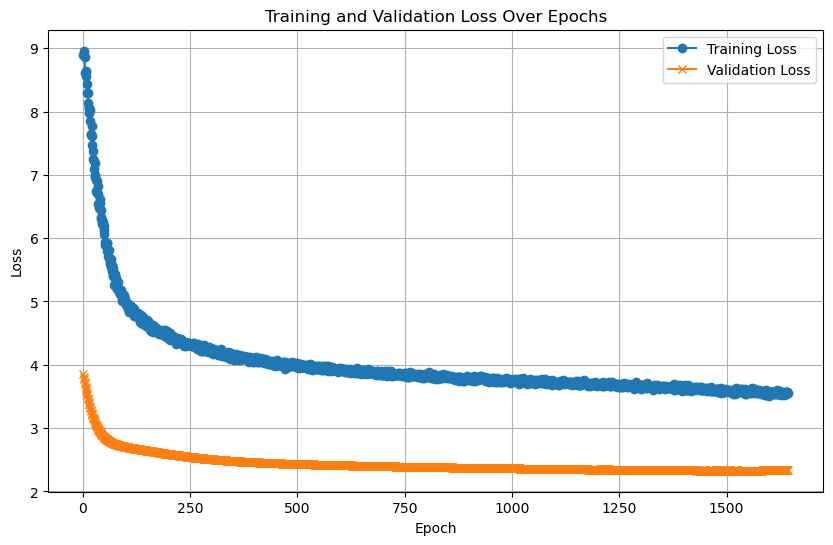

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.6881
Test Batch [20/167], Loss: 4.7147
Test Batch [30/167], Loss: 4.7353
Test Batch [40/167], Loss: 5.0309
Test Batch [50/167], Loss: 4.7748
Test Batch [60/167], Loss: 4.5519
Test Batch [70/167], Loss: 4.5579


Test Batch [80/167], Loss: 5.2029
Test Batch [90/167], Loss: 5.6321
Test Batch [100/167], Loss: 5.3846
Test Batch [110/167], Loss: 5.1347
Test Batch [120/167], Loss: 5.2668
Test Batch [130/167], Loss: 5.1517
Test Batch [140/167], Loss: 5.4001
Test Batch [150/167], Loss: 5.1863
Test Batch [160/167], Loss: 5.7299



Test Loss: 5.0094


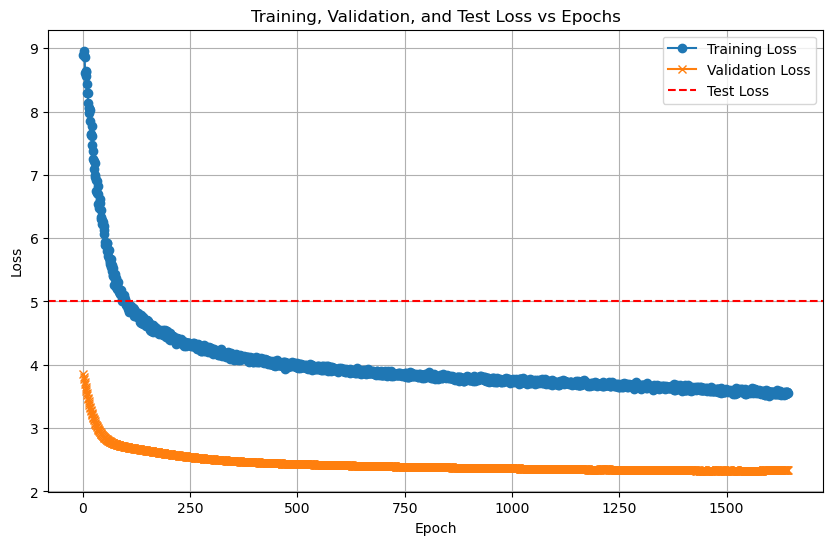

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.


  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.


  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.71      1.00      0.83         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.89      0.87      0.87        45
weighted avg       0.89      0.87      0.87        45


LOG: Evaluating on the test set...
Test Accuracy: 74.59%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1198  |  Val Loss: 2.0864
Validation loss improved from inf to 2.0864.


[Epoch 2/1000] Train Loss: 2.0702  |  Val Loss: 2.0433
Validation loss improved from 2.0864 to 2.0433.


[Epoch 3/1000] Train Loss: 2.0293  |  Val Loss: 2.0022
Validation loss improved from 2.0433 to 2.0022.
[Epoch 4/1000] Train Loss: 1.9877  |  Val Loss: 1.9639
Validation loss improved from 2.0022 to 1.9639.
[Epoch 5/1000] Train Loss: 1.9498  |  Val Loss: 1.9291
Validation loss improved from 1.9639 to 1.9291.
[Epoch 6/1000] Train Loss: 1.9146  |  Val Loss: 1.8963
Validation loss improved from 1.9291 to 1.8963.
[Epoch 7/1000] Train Loss: 1.8809  |  Val Loss: 1.8661
Validation loss improved from 1.8963 to 1.8661.
[Epoch 8/1000] Train Loss: 1.8504  |  Val Loss: 1.8380
Validation loss improved from 1.8661 to 1.8380.
[Epoch 9/1000] Train Loss: 1.8227  |  Val Loss: 1.8126
Validation loss improved from 1.8380 to 1.8126.
[Epoch 10/1000] Train Loss: 1.7960  |  Val Loss: 1.7889
Validation loss improved from 1.8126 to 1.7889.
[Epoch 11/1000] Train Loss: 1.7714  |  Val Loss: 1.7667
Validation loss improved from 1.7889 to 1.7667.
[Epoch 12/1000] Train Loss: 1.7488  |  Val Loss: 1.7461
Validation loss

[Epoch 28/1000] Train Loss: 1.5124  |  Val Loss: 1.5330
Validation loss improved from 1.5431 to 1.5330.
[Epoch 29/1000] Train Loss: 1.5014  |  Val Loss: 1.5229
Validation loss improved from 1.5330 to 1.5229.
[Epoch 30/1000] Train Loss: 1.4908  |  Val Loss: 1.5130
Validation loss improved from 1.5229 to 1.5130.
[Epoch 31/1000] Train Loss: 1.4802  |  Val Loss: 1.5032
Validation loss improved from 1.5130 to 1.5032.
[Epoch 32/1000] Train Loss: 1.4697  |  Val Loss: 1.4937
Validation loss improved from 1.5032 to 1.4937.
[Epoch 33/1000] Train Loss: 1.4592  |  Val Loss: 1.4840
Validation loss improved from 1.4937 to 1.4840.
[Epoch 34/1000] Train Loss: 1.4489  |  Val Loss: 1.4742
Validation loss improved from 1.4840 to 1.4742.


[Epoch 35/1000] Train Loss: 1.4390  |  Val Loss: 1.4647
Validation loss improved from 1.4742 to 1.4647.
[Epoch 36/1000] Train Loss: 1.4290  |  Val Loss: 1.4552
Validation loss improved from 1.4647 to 1.4552.
[Epoch 37/1000] Train Loss: 1.4187  |  Val Loss: 1.4460
Validation loss improved from 1.4552 to 1.4460.
[Epoch 38/1000] Train Loss: 1.4089  |  Val Loss: 1.4369
Validation loss improved from 1.4460 to 1.4369.
[Epoch 39/1000] Train Loss: 1.3997  |  Val Loss: 1.4277
Validation loss improved from 1.4369 to 1.4277.
[Epoch 40/1000] Train Loss: 1.3897  |  Val Loss: 1.4186
Validation loss improved from 1.4277 to 1.4186.
[Epoch 41/1000] Train Loss: 1.3799  |  Val Loss: 1.4094
Validation loss improved from 1.4186 to 1.4094.
[Epoch 42/1000] Train Loss: 1.3700  |  Val Loss: 1.4004
Validation loss improved from 1.4094 to 1.4004.
[Epoch 43/1000] Train Loss: 1.3604  |  Val Loss: 1.3914
Validation loss improved from 1.4004 to 1.3914.
[Epoch 44/1000] Train Loss: 1.3506  |  Val Loss: 1.3824
Validati

[Epoch 60/1000] Train Loss: 1.2071  |  Val Loss: 1.2488
Validation loss improved from 1.2566 to 1.2488.
[Epoch 61/1000] Train Loss: 1.1990  |  Val Loss: 1.2411
Validation loss improved from 1.2488 to 1.2411.
[Epoch 62/1000] Train Loss: 1.1908  |  Val Loss: 1.2335
Validation loss improved from 1.2411 to 1.2335.
[Epoch 63/1000] Train Loss: 1.1827  |  Val Loss: 1.2260
Validation loss improved from 1.2335 to 1.2260.
[Epoch 64/1000] Train Loss: 1.1750  |  Val Loss: 1.2186
Validation loss improved from 1.2260 to 1.2186.
[Epoch 65/1000] Train Loss: 1.1669  |  Val Loss: 1.2113
Validation loss improved from 1.2186 to 1.2113.
[Epoch 66/1000] Train Loss: 1.1589  |  Val Loss: 1.2041
Validation loss improved from 1.2113 to 1.2041.


[Epoch 67/1000] Train Loss: 1.1513  |  Val Loss: 1.1969
Validation loss improved from 1.2041 to 1.1969.
[Epoch 68/1000] Train Loss: 1.1436  |  Val Loss: 1.1898
Validation loss improved from 1.1969 to 1.1898.
[Epoch 69/1000] Train Loss: 1.1362  |  Val Loss: 1.1827
Validation loss improved from 1.1898 to 1.1827.
[Epoch 70/1000] Train Loss: 1.1285  |  Val Loss: 1.1757
Validation loss improved from 1.1827 to 1.1757.
[Epoch 71/1000] Train Loss: 1.1210  |  Val Loss: 1.1687
Validation loss improved from 1.1757 to 1.1687.
[Epoch 72/1000] Train Loss: 1.1136  |  Val Loss: 1.1617
Validation loss improved from 1.1687 to 1.1617.
[Epoch 73/1000] Train Loss: 1.1061  |  Val Loss: 1.1548
Validation loss improved from 1.1617 to 1.1548.
[Epoch 74/1000] Train Loss: 1.0987  |  Val Loss: 1.1477
Validation loss improved from 1.1548 to 1.1477.
[Epoch 75/1000] Train Loss: 1.0912  |  Val Loss: 1.1402
Validation loss improved from 1.1477 to 1.1402.
[Epoch 76/1000] Train Loss: 1.0834  |  Val Loss: 1.1324
Validati

[Epoch 92/1000] Train Loss: 0.9675  |  Val Loss: 1.0233
Validation loss improved from 1.0296 to 1.0233.
[Epoch 93/1000] Train Loss: 0.9608  |  Val Loss: 1.0172
Validation loss improved from 1.0233 to 1.0172.
[Epoch 94/1000] Train Loss: 0.9542  |  Val Loss: 1.0112
Validation loss improved from 1.0172 to 1.0112.
[Epoch 95/1000] Train Loss: 0.9479  |  Val Loss: 1.0052
Validation loss improved from 1.0112 to 1.0052.
[Epoch 96/1000] Train Loss: 0.9414  |  Val Loss: 0.9993
Validation loss improved from 1.0052 to 0.9993.
[Epoch 97/1000] Train Loss: 0.9351  |  Val Loss: 0.9934
Validation loss improved from 0.9993 to 0.9934.
[Epoch 98/1000] Train Loss: 0.9285  |  Val Loss: 0.9876
Validation loss improved from 0.9934 to 0.9876.


[Epoch 99/1000] Train Loss: 0.9224  |  Val Loss: 0.9817
Validation loss improved from 0.9876 to 0.9817.
[Epoch 100/1000] Train Loss: 0.9161  |  Val Loss: 0.9760
Validation loss improved from 0.9817 to 0.9760.
[Epoch 101/1000] Train Loss: 0.9101  |  Val Loss: 0.9702
Validation loss improved from 0.9760 to 0.9702.
[Epoch 102/1000] Train Loss: 0.9038  |  Val Loss: 0.9645
Validation loss improved from 0.9702 to 0.9645.
[Epoch 103/1000] Train Loss: 0.8977  |  Val Loss: 0.9590
Validation loss improved from 0.9645 to 0.9590.
[Epoch 104/1000] Train Loss: 0.8918  |  Val Loss: 0.9534
Validation loss improved from 0.9590 to 0.9534.
[Epoch 105/1000] Train Loss: 0.8854  |  Val Loss: 0.9479
Validation loss improved from 0.9534 to 0.9479.
[Epoch 106/1000] Train Loss: 0.8795  |  Val Loss: 0.9422
Validation loss improved from 0.9479 to 0.9422.
[Epoch 107/1000] Train Loss: 0.8734  |  Val Loss: 0.9367
Validation loss improved from 0.9422 to 0.9367.
[Epoch 108/1000] Train Loss: 0.8673  |  Val Loss: 0.9312

[Epoch 125/1000] Train Loss: 0.7703  |  Val Loss: 0.8429
Validation loss improved from 0.8478 to 0.8429.
[Epoch 126/1000] Train Loss: 0.7649  |  Val Loss: 0.8380
Validation loss improved from 0.8429 to 0.8380.
[Epoch 127/1000] Train Loss: 0.7594  |  Val Loss: 0.8331
Validation loss improved from 0.8380 to 0.8331.
[Epoch 128/1000] Train Loss: 0.7540  |  Val Loss: 0.8282
Validation loss improved from 0.8331 to 0.8282.
[Epoch 129/1000] Train Loss: 0.7488  |  Val Loss: 0.8231
Validation loss improved from 0.8282 to 0.8231.
[Epoch 130/1000] Train Loss: 0.7432  |  Val Loss: 0.8181
Validation loss improved from 0.8231 to 0.8181.
[Epoch 131/1000] Train Loss: 0.7379  |  Val Loss: 0.8132
Validation loss improved from 0.8181 to 0.8132.


[Epoch 132/1000] Train Loss: 0.7326  |  Val Loss: 0.8083
Validation loss improved from 0.8132 to 0.8083.
[Epoch 133/1000] Train Loss: 0.7273  |  Val Loss: 0.8034
Validation loss improved from 0.8083 to 0.8034.
[Epoch 134/1000] Train Loss: 0.7221  |  Val Loss: 0.7986
Validation loss improved from 0.8034 to 0.7986.
[Epoch 135/1000] Train Loss: 0.7170  |  Val Loss: 0.7937
Validation loss improved from 0.7986 to 0.7937.
[Epoch 136/1000] Train Loss: 0.7113  |  Val Loss: 0.7890
Validation loss improved from 0.7937 to 0.7890.
[Epoch 137/1000] Train Loss: 0.7063  |  Val Loss: 0.7843
Validation loss improved from 0.7890 to 0.7843.
[Epoch 138/1000] Train Loss: 0.7012  |  Val Loss: 0.7796
Validation loss improved from 0.7843 to 0.7796.
[Epoch 139/1000] Train Loss: 0.6960  |  Val Loss: 0.7749
Validation loss improved from 0.7796 to 0.7749.
[Epoch 140/1000] Train Loss: 0.6909  |  Val Loss: 0.7702
Validation loss improved from 0.7749 to 0.7702.
[Epoch 141/1000] Train Loss: 0.6859  |  Val Loss: 0.765

[Epoch 156/1000] Train Loss: 0.6118  |  Val Loss: 0.6991
Validation loss improved from 0.7033 to 0.6991.
[Epoch 157/1000] Train Loss: 0.6069  |  Val Loss: 0.6949
Validation loss improved from 0.6991 to 0.6949.
[Epoch 158/1000] Train Loss: 0.6023  |  Val Loss: 0.6908
Validation loss improved from 0.6949 to 0.6908.
[Epoch 159/1000] Train Loss: 0.5979  |  Val Loss: 0.6868
Validation loss improved from 0.6908 to 0.6868.
[Epoch 160/1000] Train Loss: 0.5932  |  Val Loss: 0.6827
Validation loss improved from 0.6868 to 0.6827.
[Epoch 161/1000] Train Loss: 0.5886  |  Val Loss: 0.6787
Validation loss improved from 0.6827 to 0.6787.
[Epoch 162/1000] Train Loss: 0.5840  |  Val Loss: 0.6748
Validation loss improved from 0.6787 to 0.6748.
[Epoch 163/1000] Train Loss: 0.5795  |  Val Loss: 0.6709
Validation loss improved from 0.6748 to 0.6709.
[Epoch 164/1000] Train Loss: 0.5751  |  Val Loss: 0.6670
Validation loss improved from 0.6709 to 0.6670.
[Epoch 165/1000] Train Loss: 0.5708  |  Val Loss: 0.663

[Epoch 166/1000] Train Loss: 0.5664  |  Val Loss: 0.6593
Validation loss improved from 0.6631 to 0.6593.
[Epoch 167/1000] Train Loss: 0.5618  |  Val Loss: 0.6557
Validation loss improved from 0.6593 to 0.6557.
[Epoch 168/1000] Train Loss: 0.5575  |  Val Loss: 0.6520
Validation loss improved from 0.6557 to 0.6520.
[Epoch 169/1000] Train Loss: 0.5535  |  Val Loss: 0.6486
Validation loss improved from 0.6520 to 0.6486.
[Epoch 170/1000] Train Loss: 0.5487  |  Val Loss: 0.6449
Validation loss improved from 0.6486 to 0.6449.
[Epoch 171/1000] Train Loss: 0.5444  |  Val Loss: 0.6412
Validation loss improved from 0.6449 to 0.6412.
[Epoch 172/1000] Train Loss: 0.5400  |  Val Loss: 0.6377
Validation loss improved from 0.6412 to 0.6377.
[Epoch 173/1000] Train Loss: 0.5354  |  Val Loss: 0.6341
Validation loss improved from 0.6377 to 0.6341.
[Epoch 174/1000] Train Loss: 0.5313  |  Val Loss: 0.6305
Validation loss improved from 0.6341 to 0.6305.
[Epoch 175/1000] Train Loss: 0.5272  |  Val Loss: 0.627

[Epoch 189/1000] Train Loss: 0.4739  |  Val Loss: 0.5823
Validation loss improved from 0.5850 to 0.5823.
[Epoch 190/1000] Train Loss: 0.4703  |  Val Loss: 0.5795
Validation loss improved from 0.5823 to 0.5795.
[Epoch 191/1000] Train Loss: 0.4668  |  Val Loss: 0.5767
Validation loss improved from 0.5795 to 0.5767.
[Epoch 192/1000] Train Loss: 0.4634  |  Val Loss: 0.5738
Validation loss improved from 0.5767 to 0.5738.
[Epoch 193/1000] Train Loss: 0.4597  |  Val Loss: 0.5712
Validation loss improved from 0.5738 to 0.5712.
[Epoch 194/1000] Train Loss: 0.4564  |  Val Loss: 0.5685
Validation loss improved from 0.5712 to 0.5685.
[Epoch 195/1000] Train Loss: 0.4528  |  Val Loss: 0.5659
Validation loss improved from 0.5685 to 0.5659.
[Epoch 196/1000] Train Loss: 0.4499  |  Val Loss: 0.5629
Validation loss improved from 0.5659 to 0.5629.
[Epoch 197/1000] Train Loss: 0.4464  |  Val Loss: 0.5603
Validation loss improved from 0.5629 to 0.5603.


[Epoch 198/1000] Train Loss: 0.4432  |  Val Loss: 0.5580
Validation loss improved from 0.5603 to 0.5580.
[Epoch 199/1000] Train Loss: 0.4397  |  Val Loss: 0.5553
Validation loss improved from 0.5580 to 0.5553.
[Epoch 200/1000] Train Loss: 0.4365  |  Val Loss: 0.5527
Validation loss improved from 0.5553 to 0.5527.
[Epoch 201/1000] Train Loss: 0.4336  |  Val Loss: 0.5502
Validation loss improved from 0.5527 to 0.5502.
[Epoch 202/1000] Train Loss: 0.4302  |  Val Loss: 0.5474
Validation loss improved from 0.5502 to 0.5474.
[Epoch 203/1000] Train Loss: 0.4271  |  Val Loss: 0.5449
Validation loss improved from 0.5474 to 0.5449.
[Epoch 204/1000] Train Loss: 0.4239  |  Val Loss: 0.5423
Validation loss improved from 0.5449 to 0.5423.
[Epoch 205/1000] Train Loss: 0.4209  |  Val Loss: 0.5398
Validation loss improved from 0.5423 to 0.5398.
[Epoch 206/1000] Train Loss: 0.4178  |  Val Loss: 0.5374
Validation loss improved from 0.5398 to 0.5374.
[Epoch 207/1000] Train Loss: 0.4151  |  Val Loss: 0.535

[Epoch 221/1000] Train Loss: 0.3765  |  Val Loss: 0.5067
Validation loss improved from 0.5083 to 0.5067.
[Epoch 222/1000] Train Loss: 0.3738  |  Val Loss: 0.5049
Validation loss improved from 0.5067 to 0.5049.
[Epoch 223/1000] Train Loss: 0.3713  |  Val Loss: 0.5030
Validation loss improved from 0.5049 to 0.5030.
[Epoch 224/1000] Train Loss: 0.3686  |  Val Loss: 0.5012
Validation loss improved from 0.5030 to 0.5012.
[Epoch 225/1000] Train Loss: 0.3665  |  Val Loss: 0.4991
Validation loss improved from 0.5012 to 0.4991.
[Epoch 226/1000] Train Loss: 0.3639  |  Val Loss: 0.4976
Validation loss improved from 0.4991 to 0.4976.
[Epoch 227/1000] Train Loss: 0.3614  |  Val Loss: 0.4961
Validation loss improved from 0.4976 to 0.4961.
[Epoch 228/1000] Train Loss: 0.3590  |  Val Loss: 0.4945
Validation loss improved from 0.4961 to 0.4945.


[Epoch 229/1000] Train Loss: 0.3566  |  Val Loss: 0.4929
Validation loss improved from 0.4945 to 0.4929.
[Epoch 230/1000] Train Loss: 0.3544  |  Val Loss: 0.4916
Validation loss improved from 0.4929 to 0.4916.
[Epoch 231/1000] Train Loss: 0.3521  |  Val Loss: 0.4901
Validation loss improved from 0.4916 to 0.4901.
[Epoch 232/1000] Train Loss: 0.3498  |  Val Loss: 0.4887
Validation loss improved from 0.4901 to 0.4887.
[Epoch 233/1000] Train Loss: 0.3476  |  Val Loss: 0.4874
Validation loss improved from 0.4887 to 0.4874.
[Epoch 234/1000] Train Loss: 0.3454  |  Val Loss: 0.4860
Validation loss improved from 0.4874 to 0.4860.
[Epoch 235/1000] Train Loss: 0.3433  |  Val Loss: 0.4843
Validation loss improved from 0.4860 to 0.4843.
[Epoch 236/1000] Train Loss: 0.3412  |  Val Loss: 0.4830
Validation loss improved from 0.4843 to 0.4830.
[Epoch 237/1000] Train Loss: 0.3390  |  Val Loss: 0.4816
Validation loss improved from 0.4830 to 0.4816.
[Epoch 238/1000] Train Loss: 0.3367  |  Val Loss: 0.480

[Epoch 251/1000] Train Loss: 0.3119  |  Val Loss: 0.4642
Validation loss improved from 0.4655 to 0.4642.
[Epoch 252/1000] Train Loss: 0.3103  |  Val Loss: 0.4634
Validation loss improved from 0.4642 to 0.4634.
[Epoch 253/1000] Train Loss: 0.3084  |  Val Loss: 0.4624
Validation loss improved from 0.4634 to 0.4624.
[Epoch 254/1000] Train Loss: 0.3068  |  Val Loss: 0.4616
Validation loss improved from 0.4624 to 0.4616.
[Epoch 255/1000] Train Loss: 0.3051  |  Val Loss: 0.4609
Validation loss improved from 0.4616 to 0.4609.
[Epoch 256/1000] Train Loss: 0.3034  |  Val Loss: 0.4597
Validation loss improved from 0.4609 to 0.4597.
[Epoch 257/1000] Train Loss: 0.3018  |  Val Loss: 0.4587
Validation loss improved from 0.4597 to 0.4587.
[Epoch 258/1000] Train Loss: 0.3001  |  Val Loss: 0.4574
Validation loss improved from 0.4587 to 0.4574.
[Epoch 259/1000] Train Loss: 0.2985  |  Val Loss: 0.4564
Validation loss improved from 0.4574 to 0.4564.
[Epoch 260/1000] Train Loss: 0.2970  |  Val Loss: 0.455

[Epoch 263/1000] Train Loss: 0.2922  |  Val Loss: 0.4526
Validation loss improved from 0.4534 to 0.4526.
[Epoch 264/1000] Train Loss: 0.2908  |  Val Loss: 0.4520
Validation loss improved from 0.4526 to 0.4520.
[Epoch 265/1000] Train Loss: 0.2892  |  Val Loss: 0.4513
Validation loss improved from 0.4520 to 0.4513.
[Epoch 266/1000] Train Loss: 0.2877  |  Val Loss: 0.4508
Validation loss improved from 0.4513 to 0.4508.
[Epoch 267/1000] Train Loss: 0.2863  |  Val Loss: 0.4500
Validation loss improved from 0.4508 to 0.4500.
[Epoch 268/1000] Train Loss: 0.2848  |  Val Loss: 0.4492
Validation loss improved from 0.4500 to 0.4492.
[Epoch 269/1000] Train Loss: 0.2834  |  Val Loss: 0.4487
Validation loss improved from 0.4492 to 0.4487.
[Epoch 270/1000] Train Loss: 0.2820  |  Val Loss: 0.4479
Validation loss improved from 0.4487 to 0.4479.
[Epoch 271/1000] Train Loss: 0.2807  |  Val Loss: 0.4469
Validation loss improved from 0.4479 to 0.4469.
[Epoch 272/1000] Train Loss: 0.2791  |  Val Loss: 0.446

[Epoch 285/1000] Train Loss: 0.2622  |  Val Loss: 0.4391
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.2613  |  Val Loss: 0.4394
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 287/1000] Train Loss: 0.2599  |  Val Loss: 0.4386
Validation loss improved from 0.4386 to 0.4386.
[Epoch 288/1000] Train Loss: 0.2587  |  Val Loss: 0.4384
Validation loss improved from 0.4386 to 0.4384.
[Epoch 289/1000] Train Loss: 0.2575  |  Val Loss: 0.4378
Validation loss improved from 0.4384 to 0.4378.
[Epoch 290/1000] Train Loss: 0.2563  |  Val Loss: 0.4372
Validation loss improved from 0.4378 to 0.4372.
[Epoch 291/1000] Train Loss: 0.2552  |  Val Loss: 0.4362
Validation loss improved from 0.4372 to 0.4362.
[Epoch 292/1000] Train Loss: 0.2540  |  Val Loss: 0.4353
Validation loss improved from 0.4362 to 0.4353.
[Epoch 293/1000] Train Loss: 0.2529  |  Val Loss: 0.4344
Validation loss improved from 0.4353 to 0.4344.
[Epoch 294/1000] Train Loss: 0.2520  |  Val

[Epoch 296/1000] Train Loss: 0.2497  |  Val Loss: 0.4343
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 297/1000] Train Loss: 0.2487  |  Val Loss: 0.4344
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 298/1000] Train Loss: 0.2475  |  Val Loss: 0.4338
Validation loss improved from 0.4339 to 0.4338.
[Epoch 299/1000] Train Loss: 0.2465  |  Val Loss: 0.4338
Validation loss improved from 0.4338 to 0.4338.
[Epoch 300/1000] Train Loss: 0.2454  |  Val Loss: 0.4329
Validation loss improved from 0.4338 to 0.4329.
[Epoch 301/1000] Train Loss: 0.2443  |  Val Loss: 0.4325
Validation loss improved from 0.4329 to 0.4325.
[Epoch 302/1000] Train Loss: 0.2434  |  Val Loss: 0.4319
Validation loss improved from 0.4325 to 0.4319.
[Epoch 303/1000] Train Loss: 0.2425  |  Val Loss: 0.4323
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 304/1000] Train Loss: 0.2415  |  Val Loss: 0.4322
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 305/1000] Train Loss: 0.

[Epoch 317/1000] Train Loss: 0.2292  |  Val Loss: 0.4303
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 318/1000] Train Loss: 0.2284  |  Val Loss: 0.4300
Validation loss improved from 0.4301 to 0.4300.
[Epoch 319/1000] Train Loss: 0.2274  |  Val Loss: 0.4293
Validation loss improved from 0.4300 to 0.4293.
[Epoch 320/1000] Train Loss: 0.2267  |  Val Loss: 0.4292
Validation loss improved from 0.4293 to 0.4292.
[Epoch 321/1000] Train Loss: 0.2259  |  Val Loss: 0.4287
Validation loss improved from 0.4292 to 0.4287.
[Epoch 322/1000] Train Loss: 0.2250  |  Val Loss: 0.4281
Validation loss improved from 0.4287 to 0.4281.
[Epoch 323/1000] Train Loss: 0.2241  |  Val Loss: 0.4282
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Train Loss: 0.2232  |  Val Loss: 0.4286
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 325/1000] Train Loss: 0.2224  |  Val Loss: 0.4291
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 326/1000] Train Loss: 0.

[Epoch 329/1000] Train Loss: 0.2193  |  Val Loss: 0.4292
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 330/1000] Train Loss: 0.2185  |  Val Loss: 0.4287
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 331/1000] Train Loss: 0.2176  |  Val Loss: 0.4285
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 332/1000] Train Loss: 0.2168  |  Val Loss: 0.4283
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 333/1000] Train Loss: 0.2161  |  Val Loss: 0.4277
Validation loss improved from 0.4281 to 0.4277.
[Epoch 334/1000] Train Loss: 0.2152  |  Val Loss: 0.4276
Validation loss improved from 0.4277 to 0.4276.
[Epoch 335/1000] Train Loss: 0.2145  |  Val Loss: 0.4279
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 336/1000] Train Loss: 0.2137  |  Val Loss: 0.4280
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 337/1000] Train Loss: 0.2129  |  Val Loss: 0.4284
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 338/1

[Epoch 349/1000] Train Loss: 0.2035  |  Val Loss: 0.4262
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 350/1000] Train Loss: 0.2029  |  Val Loss: 0.4266
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 351/1000] Train Loss: 0.2021  |  Val Loss: 0.4257
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 352/1000] Train Loss: 0.2014  |  Val Loss: 0.4256
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 353/1000] Train Loss: 0.2008  |  Val Loss: 0.4248
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 354/1000] Train Loss: 0.2001  |  Val Loss: 0.4249
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 355/1000] Train Loss: 0.1996  |  Val Loss: 0.4243
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 356/1000] Train Loss: 0.1989  |  Val Loss: 0.4250
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 357/1000] Train Loss: 0.1983  |  Val Loss: 0.4255
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 359/1000] Train Loss: 0.1970  |  Val Loss: 0.4248
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 360/1000] Train Loss: 0.1964  |  Val Loss: 0.4256
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 361/1000] Train Loss: 0.1957  |  Val Loss: 0.4257
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 362/1000] Train Loss: 0.1950  |  Val Loss: 0.4258
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 363/1000] Train Loss: 0.1944  |  Val Loss: 0.4263
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 364/1000] Train Loss: 0.1939  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 365/1000] Train Loss: 0.1933  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 366/1000] Train Loss: 0.1926  |  Val Loss: 0.4270
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 367/1000] Train Loss: 0.1922  |  Val Loss: 0.4281
!! Validation loss did NOT improve !! Patience:

[Epoch 379/1000] Train Loss: 0.1853  |  Val Loss: 0.4311
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 380/1000] Train Loss: 0.1848  |  Val Loss: 0.4297
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 381/1000] Train Loss: 0.1845  |  Val Loss: 0.4286
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 382/1000] Train Loss: 0.1838  |  Val Loss: 0.4289
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 383/1000] Train Loss: 0.1833  |  Val Loss: 0.4295
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 384/1000] Train Loss: 0.1827  |  Val Loss: 0.4294
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 385/1000] Train Loss: 0.1821  |  Val Loss: 0.4297
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 386/1000] Train Loss: 0.1816  |  Val Loss: 0.4301
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 387/1000] Train Loss: 0.1812  |  Val Loss: 0.4312
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 388/1000] Train Loss: 0.1807  |  Val Loss: 0.4319
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 389/1000] Train Loss: 0.1801  |  Val Loss: 0.4317
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 390/1000] Train Loss: 0.1796  |  Val Loss: 0.4311
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 391/1000] Train Loss: 0.1791  |  Val Loss: 0.4323
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 392/1000] Train Loss: 0.1785  |  Val Loss: 0.4326
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 393/1000] Train Loss: 0.1782  |  Val Loss: 0.4317
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 394/1000] Train Loss: 0.1777  |  Val Loss: 0.4315
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 395/1000] Train Loss: 0.1769  |  Val Loss: 0.4328
!! Validation loss did NOT improve !! Patience:

[Epoch 411/1000] Train Loss: 0.1696  |  Val Loss: 0.4383
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 412/1000] Train Loss: 0.1691  |  Val Loss: 0.4385
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 413/1000] Train Loss: 0.1687  |  Val Loss: 0.4391
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 414/1000] Train Loss: 0.1682  |  Val Loss: 0.4382
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 415/1000] Train Loss: 0.1677  |  Val Loss: 0.4382
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 416/1000] Train Loss: 0.1673  |  Val Loss: 0.4396
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 417/1000] Train Loss: 0.1670  |  Val Loss: 0.4406
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 418/1000] Train Loss: 0.1666  |  Val Loss: 0.4408
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 419/1000] Train Loss: 0.1661  |  Val Loss: 0.4412
!! Validation loss did NOT improve !! Patience:

[Epoch 420/1000] Train Loss: 0.1659  |  Val Loss: 0.4404
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 421/1000] Train Loss: 0.1653  |  Val Loss: 0.4404
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 422/1000] Train Loss: 0.1647  |  Val Loss: 0.4414
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 423/1000] Train Loss: 0.1645  |  Val Loss: 0.4426
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 424/1000] Train Loss: 0.1641  |  Val Loss: 0.4430
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 425/1000] Train Loss: 0.1637  |  Val Loss: 0.4436
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 426/1000] Train Loss: 0.1632  |  Val Loss: 0.4449
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 427/1000] Train Loss: 0.1627  |  Val Loss: 0.4452
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 428/1000] Train Loss: 0.1623  |  Val Loss: 0.4447
!! Validation loss did NOT improve !! Patience:

[Epoch 445/1000] Train Loss: 0.1559  |  Val Loss: 0.4504
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 445 !!
No improvement for 100 epochs.


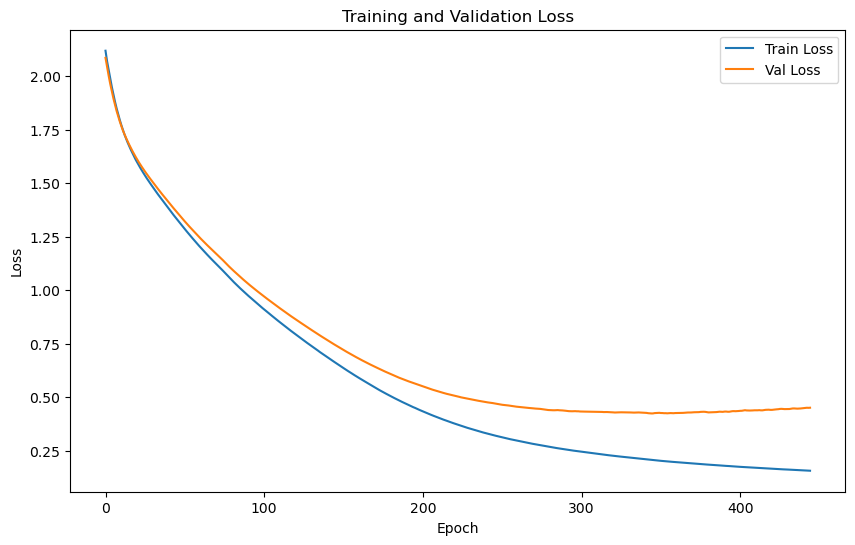

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8190 | Test Accuracy: 74.32%


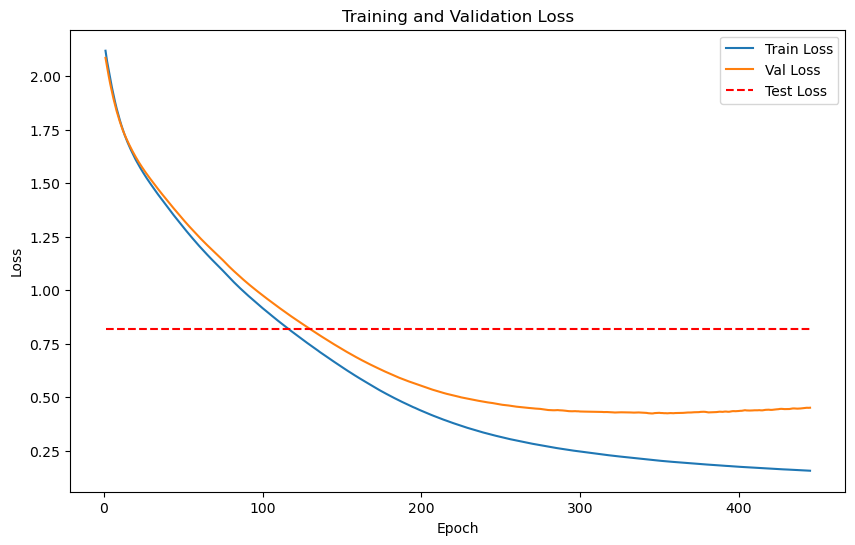

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [1/2000] - Validation


    Batch [1/1], Val Loss: 0.4484
Epoch [1/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4484

Validation loss improved from inf to 0.4484. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4461
Epoch [2/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4461

Validation loss improved from 0.4484 to 0.4461. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4437
Epoch [3/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.4437

Validation loss improved from 0.4461 to 0.4437. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4420
Epoch [4/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.4420

Validation loss improved from 0.4437 to 0.4420. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4401
Epoch [5/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4401

Validation loss improved from 0.4420 to 0.4401. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.4385
Epoch [6/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4385

Validation loss improved from 0.4401 to 0.4385. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4368
Epoch [7/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4368

Validation loss improved from 0.4385 to 0.4368. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.4347
Epoch [8/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4347

Validation loss improved from 0.4368 to 0.4347. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4327
Epoch [9/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4327

Validation loss improved from 0.4347 to 0.4327. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.4311
Epoch [10/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4311

Validation loss improved from 0.4327 to 0.4311. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4295
Epoch [11/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4295

Validation loss improved from 0.4311 to 0.4295. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4280
Epoch [12/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4280

Validation loss improved from 0.4295 to 0.4280. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4265
Epoch [13/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4265

Validation loss improved from 0.4280 to 0.4265. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4251
Epoch [14/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4251

Validation loss improved from 0.4265 to 0.4251. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.4238
Epoch [15/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4238

Validation loss improved from 0.4251 to 0.4238. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4226
Epoch [16/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4226

Validation loss improved from 0.4238 to 0.4226. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [17/2000] - Validation


    Batch [1/1], Val Loss: 0.4213
Epoch [17/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4213

Validation loss improved from 0.4226 to 0.4213. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4203
Epoch [18/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4203

Validation loss improved from 0.4213 to 0.4203. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4195
Epoch [19/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4195

Validation loss improved from 0.4203 to 0.4195. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4186
Epoch [20/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4186

Validation loss improved from 0.4195 to 0.4186. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4176
Epoch [21/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4176

Validation loss improved from 0.4186 to 0.4176. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4167
Epoch [22/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4167

Validation loss improved from 0.4176 to 0.4167. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4159
Epoch [23/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4159

Validation loss improved from 0.4167 to 0.4159. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4150
Epoch [24/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4150

Validation loss improved from 0.4159 to 0.4150. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4141
Epoch [25/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.4141

Validation loss improved from 0.4150 to 0.4141. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4134
Epoch [26/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4134

Validation loss improved from 0.4141 to 0.4134. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.4126
Epoch [27/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4126

Validation loss improved from 0.4134 to 0.4126. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4118
Epoch [28/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.4118

Validation loss improved from 0.4126 to 0.4118. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.4111
Epoch [29/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4111

Validation loss improved from 0.4118 to 0.4111. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4105
Epoch [30/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4105

Validation loss improved from 0.4111 to 0.4105. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4098
Epoch [31/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4098

Validation loss improved from 0.4105 to 0.4098. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4092
Epoch [32/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.4092

Validation loss improved from 0.4098 to 0.4092. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4085
Epoch [33/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.4085

Validation loss improved from 0.4092 to 0.4085. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4079
Epoch [34/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.4079

Validation loss improved from 0.4085 to 0.4079. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [35/2000] - Validation


    Batch [1/1], Val Loss: 0.4072
Epoch [35/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4072

Validation loss improved from 0.4079 to 0.4072. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [36/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.4066

Validation loss improved from 0.4072 to 0.4066. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.4059
Epoch [37/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4059

Validation loss improved from 0.4066 to 0.4059. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4053
Epoch [38/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4053

Validation loss improved from 0.4059 to 0.4053. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.4047
Epoch [39/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.4047

Validation loss improved from 0.4053 to 0.4047. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4040
Epoch [40/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4040

Validation loss improved from 0.4047 to 0.4040. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.4034
Epoch [41/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.4034

Validation loss improved from 0.4040 to 0.4034. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [42/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.4028

Validation loss improved from 0.4034 to 0.4028. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.4022
Epoch [43/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4022

Validation loss improved from 0.4028 to 0.4022. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.4016
Epoch [44/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.4016

Validation loss improved from 0.4022 to 0.4016. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.4009
Epoch [45/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.4009

Validation loss improved from 0.4016 to 0.4009. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4003
Epoch [46/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.4003

Validation loss improved from 0.4009 to 0.4003. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3997
Epoch [47/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3997

Validation loss improved from 0.4003 to 0.3997. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3991
Epoch [48/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3991

Validation loss improved from 0.3997 to 0.3991. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3986
Epoch [49/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3986

Validation loss improved from 0.3991 to 0.3986. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3979
Epoch [50/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3979

Validation loss improved from 0.3986 to 0.3979. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3973
Epoch [51/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3973

Validation loss improved from 0.3979 to 0.3973. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3967
Epoch [52/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3967

Validation loss improved from 0.3973 to 0.3967. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3961
Epoch [53/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3961

Validation loss improved from 0.3967 to 0.3961. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3954
Epoch [54/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3954

Validation loss improved from 0.3961 to 0.3954. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [55/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3948

Validation loss improved from 0.3954 to 0.3948. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3942
Epoch [56/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3942

Validation loss improved from 0.3948 to 0.3942. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3936
Epoch [57/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.3936

Validation loss improved from 0.3942 to 0.3936. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [58/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.3930

Validation loss improved from 0.3936 to 0.3930. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [59/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3924

Validation loss improved from 0.3930 to 0.3924. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.3918
Epoch [60/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3918

Validation loss improved from 0.3924 to 0.3918. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3911
Epoch [61/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3911

Validation loss improved from 0.3918 to 0.3911. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [62/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3905

Validation loss improved from 0.3911 to 0.3905. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3898
Epoch [63/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3898

Validation loss improved from 0.3905 to 0.3898. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [64/2000] - Validation


    Batch [1/1], Val Loss: 0.3891
Epoch [64/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3891

Validation loss improved from 0.3898 to 0.3891. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [65/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3884

Validation loss improved from 0.3891 to 0.3884. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [66/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3878

Validation loss improved from 0.3884 to 0.3878. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [67/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3872

Validation loss improved from 0.3878 to 0.3872. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3866
Epoch [68/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3866

Validation loss improved from 0.3872 to 0.3866. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [69/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3860

Validation loss improved from 0.3866 to 0.3860. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [70/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3854

Validation loss improved from 0.3860 to 0.3854. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [71/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3848

Validation loss improved from 0.3854 to 0.3848. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3842
Epoch [72/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3842

Validation loss improved from 0.3848 to 0.3842. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3835
Epoch [73/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3835

Validation loss improved from 0.3842 to 0.3835. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3829
Epoch [74/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3829

Validation loss improved from 0.3835 to 0.3829. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [75/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3824

Validation loss improved from 0.3829 to 0.3824. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3819
Epoch [76/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3819

Validation loss improved from 0.3824 to 0.3819. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [77/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3813

Validation loss improved from 0.3819 to 0.3813. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [78/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.3808

Validation loss improved from 0.3813 to 0.3808. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [79/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3803

Validation loss improved from 0.3808 to 0.3803. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [80/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3798

Validation loss improved from 0.3803 to 0.3798. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3793
Epoch [81/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3793

Validation loss improved from 0.3798 to 0.3793. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [82/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3789

Validation loss improved from 0.3793 to 0.3789. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.3784
Epoch [83/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.3784

Validation loss improved from 0.3789 to 0.3784. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [84/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3779

Validation loss improved from 0.3784 to 0.3779. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [85/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3774

Validation loss improved from 0.3779 to 0.3774. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [86/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3769

Validation loss improved from 0.3774 to 0.3769. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3764
Epoch [87/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3764

Validation loss improved from 0.3769 to 0.3764. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [88/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3759

Validation loss improved from 0.3764 to 0.3759. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3754
Epoch [89/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3754

Validation loss improved from 0.3759 to 0.3754. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [90/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3749

Validation loss improved from 0.3754 to 0.3749. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [91/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3744

Validation loss improved from 0.3749 to 0.3744. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [92/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3739

Validation loss improved from 0.3744 to 0.3739. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [93/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3735

Validation loss improved from 0.3739 to 0.3735. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [94/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3730

Validation loss improved from 0.3735 to 0.3730. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3725
Epoch [95/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3725

Validation loss improved from 0.3730 to 0.3725. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3720
Epoch [96/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3720

Validation loss improved from 0.3725 to 0.3720. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [97/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3715

Validation loss improved from 0.3720 to 0.3715. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [98/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3710

Validation loss improved from 0.3715 to 0.3710. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3705
Epoch [99/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3705

Validation loss improved from 0.3710 to 0.3705. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [100/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3700

Validation loss improved from 0.3705 to 0.3700. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [101/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3695

Validation loss improved from 0.3700 to 0.3695. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [102/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3690

Validation loss improved from 0.3695 to 0.3690. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3686
Epoch [103/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3686

Validation loss improved from 0.3690 to 0.3686. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [104/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3682

Validation loss improved from 0.3686 to 0.3682. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [105/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3678

Validation loss improved from 0.3682 to 0.3678. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.3674
Epoch [106/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3674

Validation loss improved from 0.3678 to 0.3674. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [107/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3670

Validation loss improved from 0.3674 to 0.3670. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3666
Epoch [108/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3666

Validation loss improved from 0.3670 to 0.3666. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [109/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3662

Validation loss improved from 0.3666 to 0.3662. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [110/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3658

Validation loss improved from 0.3662 to 0.3658. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [111/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3654

Validation loss improved from 0.3658 to 0.3654. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [112/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3650

Validation loss improved from 0.3654 to 0.3650. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [113/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3645

Validation loss improved from 0.3650 to 0.3645. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.3641
Epoch [114/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3641

Validation loss improved from 0.3645 to 0.3641. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [115/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3637

Validation loss improved from 0.3641 to 0.3637. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [116/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3633

Validation loss improved from 0.3637 to 0.3633. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [117/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3629

Validation loss improved from 0.3633 to 0.3629. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [118/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3625

Validation loss improved from 0.3629 to 0.3625. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [119/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3621

Validation loss improved from 0.3625 to 0.3621. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [120/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3617

Validation loss improved from 0.3621 to 0.3617. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [121/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3613

Validation loss improved from 0.3617 to 0.3613. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.3609
Epoch [122/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3609

Validation loss improved from 0.3613 to 0.3609. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3605
Epoch [123/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3605

Validation loss improved from 0.3609 to 0.3605. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [124/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3601

Validation loss improved from 0.3605 to 0.3601. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [125/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3598

Validation loss improved from 0.3601 to 0.3598. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [126/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3594

Validation loss improved from 0.3598 to 0.3594. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [127/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3590

Validation loss improved from 0.3594 to 0.3590. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [128/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3587

Validation loss improved from 0.3590 to 0.3587. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [129/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3584

Validation loss improved from 0.3587 to 0.3584. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [130/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3581

Validation loss improved from 0.3584 to 0.3581. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [131/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3578

Validation loss improved from 0.3581 to 0.3578. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.3575
Epoch [132/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3575

Validation loss improved from 0.3578 to 0.3575. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [133/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3571

Validation loss improved from 0.3575 to 0.3571. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3568
Epoch [134/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3568

Validation loss improved from 0.3571 to 0.3568. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [135/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3565

Validation loss improved from 0.3568 to 0.3565. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [136/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3563

Validation loss improved from 0.3565 to 0.3563. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [137/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3560

Validation loss improved from 0.3563 to 0.3560. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [138/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3557

Validation loss improved from 0.3560 to 0.3557. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.3555
Epoch [139/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3555

Validation loss improved from 0.3557 to 0.3555. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3552
Epoch [140/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3552

Validation loss improved from 0.3555 to 0.3552. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [141/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3550

Validation loss improved from 0.3552 to 0.3550. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [142/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3548

Validation loss improved from 0.3550 to 0.3548. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [143/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3546

Validation loss improved from 0.3548 to 0.3546. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [144/2000] - Validation


    Batch [1/1], Val Loss: 0.3543
Epoch [144/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3543

Validation loss improved from 0.3546 to 0.3543. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3541
Epoch [145/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3541

Validation loss improved from 0.3543 to 0.3541. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [146/2000] - Validation


    Batch [1/1], Val Loss: 0.3539
Epoch [146/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3539

Validation loss improved from 0.3541 to 0.3539. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [147/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.3536

Validation loss improved from 0.3539 to 0.3536. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [148/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3534

Validation loss improved from 0.3536 to 0.3534. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [149/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3531

Validation loss improved from 0.3534 to 0.3531. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [150/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3529

Validation loss improved from 0.3531 to 0.3529. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3527
Epoch [151/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3527

Validation loss improved from 0.3529 to 0.3527. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3525
Epoch [152/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3525

Validation loss improved from 0.3527 to 0.3525. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.3522
Epoch [153/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3522

Validation loss improved from 0.3525 to 0.3522. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [154/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3520

Validation loss improved from 0.3522 to 0.3520. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [155/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3517

Validation loss improved from 0.3520 to 0.3517. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [156/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3515

Validation loss improved from 0.3517 to 0.3515. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [157/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3512

Validation loss improved from 0.3515 to 0.3512. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.3510
Epoch [158/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3510

Validation loss improved from 0.3512 to 0.3510. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [159/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3507

Validation loss improved from 0.3510 to 0.3507. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [160/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3504

Validation loss improved from 0.3507 to 0.3504. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [161/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3501

Validation loss improved from 0.3504 to 0.3501. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [162/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3498

Validation loss improved from 0.3501 to 0.3498. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [163/2000] - Validation


    Batch [1/1], Val Loss: 0.3496
Epoch [163/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3496

Validation loss improved from 0.3498 to 0.3496. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3493
Epoch [164/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3493

Validation loss improved from 0.3496 to 0.3493. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [165/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3490

Validation loss improved from 0.3493 to 0.3490. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3488
Epoch [166/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3488

Validation loss improved from 0.3490 to 0.3488. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [167/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3486

Validation loss improved from 0.3488 to 0.3486. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3484
Epoch [168/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3484

Validation loss improved from 0.3486 to 0.3484. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [169/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3482

Validation loss improved from 0.3484 to 0.3482. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [170/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3481

Validation loss improved from 0.3482 to 0.3481. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [171/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3478

Validation loss improved from 0.3481 to 0.3478. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [172/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.3476

Validation loss improved from 0.3478 to 0.3476. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [173/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3473

Validation loss improved from 0.3476 to 0.3473. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [174/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3471

Validation loss improved from 0.3473 to 0.3471. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [175/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3469

Validation loss improved from 0.3471 to 0.3469. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.3466
Epoch [176/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3466

Validation loss improved from 0.3469 to 0.3466. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [177/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3464

Validation loss improved from 0.3466 to 0.3464. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [178/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3461

Validation loss improved from 0.3464 to 0.3461. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [179/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3458

Validation loss improved from 0.3461 to 0.3458. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [180/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3455

Validation loss improved from 0.3458 to 0.3455. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3453
Epoch [181/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3453

Validation loss improved from 0.3455 to 0.3453. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [182/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3450

Validation loss improved from 0.3453 to 0.3450. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.3448
Epoch [183/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3448

Validation loss improved from 0.3450 to 0.3448. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [184/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3445

Validation loss improved from 0.3448 to 0.3445. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [185/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3443

Validation loss improved from 0.3445 to 0.3443. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [186/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3441

Validation loss improved from 0.3443 to 0.3441. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [187/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3439

Validation loss improved from 0.3441 to 0.3439. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3437
Epoch [188/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3437

Validation loss improved from 0.3439 to 0.3437. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [189/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3435

Validation loss improved from 0.3437 to 0.3435. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [190/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3433

Validation loss improved from 0.3435 to 0.3433. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [191/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3431

Validation loss improved from 0.3433 to 0.3431. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [192/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3430

Validation loss improved from 0.3431 to 0.3430. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [193/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3428

Validation loss improved from 0.3430 to 0.3428. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3426
Epoch [194/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3426

Validation loss improved from 0.3428 to 0.3426. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3425
Epoch [195/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3425

Validation loss improved from 0.3426 to 0.3425. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [196/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3423

Validation loss improved from 0.3425 to 0.3423. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [197/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3422

Validation loss improved from 0.3423 to 0.3422. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [198/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.3420

Validation loss improved from 0.3422 to 0.3420. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [199/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3419

Validation loss improved from 0.3420 to 0.3419. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.3417
Epoch [200/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3417

Validation loss improved from 0.3419 to 0.3417. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [201/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.3416

Validation loss improved from 0.3417 to 0.3416. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3414
Epoch [202/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3414

Validation loss improved from 0.3416 to 0.3414. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [203/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3413

Validation loss improved from 0.3414 to 0.3413. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [204/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3411

Validation loss improved from 0.3413 to 0.3411. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [205/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3410

Validation loss improved from 0.3411 to 0.3410. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [206/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3408

Validation loss improved from 0.3410 to 0.3408. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [207/2000] - Validation


    Batch [1/1], Val Loss: 0.3407
Epoch [207/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3407

Validation loss improved from 0.3408 to 0.3407. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [208/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3405

Validation loss improved from 0.3407 to 0.3405. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [209/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3403

Validation loss improved from 0.3405 to 0.3403. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [210/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3401

Validation loss improved from 0.3403 to 0.3401. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [211/2000] - Validation


    Batch [1/1], Val Loss: 0.3399
Epoch [211/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3399

Validation loss improved from 0.3401 to 0.3399. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [212/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.3398

Validation loss improved from 0.3399 to 0.3398. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3396
Epoch [213/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.3396

Validation loss improved from 0.3398 to 0.3396. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [214/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.3394

Validation loss improved from 0.3396 to 0.3394. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [215/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3393

Validation loss improved from 0.3394 to 0.3393. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [216/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3392

Validation loss improved from 0.3393 to 0.3392. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [217/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.3390

Validation loss improved from 0.3392 to 0.3390. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [218/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3389

Validation loss improved from 0.3390 to 0.3389. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [219/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.3388

Validation loss improved from 0.3389 to 0.3388. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [220/2000] - Validation


    Batch [1/1], Val Loss: 0.3387
Epoch [220/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.3387

Validation loss improved from 0.3388 to 0.3387. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [221/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.3386

Validation loss improved from 0.3387 to 0.3386. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [222/2000] - Validation


    Batch [1/1], Val Loss: 0.3386
Epoch [222/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3386

Validation loss improved from 0.3386 to 0.3386. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3520
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [223/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.3385

Validation loss improved from 0.3386 to 0.3385. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [224/2000] - Validation


    Batch [1/1], Val Loss: 0.3384
Epoch [224/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3384

Validation loss improved from 0.3385 to 0.3384. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [225/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3383

Validation loss improved from 0.3384 to 0.3383. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [226/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.3382

Validation loss improved from 0.3383 to 0.3382. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [227/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3381

Validation loss improved from 0.3382 to 0.3381. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.3380
Epoch [228/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [229/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3379

Validation loss improved from 0.3380 to 0.3379. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.3379
Epoch [230/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3379

Validation loss improved from 0.3379 to 0.3379. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [231/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.3378

Validation loss improved from 0.3379 to 0.3378. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.3377
Epoch [232/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3377

Validation loss improved from 0.3378 to 0.3377. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [233/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.3375

Validation loss improved from 0.3377 to 0.3375. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [234/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3373

Validation loss improved from 0.3375 to 0.3373. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [235/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.3372

Validation loss improved from 0.3373 to 0.3372. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [236/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3370

Validation loss improved from 0.3372 to 0.3370. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [237/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3369

Validation loss improved from 0.3370 to 0.3369. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [238/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3368

Validation loss improved from 0.3369 to 0.3368. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.3367
Epoch [239/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.3367

Validation loss improved from 0.3368 to 0.3367. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [240/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.3366

Validation loss improved from 0.3367 to 0.3366. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [241/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3365

Validation loss improved from 0.3366 to 0.3365. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [242/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3364

Validation loss improved from 0.3365 to 0.3364. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.3364
Epoch [243/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.3364

Validation loss improved from 0.3364 to 0.3364. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [244/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.3363

Validation loss improved from 0.3364 to 0.3363. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3363
Epoch [245/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3363

Validation loss improved from 0.3363 to 0.3363. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [246/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3362

Validation loss improved from 0.3363 to 0.3362. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [247/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3362

Validation loss improved from 0.3362 to 0.3362. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [248/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3361

Validation loss improved from 0.3362 to 0.3361. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [249/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3359

Validation loss improved from 0.3361 to 0.3359. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [250/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.3358

Validation loss improved from 0.3359 to 0.3358. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [251/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.3357

Validation loss improved from 0.3358 to 0.3357. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [252/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3355

Validation loss improved from 0.3357 to 0.3355. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [253/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.3354

Validation loss improved from 0.3355 to 0.3354. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [254/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.3353

Validation loss improved from 0.3354 to 0.3353. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3352
Epoch [255/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3352

Validation loss improved from 0.3353 to 0.3352. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [256/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3351

Validation loss improved from 0.3352 to 0.3351. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [257/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3351

Validation loss improved from 0.3351 to 0.3351. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3356
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.3350
Epoch [258/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.3350

Validation loss improved from 0.3351 to 0.3350. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [259/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3349

Validation loss improved from 0.3350 to 0.3349. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [260/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3348

Validation loss improved from 0.3349 to 0.3348. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [261/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3347

Validation loss improved from 0.3348 to 0.3347. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [262/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3346

Validation loss improved from 0.3347 to 0.3346. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3345
Epoch [263/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.3345

Validation loss improved from 0.3346 to 0.3345. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [264/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.3344

Validation loss improved from 0.3345 to 0.3344. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3343
Epoch [265/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3343

Validation loss improved from 0.3344 to 0.3343. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [266/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3341

Validation loss improved from 0.3343 to 0.3341. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.3340
Epoch [267/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3340

Validation loss improved from 0.3341 to 0.3340. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [268/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3338

Validation loss improved from 0.3340 to 0.3338. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.3337
Epoch [269/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3337

Validation loss improved from 0.3338 to 0.3337. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [270/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3336

Validation loss improved from 0.3337 to 0.3336. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [271/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3335

Validation loss improved from 0.3336 to 0.3335. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [272/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3334

Validation loss improved from 0.3335 to 0.3334. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [273/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3333

Validation loss improved from 0.3334 to 0.3333. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [274/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.3332

Validation loss improved from 0.3333 to 0.3332. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [275/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3332

Validation loss improved from 0.3332 to 0.3332. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [276/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.3331

Validation loss improved from 0.3332 to 0.3331. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [277/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.3330

Validation loss improved from 0.3331 to 0.3330. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [278/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3329

Validation loss improved from 0.3330 to 0.3329. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [279/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3328

Validation loss improved from 0.3329 to 0.3328. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.3328
Epoch [280/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3328

Validation loss improved from 0.3328 to 0.3328. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [281/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.3327

Validation loss improved from 0.3328 to 0.3327. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [282/2000] - Validation


    Batch [1/1], Val Loss: 0.3326
Epoch [282/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.3326

Validation loss improved from 0.3327 to 0.3326. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [283/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3325

Validation loss improved from 0.3326 to 0.3325. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [284/2000] - Validation


    Batch [1/1], Val Loss: 0.3325
Epoch [284/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.3325

Validation loss improved from 0.3325 to 0.3325. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [285/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.3325

Validation loss improved from 0.3325 to 0.3325. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [286/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.3324

Validation loss improved from 0.3325 to 0.3324. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [287/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3324

Validation loss improved from 0.3324 to 0.3324. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [288/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3323

Validation loss improved from 0.3324 to 0.3323. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [289/2000] - Validation


    Batch [1/1], Val Loss: 0.3323
Epoch [289/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.3323

Validation loss improved from 0.3323 to 0.3323. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [290/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3322

Validation loss improved from 0.3323 to 0.3322. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [291/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3322

Validation loss improved from 0.3322 to 0.3322. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [292/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3321

Validation loss improved from 0.3322 to 0.3321. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [293/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.3320

Validation loss improved from 0.3321 to 0.3320. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [294/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3319

Validation loss improved from 0.3320 to 0.3319. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [295/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.3317

Validation loss improved from 0.3319 to 0.3317. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [296/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3316

Validation loss improved from 0.3317 to 0.3316. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [297/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3314

Validation loss improved from 0.3316 to 0.3314. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3312
Epoch [298/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.3312

Validation loss improved from 0.3314 to 0.3312. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [299/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.3310

Validation loss improved from 0.3312 to 0.3310. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [300/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.3308

Validation loss improved from 0.3310 to 0.3308. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [301/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [302/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.3304

Validation loss improved from 0.3306 to 0.3304. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [303/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3302

Validation loss improved from 0.3304 to 0.3302. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [304/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3300

Validation loss improved from 0.3302 to 0.3300. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.3298
Epoch [305/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.3298

Validation loss improved from 0.3300 to 0.3298. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [306/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.3297

Validation loss improved from 0.3298 to 0.3297. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3295
Epoch [307/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.3295

Validation loss improved from 0.3297 to 0.3295. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [308/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.3293

Validation loss improved from 0.3295 to 0.3293. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [309/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.3292

Validation loss improved from 0.3293 to 0.3292. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [310/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3291

Validation loss improved from 0.3292 to 0.3291. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [311/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.3291

Validation loss improved from 0.3291 to 0.3291. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [312/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.3290

Validation loss improved from 0.3291 to 0.3290. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.3151
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [313/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.3289

Validation loss improved from 0.3290 to 0.3289. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [314/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.3289

Validation loss improved from 0.3289 to 0.3289. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [315/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3288

Validation loss improved from 0.3289 to 0.3288. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [316/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3288

Validation loss improved from 0.3288 to 0.3288. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [317/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3288

Validation loss improved from 0.3288 to 0.3288. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [318/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [319/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [320/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [321/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [322/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.3291

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.3292
Epoch [323/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [324/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.3294
Epoch [325/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3294

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3295
Epoch [326/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.3295

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [327/2000] - Validation


    Batch [1/1], Val Loss: 0.3296
Epoch [327/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.3296

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [328/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.3296

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [329/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3296

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [330/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.3296

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [331/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [332/2000] - Validation


    Batch [1/1], Val Loss: 0.3297
Epoch [332/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [333/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [334/2000] - Validation


    Batch [1/1], Val Loss: 0.3297
Epoch [334/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [335/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.3298

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [336/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [337/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [338/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.3296

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3295
Epoch [339/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.3295

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [340/2000] - Validation


    Batch [1/1], Val Loss: 0.3294
Epoch [340/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.3294

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [341/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3294

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [342/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [343/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [344/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.3291

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.3291
Epoch [345/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.3291

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.3119
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [346/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [347/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [348/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [349/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.3287

Validation loss improved from 0.3288 to 0.3287. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.3287
Epoch [350/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.3287

Validation loss improved from 0.3287 to 0.3287. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [351/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.3286

Validation loss improved from 0.3287 to 0.3286. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.3286
Epoch [352/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3286

Validation loss improved from 0.3286 to 0.3286. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [353/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.3285

Validation loss improved from 0.3286 to 0.3285. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [354/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3284

Validation loss improved from 0.3285 to 0.3284. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [355/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.3284

Validation loss improved from 0.3284 to 0.3284. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.3124
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [356/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.3284

Validation loss improved from 0.3284 to 0.3284. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [357/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3283

Validation loss improved from 0.3284 to 0.3283. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.3080
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [358/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3283

Validation loss improved from 0.3283 to 0.3283. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [359/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.3283

Validation loss improved from 0.3283 to 0.3283. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [360/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.3283

Validation loss improved from 0.3283 to 0.3283. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.3283
Epoch [361/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3283

Validation loss improved from 0.3283 to 0.3283. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [362/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3282

Validation loss improved from 0.3283 to 0.3282. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [363/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3282

Validation loss improved from 0.3282 to 0.3282. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3106
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [364/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.3282

Validation loss improved from 0.3282 to 0.3282. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [365/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.3282

Validation loss improved from 0.3282 to 0.3282. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [366/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.3282

Validation loss improved from 0.3282 to 0.3282. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [367/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3282

Validation loss improved from 0.3282 to 0.3282. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [368/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.3282

Validation loss improved from 0.3282 to 0.3282. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [369/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3281

Validation loss improved from 0.3282 to 0.3281. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [370/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.3281

Validation loss improved from 0.3281 to 0.3281. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [371/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3281

Validation loss improved from 0.3281 to 0.3281. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [372/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.3281

Validation loss improved from 0.3281 to 0.3281. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [373/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.3281

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [374/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.3281

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [375/2000] - Validation


    Batch [1/1], Val Loss: 0.3282
Epoch [375/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [376/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [377/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [378/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [379/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [380/2000] - Validation


    Batch [1/1], Val Loss: 0.3282
Epoch [380/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [381/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.3282
Epoch [382/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [383/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3282
Epoch [384/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [385/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [386/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [387/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [388/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.3282
Epoch [389/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [390/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [391/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [392/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3282

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [393/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [394/2000] - Validation


    Batch [1/1], Val Loss: 0.3283
Epoch [394/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [395/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [396/2000] - Validation


    Batch [1/1], Val Loss: 0.3283
Epoch [396/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [397/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [398/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [399/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3080
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [400/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [401/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3283

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3025
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [402/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [403/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [404/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [405/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [406/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [407/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [408/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3081
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [409/2000], Avg Train Loss: 0.3081, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [410/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3083
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [411/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [412/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [413/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [414/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [415/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [416/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [417/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [418/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [419/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [420/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [421/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [422/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [423/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [424/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [425/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.3066
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [426/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [427/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [428/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [429/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [430/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [431/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [432/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [433/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [434/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [435/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [436/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [437/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [438/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [439/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [440/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [441/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [442/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [443/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [443/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [444/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [445/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [445/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [446/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [447/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [448/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [449/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [450/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [451/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [452/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [453/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [454/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [455/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [456/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [457/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [457/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [458/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [459/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [460/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [461/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [462/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [463/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [464/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [465/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [466/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [466/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [467/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [468/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [468/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.3080
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [469/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [470/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [471/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [472/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 472!!
No improvement for 100 epochs


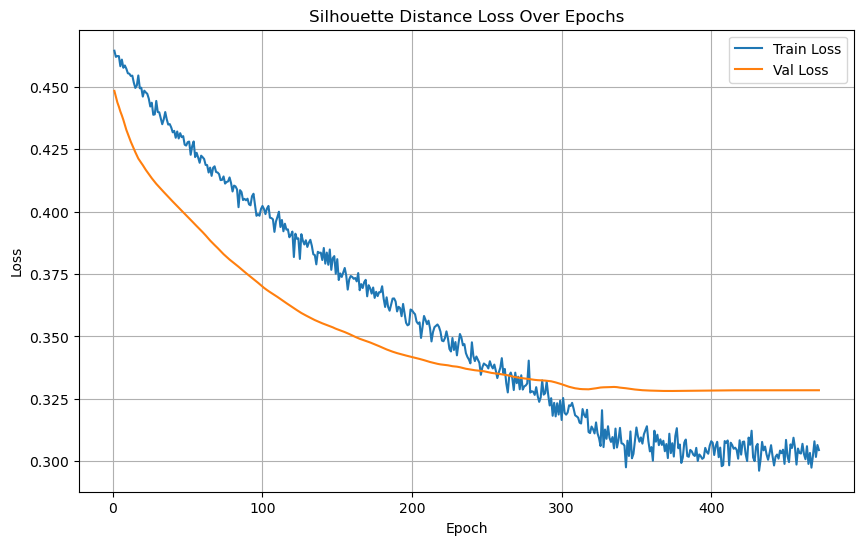

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/665], Loss: 0.3134


Test Batch [20/665], Loss: 0.2608
Test Batch [30/665], Loss: 0.2766


Test Batch [40/665], Loss: 0.3553
Test Batch [50/665], Loss: 0.3207


Test Batch [60/665], Loss: 0.2597
Test Batch [70/665], Loss: 0.1479


Test Batch [80/665], Loss: 0.1849
Test Batch [90/665], Loss: 0.1496


Test Batch [100/665], Loss: 0.1734
Test Batch [110/665], Loss: 0.1099
Test Batch [120/665], Loss: 0.1803


Test Batch [130/665], Loss: 0.1365


Test Batch [140/665], Loss: 0.1538
Test Batch [150/665], Loss: 0.5000
Test Batch [160/665], Loss: 0.1714
Test Batch [170/665], Loss: 0.1842


Test Batch [180/665], Loss: 0.5000
Test Batch [190/665], Loss: 0.1713


Test Batch [200/665], Loss: 0.1907
Test Batch [210/665], Loss: 0.5000
Test Batch [220/665], Loss: 0.1798
Test Batch [230/665], Loss: 0.1836
Test Batch [240/665], Loss: 0.5000
Test Batch [250/665], Loss: 0.5000
Test Batch [260/665], Loss: 0.5000
Test Batch [270/665], Loss: 0.5000


Test Batch [280/665], Loss: 0.5000
Test Batch [290/665], Loss: 0.5000
Test Batch [300/665], Loss: 0.5000


Test Batch [310/665], Loss: 0.1736
Test Batch [320/665], Loss: 0.2177
Test Batch [330/665], Loss: 0.1882


Test Batch [340/665], Loss: 0.2474


Test Batch [350/665], Loss: 0.2140
Test Batch [360/665], Loss: 0.1967


Test Batch [370/665], Loss: 0.2103


Test Batch [380/665], Loss: 0.1959
Test Batch [390/665], Loss: 0.1526


Test Batch [400/665], Loss: 0.1307


Test Batch [410/665], Loss: 0.1632
Test Batch [420/665], Loss: 0.1558


Test Batch [430/665], Loss: 0.2464


Test Batch [440/665], Loss: 0.3519
Test Batch [450/665], Loss: 0.3539
Test Batch [460/665], Loss: 0.4219


Test Batch [470/665], Loss: 0.2606
Test Batch [480/665], Loss: 0.2568
Test Batch [490/665], Loss: 0.2474


Test Batch [500/665], Loss: 0.2890
Test Batch [510/665], Loss: 0.1517
Test Batch [520/665], Loss: 0.2471


Test Batch [530/665], Loss: 0.2521
Test Batch [540/665], Loss: 0.2458
Test Batch [550/665], Loss: 0.5000


Test Batch [560/665], Loss: 0.2130
Test Batch [570/665], Loss: 0.2979
Test Batch [580/665], Loss: 0.1968
Test Batch [590/665], Loss: 0.2374


Test Batch [600/665], Loss: 0.3380
Test Batch [610/665], Loss: 0.2814
Test Batch [620/665], Loss: 0.4457
Test Batch [630/665], Loss: 0.3284
Test Batch [640/665], Loss: 0.2035


Test Batch [650/665], Loss: 0.4086
Test Batch [660/665], Loss: 0.4082

Test Loss: 0.2882


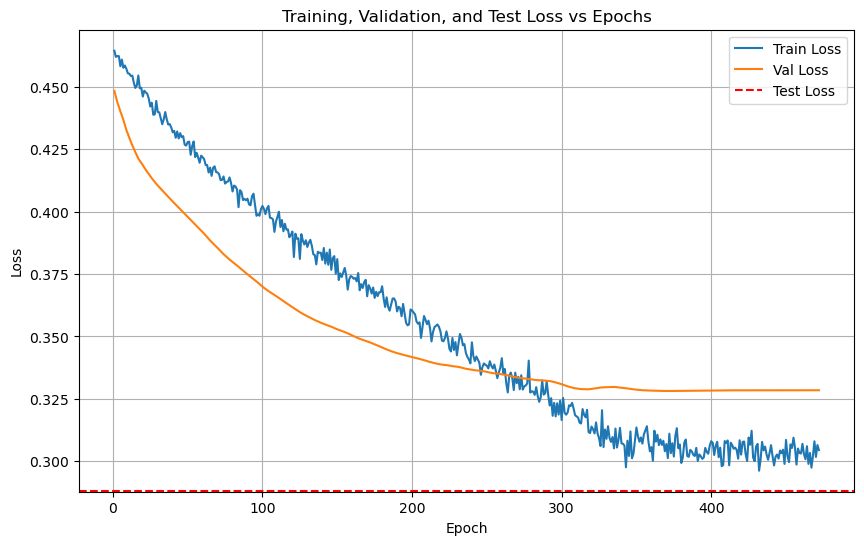

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/665 for test dataset.
  Processed batch 20/665 for test dataset.


  Processed batch 30/665 for test dataset.
  Processed batch 40/665 for test dataset.
  Processed batch 50/665 for test dataset.
  Processed batch 60/665 for test dataset.


  Processed batch 70/665 for test dataset.
  Processed batch 80/665 for test dataset.


  Processed batch 90/665 for test dataset.
  Processed batch 100/665 for test dataset.
  Processed batch 110/665 for test dataset.


  Processed batch 120/665 for test dataset.
  Processed batch 130/665 for test dataset.
  Processed batch 140/665 for test dataset.
  Processed batch 150/665 for test dataset.


  Processed batch 160/665 for test dataset.
  Processed batch 170/665 for test dataset.
  Processed batch 180/665 for test dataset.


  Processed batch 190/665 for test dataset.
  Processed batch 200/665 for test dataset.
  Processed batch 210/665 for test dataset.
  Processed batch 220/665 for test dataset.


  Processed batch 230/665 for test dataset.
  Processed batch 240/665 for test dataset.
  Processed batch 250/665 for test dataset.
  Processed batch 260/665 for test dataset.


  Processed batch 270/665 for test dataset.
  Processed batch 280/665 for test dataset.
  Processed batch 290/665 for test dataset.


  Processed batch 300/665 for test dataset.
  Processed batch 310/665 for test dataset.
  Processed batch 320/665 for test dataset.


  Processed batch 330/665 for test dataset.
  Processed batch 340/665 for test dataset.
  Processed batch 350/665 for test dataset.


  Processed batch 360/665 for test dataset.
  Processed batch 370/665 for test dataset.
  Processed batch 380/665 for test dataset.


  Processed batch 390/665 for test dataset.
  Processed batch 400/665 for test dataset.
  Processed batch 410/665 for test dataset.


  Processed batch 420/665 for test dataset.
  Processed batch 430/665 for test dataset.
  Processed batch 440/665 for test dataset.
  Processed batch 450/665 for test dataset.


  Processed batch 460/665 for test dataset.
  Processed batch 470/665 for test dataset.
  Processed batch 480/665 for test dataset.
  Processed batch 490/665 for test dataset.


  Processed batch 500/665 for test dataset.
  Processed batch 510/665 for test dataset.
  Processed batch 520/665 for test dataset.


  Processed batch 530/665 for test dataset.
  Processed batch 540/665 for test dataset.
  Processed batch 550/665 for test dataset.


  Processed batch 560/665 for test dataset.
  Processed batch 570/665 for test dataset.
  Processed batch 580/665 for test dataset.


  Processed batch 590/665 for test dataset.
  Processed batch 600/665 for test dataset.
  Processed batch 610/665 for test dataset.


  Processed batch 620/665 for test dataset.
  Processed batch 630/665 for test dataset.
  Processed batch 640/665 for test dataset.
  Processed batch 650/665 for test dataset.


  Processed batch 660/665 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.80      0.80      0.80         5
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       0.71      1.00      0.83         5
           7       0.57      0.80      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.84      0.82      0.82        45
weighted avg       0.84      0.82      0.82        45


LOG: Evaluating on the test set...
Test Accuracy: 75.12%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4298  |  Val Loss: 2.3756
Validation loss improved from inf to 2.3756.
[Epoch 2/1000] Train Loss: 2.3800  |  Val Loss: 2.3334
Validation loss improved from 2.3756 to 2.3334.
[Epoch 3/1000] Train Loss: 2.3374  |  Val Loss: 2.2930
Validation loss improved from 2.3334 to 2.2930.
[Epoch 4/1000] Train Loss: 2.2940  |  Val Loss: 2.2535
Validation loss improved from 2.2930 to 2.2535.
[Epoch 5/1000] Train Loss: 2.2520  |  Val Loss: 2.2157
Validation loss improved from 2.2535 to 2.2157.
[Epoch 6/1000] Train Loss: 2.2122  |  Val Loss: 2.1798
Validation loss improved from 2.2157 to 2.1798.
[Epoch 7/1000] Train Loss: 2.1758  |  Val Loss: 2.1456
Validation loss improved from 2.1798 to 2.1456.
[Epoch 8/1000] Train Loss: 2.1390  |  Val Loss: 2.1142
Validation loss improved from 2.1456 to 2.1142.
[Epoch 9/1000] Train Loss: 2.1041  |  Val Loss: 2.0844
Validation loss improved from 2.1142 to 2.0844.
[Epoch 10/1000] Train Loss: 2.0709  |  Val Loss: 2.0556
Validation loss impr

[Epoch 27/1000] Train Loss: 1.6516  |  Val Loss: 1.6879
Validation loss improved from 1.7073 to 1.6879.
[Epoch 28/1000] Train Loss: 1.6298  |  Val Loss: 1.6686
Validation loss improved from 1.6879 to 1.6686.
[Epoch 29/1000] Train Loss: 1.6084  |  Val Loss: 1.6495
Validation loss improved from 1.6686 to 1.6495.
[Epoch 30/1000] Train Loss: 1.5879  |  Val Loss: 1.6308
Validation loss improved from 1.6495 to 1.6308.
[Epoch 31/1000] Train Loss: 1.5674  |  Val Loss: 1.6129
Validation loss improved from 1.6308 to 1.6129.
[Epoch 32/1000] Train Loss: 1.5475  |  Val Loss: 1.5957
Validation loss improved from 1.6129 to 1.5957.
[Epoch 33/1000] Train Loss: 1.5289  |  Val Loss: 1.5786
Validation loss improved from 1.5957 to 1.5786.


[Epoch 34/1000] Train Loss: 1.5105  |  Val Loss: 1.5619
Validation loss improved from 1.5786 to 1.5619.
[Epoch 35/1000] Train Loss: 1.4923  |  Val Loss: 1.5459
Validation loss improved from 1.5619 to 1.5459.
[Epoch 36/1000] Train Loss: 1.4749  |  Val Loss: 1.5300
Validation loss improved from 1.5459 to 1.5300.
[Epoch 37/1000] Train Loss: 1.4581  |  Val Loss: 1.5145
Validation loss improved from 1.5300 to 1.5145.
[Epoch 38/1000] Train Loss: 1.4417  |  Val Loss: 1.4991
Validation loss improved from 1.5145 to 1.4991.
[Epoch 39/1000] Train Loss: 1.4254  |  Val Loss: 1.4841
Validation loss improved from 1.4991 to 1.4841.
[Epoch 40/1000] Train Loss: 1.4095  |  Val Loss: 1.4695
Validation loss improved from 1.4841 to 1.4695.
[Epoch 41/1000] Train Loss: 1.3941  |  Val Loss: 1.4553
Validation loss improved from 1.4695 to 1.4553.
[Epoch 42/1000] Train Loss: 1.3784  |  Val Loss: 1.4417
Validation loss improved from 1.4553 to 1.4417.
[Epoch 43/1000] Train Loss: 1.3637  |  Val Loss: 1.4282
Validati

[Epoch 58/1000] Train Loss: 1.1761  |  Val Loss: 1.2616
Validation loss improved from 1.2711 to 1.2616.
[Epoch 59/1000] Train Loss: 1.1650  |  Val Loss: 1.2522
Validation loss improved from 1.2616 to 1.2522.
[Epoch 60/1000] Train Loss: 1.1542  |  Val Loss: 1.2429
Validation loss improved from 1.2522 to 1.2429.
[Epoch 61/1000] Train Loss: 1.1436  |  Val Loss: 1.2338
Validation loss improved from 1.2429 to 1.2338.
[Epoch 62/1000] Train Loss: 1.1327  |  Val Loss: 1.2249
Validation loss improved from 1.2338 to 1.2249.
[Epoch 63/1000] Train Loss: 1.1221  |  Val Loss: 1.2160
Validation loss improved from 1.2249 to 1.2160.


[Epoch 64/1000] Train Loss: 1.1119  |  Val Loss: 1.2071
Validation loss improved from 1.2160 to 1.2071.
[Epoch 65/1000] Train Loss: 1.1013  |  Val Loss: 1.1983
Validation loss improved from 1.2071 to 1.1983.
[Epoch 66/1000] Train Loss: 1.0910  |  Val Loss: 1.1894
Validation loss improved from 1.1983 to 1.1894.
[Epoch 67/1000] Train Loss: 1.0807  |  Val Loss: 1.1808
Validation loss improved from 1.1894 to 1.1808.
[Epoch 68/1000] Train Loss: 1.0705  |  Val Loss: 1.1722
Validation loss improved from 1.1808 to 1.1722.
[Epoch 69/1000] Train Loss: 1.0604  |  Val Loss: 1.1639
Validation loss improved from 1.1722 to 1.1639.
[Epoch 70/1000] Train Loss: 1.0504  |  Val Loss: 1.1555
Validation loss improved from 1.1639 to 1.1555.
[Epoch 71/1000] Train Loss: 1.0402  |  Val Loss: 1.1474
Validation loss improved from 1.1555 to 1.1474.
[Epoch 72/1000] Train Loss: 1.0301  |  Val Loss: 1.1392
Validation loss improved from 1.1474 to 1.1392.
[Epoch 73/1000] Train Loss: 1.0202  |  Val Loss: 1.1313
Validati

[Epoch 88/1000] Train Loss: 0.8770  |  Val Loss: 1.0211
Validation loss improved from 1.0280 to 1.0211.


[Epoch 89/1000] Train Loss: 0.8680  |  Val Loss: 1.0143
Validation loss improved from 1.0211 to 1.0143.
[Epoch 90/1000] Train Loss: 0.8592  |  Val Loss: 1.0076
Validation loss improved from 1.0143 to 1.0076.
[Epoch 91/1000] Train Loss: 0.8499  |  Val Loss: 1.0010
Validation loss improved from 1.0076 to 1.0010.
[Epoch 92/1000] Train Loss: 0.8410  |  Val Loss: 0.9944
Validation loss improved from 1.0010 to 0.9944.
[Epoch 93/1000] Train Loss: 0.8322  |  Val Loss: 0.9878
Validation loss improved from 0.9944 to 0.9878.
[Epoch 94/1000] Train Loss: 0.8235  |  Val Loss: 0.9812
Validation loss improved from 0.9878 to 0.9812.
[Epoch 95/1000] Train Loss: 0.8146  |  Val Loss: 0.9748
Validation loss improved from 0.9812 to 0.9748.
[Epoch 96/1000] Train Loss: 0.8057  |  Val Loss: 0.9686
Validation loss improved from 0.9748 to 0.9686.
[Epoch 97/1000] Train Loss: 0.7968  |  Val Loss: 0.9624
Validation loss improved from 0.9686 to 0.9624.
[Epoch 98/1000] Train Loss: 0.7885  |  Val Loss: 0.9563
Validati

[Epoch 120/1000] Train Loss: 0.6094  |  Val Loss: 0.8386
Validation loss improved from 0.8431 to 0.8386.
[Epoch 121/1000] Train Loss: 0.6021  |  Val Loss: 0.8340
Validation loss improved from 0.8386 to 0.8340.
[Epoch 122/1000] Train Loss: 0.5949  |  Val Loss: 0.8296
Validation loss improved from 0.8340 to 0.8296.
[Epoch 123/1000] Train Loss: 0.5873  |  Val Loss: 0.8251
Validation loss improved from 0.8296 to 0.8251.
[Epoch 124/1000] Train Loss: 0.5803  |  Val Loss: 0.8209
Validation loss improved from 0.8251 to 0.8209.
[Epoch 125/1000] Train Loss: 0.5727  |  Val Loss: 0.8168
Validation loss improved from 0.8209 to 0.8168.
[Epoch 126/1000] Train Loss: 0.5660  |  Val Loss: 0.8126
Validation loss improved from 0.8168 to 0.8126.
[Epoch 127/1000] Train Loss: 0.5591  |  Val Loss: 0.8085
Validation loss improved from 0.8126 to 0.8085.
[Epoch 128/1000] Train Loss: 0.5521  |  Val Loss: 0.8047
Validation loss improved from 0.8085 to 0.8047.
[Epoch 129/1000] Train Loss: 0.5454  |  Val Loss: 0.801

[Epoch 153/1000] Train Loss: 0.4079  |  Val Loss: 0.7326
Validation loss improved from 0.7346 to 0.7326.
[Epoch 154/1000] Train Loss: 0.4031  |  Val Loss: 0.7305
Validation loss improved from 0.7326 to 0.7305.
[Epoch 155/1000] Train Loss: 0.3986  |  Val Loss: 0.7285
Validation loss improved from 0.7305 to 0.7285.
[Epoch 156/1000] Train Loss: 0.3943  |  Val Loss: 0.7269
Validation loss improved from 0.7285 to 0.7269.
[Epoch 157/1000] Train Loss: 0.3895  |  Val Loss: 0.7253
Validation loss improved from 0.7269 to 0.7253.
[Epoch 158/1000] Train Loss: 0.3851  |  Val Loss: 0.7235
Validation loss improved from 0.7253 to 0.7235.
[Epoch 159/1000] Train Loss: 0.3805  |  Val Loss: 0.7218
Validation loss improved from 0.7235 to 0.7218.
[Epoch 160/1000] Train Loss: 0.3763  |  Val Loss: 0.7201
Validation loss improved from 0.7218 to 0.7201.
[Epoch 161/1000] Train Loss: 0.3722  |  Val Loss: 0.7186
Validation loss improved from 0.7201 to 0.7186.
[Epoch 162/1000] Train Loss: 0.3682  |  Val Loss: 0.717

[Epoch 185/1000] Train Loss: 0.2892  |  Val Loss: 0.6924
Validation loss improved from 0.6932 to 0.6924.
[Epoch 186/1000] Train Loss: 0.2863  |  Val Loss: 0.6918
Validation loss improved from 0.6924 to 0.6918.
[Epoch 187/1000] Train Loss: 0.2836  |  Val Loss: 0.6912
Validation loss improved from 0.6918 to 0.6912.
[Epoch 188/1000] Train Loss: 0.2810  |  Val Loss: 0.6904
Validation loss improved from 0.6912 to 0.6904.
[Epoch 189/1000] Train Loss: 0.2783  |  Val Loss: 0.6900
Validation loss improved from 0.6904 to 0.6900.
[Epoch 190/1000] Train Loss: 0.2757  |  Val Loss: 0.6895
Validation loss improved from 0.6900 to 0.6895.
[Epoch 191/1000] Train Loss: 0.2731  |  Val Loss: 0.6887
Validation loss improved from 0.6895 to 0.6887.
[Epoch 192/1000] Train Loss: 0.2706  |  Val Loss: 0.6881
Validation loss improved from 0.6887 to 0.6881.
[Epoch 193/1000] Train Loss: 0.2682  |  Val Loss: 0.6871
Validation loss improved from 0.6881 to 0.6871.
[Epoch 194/1000] Train Loss: 0.2657  |  Val Loss: 0.686

[Epoch 220/1000] Train Loss: 0.2145  |  Val Loss: 0.6812
Validation loss improved from 0.6815 to 0.6812.
[Epoch 221/1000] Train Loss: 0.2128  |  Val Loss: 0.6810
Validation loss improved from 0.6812 to 0.6810.
[Epoch 222/1000] Train Loss: 0.2114  |  Val Loss: 0.6811
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 223/1000] Train Loss: 0.2098  |  Val Loss: 0.6810
Validation loss improved from 0.6810 to 0.6810.
[Epoch 224/1000] Train Loss: 0.2083  |  Val Loss: 0.6808
Validation loss improved from 0.6810 to 0.6808.
[Epoch 225/1000] Train Loss: 0.2067  |  Val Loss: 0.6806
Validation loss improved from 0.6808 to 0.6806.
[Epoch 226/1000] Train Loss: 0.2052  |  Val Loss: 0.6807
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 227/1000] Train Loss: 0.2037  |  Val Loss: 0.6808
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 228/1000] Train Loss: 0.2023  |  Val Loss: 0.6809
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 229/1000] Train Loss: 0.

[Epoch 248/1000] Train Loss: 0.1773  |  Val Loss: 0.6829
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 249/1000] Train Loss: 0.1761  |  Val Loss: 0.6831
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 250/1000] Train Loss: 0.1750  |  Val Loss: 0.6830
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 251/1000] Train Loss: 0.1739  |  Val Loss: 0.6832
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 252/1000] Train Loss: 0.1729  |  Val Loss: 0.6832
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 253/1000] Train Loss: 0.1719  |  Val Loss: 0.6834
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 254/1000] Train Loss: 0.1709  |  Val Loss: 0.6837
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 255/1000] Train Loss: 0.1699  |  Val Loss: 0.6840
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 256/1000] Train Loss: 0.1688  |  Val Loss: 0.6840
!! Validation loss did NOT improve !! Patience:

[Epoch 279/1000] Train Loss: 0.1481  |  Val Loss: 0.6882
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 280/1000] Train Loss: 0.1473  |  Val Loss: 0.6882
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 281/1000] Train Loss: 0.1466  |  Val Loss: 0.6887
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 282/1000] Train Loss: 0.1457  |  Val Loss: 0.6886
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 283/1000] Train Loss: 0.1450  |  Val Loss: 0.6891
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 284/1000] Train Loss: 0.1442  |  Val Loss: 0.6894
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 285/1000] Train Loss: 0.1435  |  Val Loss: 0.6899
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 286/1000] Train Loss: 0.1427  |  Val Loss: 0.6901
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 287/1000] Train Loss: 0.1419  |  Val Loss: 0.6902
!! Validation loss did NOT improve !! Patience:

[Epoch 311/1000] Train Loss: 0.1265  |  Val Loss: 0.6946
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 312/1000] Train Loss: 0.1260  |  Val Loss: 0.6949
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 313/1000] Train Loss: 0.1254  |  Val Loss: 0.6953
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 314/1000] Train Loss: 0.1248  |  Val Loss: 0.6957
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 315/1000] Train Loss: 0.1243  |  Val Loss: 0.6958
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 316/1000] Train Loss: 0.1238  |  Val Loss: 0.6960
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 317/1000] Train Loss: 0.1234  |  Val Loss: 0.6962
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 318/1000] Train Loss: 0.1228  |  Val Loss: 0.6965
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 319/1000] Train Loss: 0.1221  |  Val Loss: 0.6968
!! Validation loss did NOT improve !! Patience:

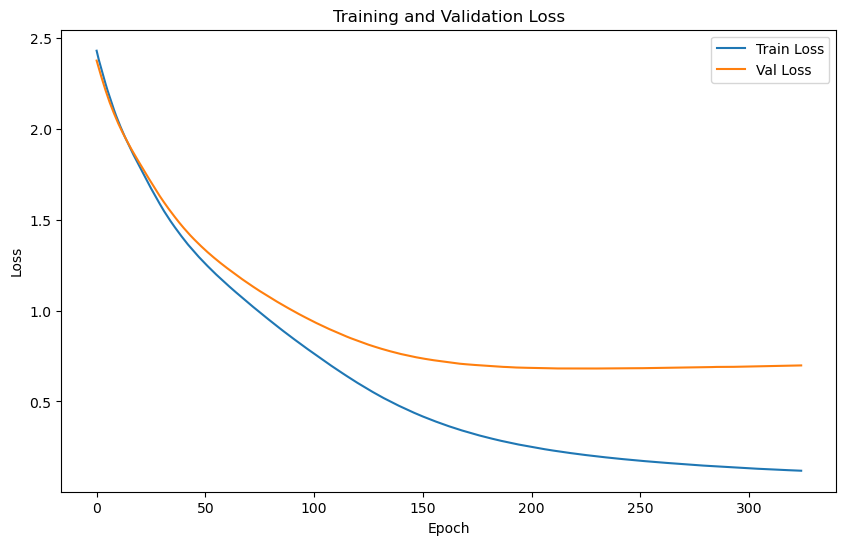

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.8119 | Test Accuracy: 74.38%


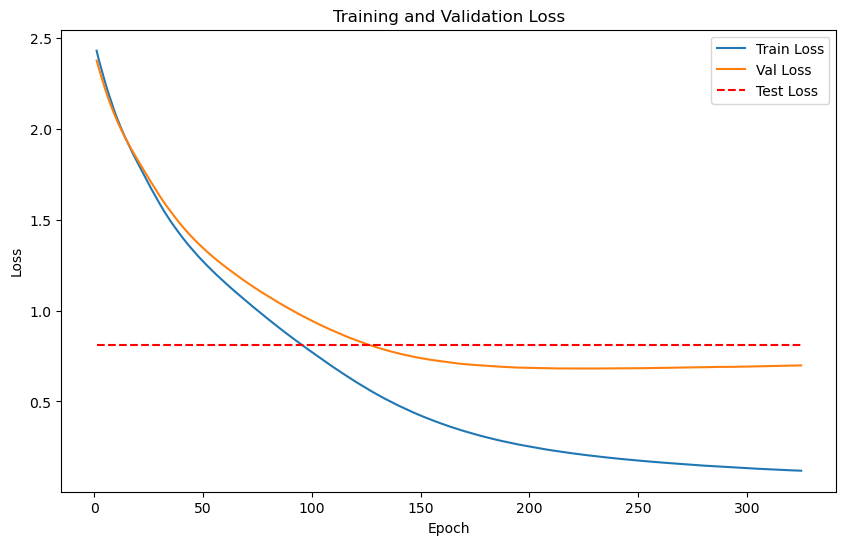

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


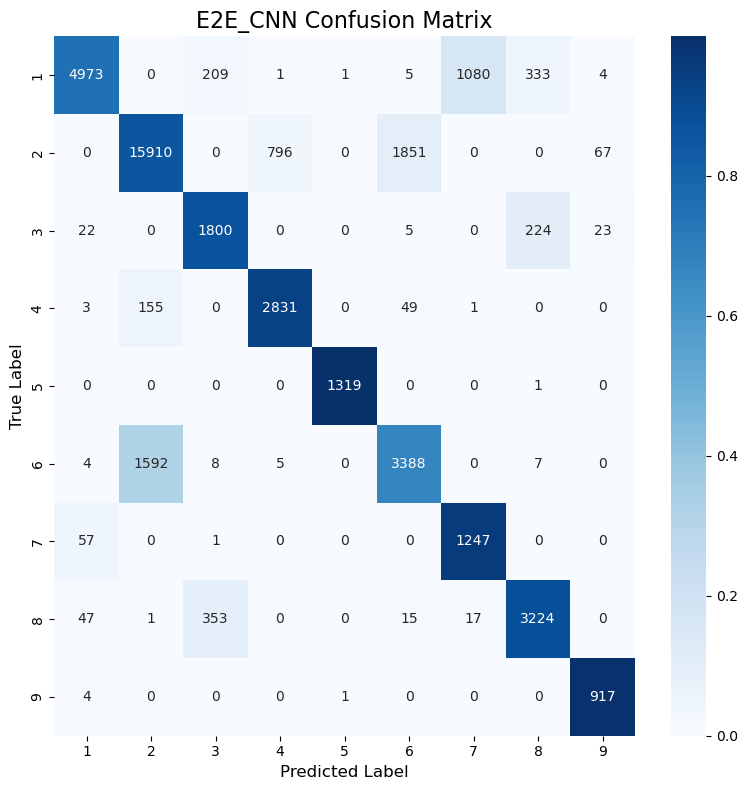

Classification Accuracy: 83.69%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


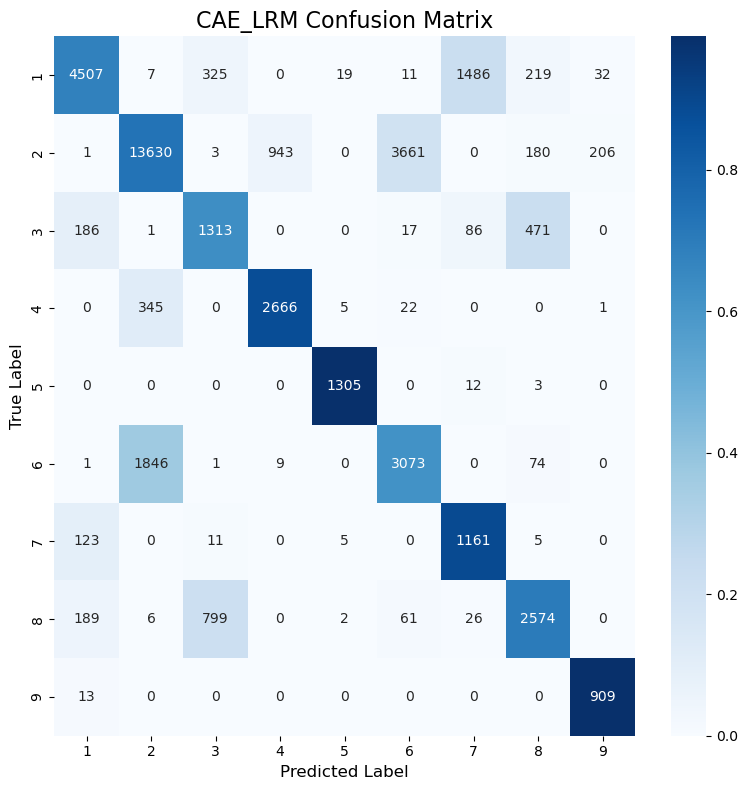

Classification Accuracy: 73.18%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


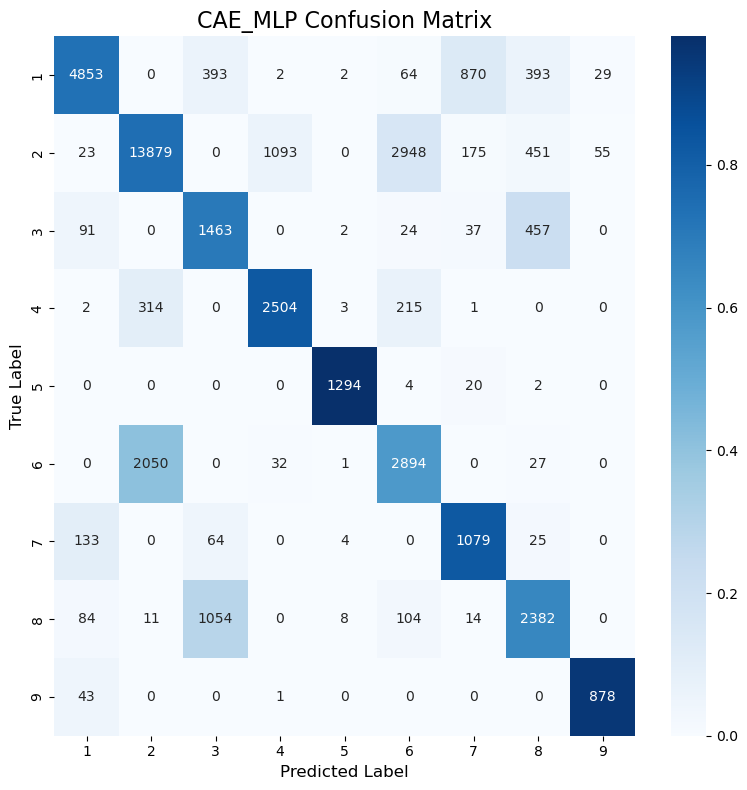

Classification Accuracy: 73.38%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


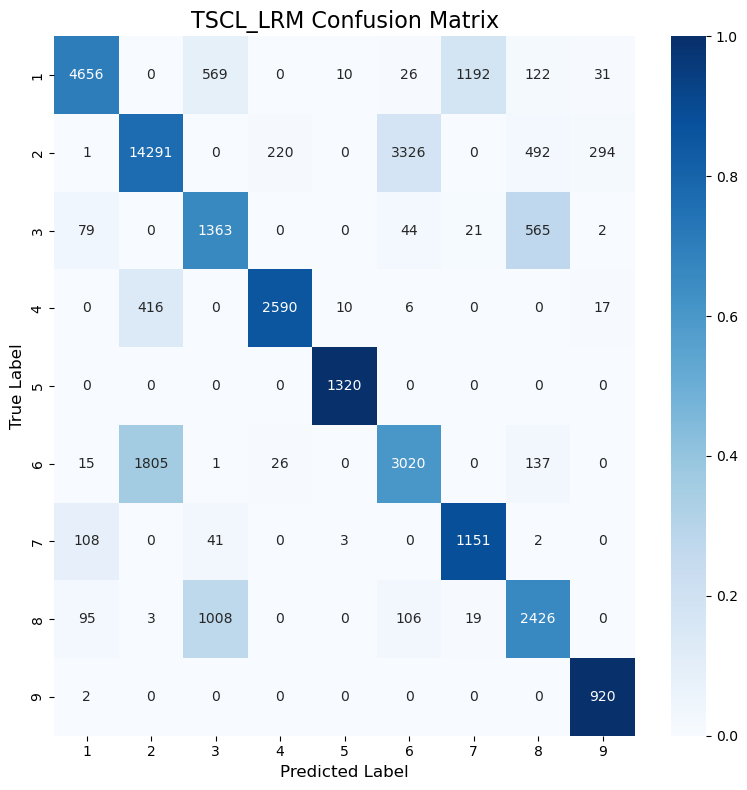

Classification Accuracy: 74.59%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


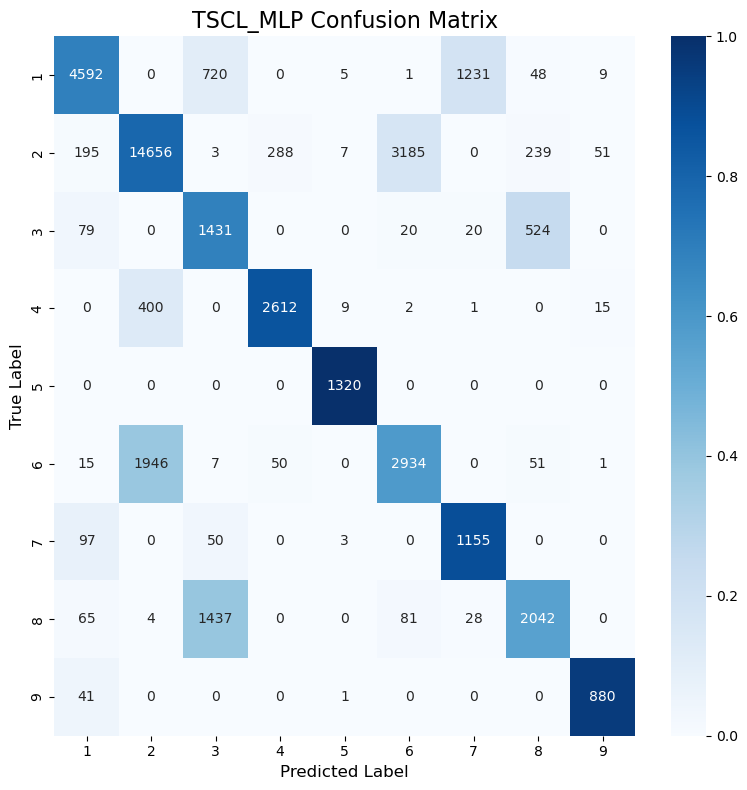

Classification Accuracy: 74.32%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


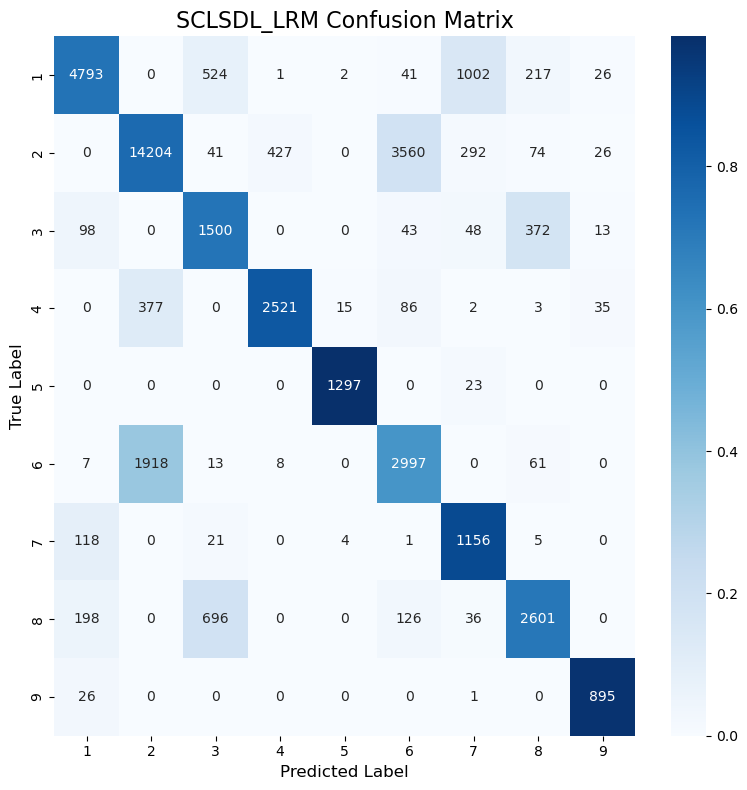

Classification Accuracy: 75.12%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


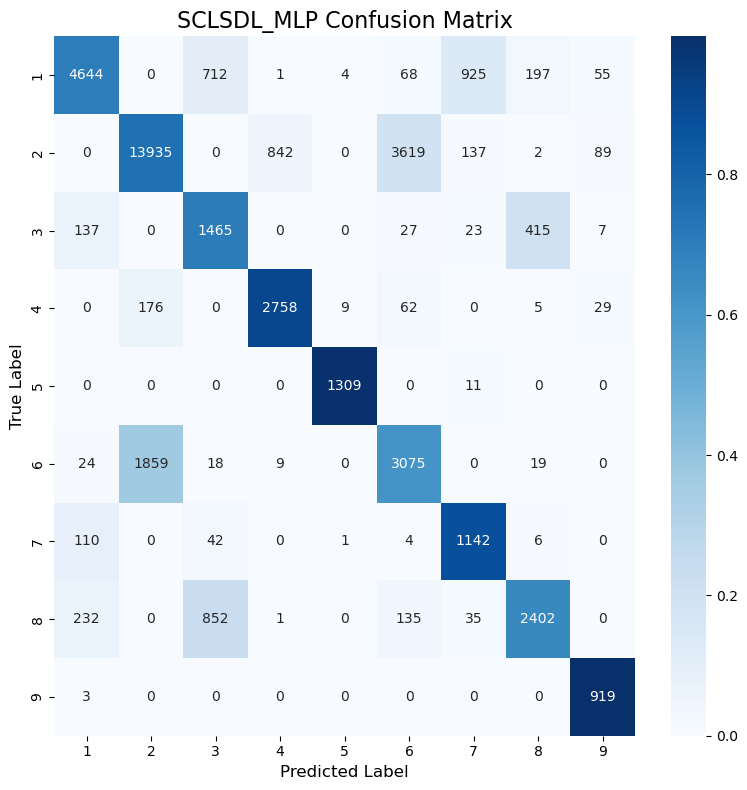

Classification Accuracy: 74.38%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          83.69
1    LRM (CAE)          73.18
2    MLP (CAE)          73.38
3     TSCL LRM          74.59
4     TSCL MLP          74.32
5  SCL_SDL LRM          75.12
6  SCL_SDL MLP          74.38

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          83.69
5  SCL_SDL LRM          75.12
3     TSCL LRM          74.59
6  SCL_SDL MLP          74.38
4     TSCL MLP          74.32
2    MLP (CAE)          73.38
1    LRM (CAE)          73.18
